In [7]:
%reload_ext mocodo

In [8]:
from IPython import display
from pathlib import Path
import re
import os
if os.path.basename(os.getcwd()) != "mocodo_notebook":
    os.chdir("mocodo_notebook")

![](https://cdn.rawgit.com/laowantong/mocodo/master/logos/banner.svg)

# Introduction

Mocodo est un logiciel d'aide √† l'enseignement et √† la conception des [bases de donn√©es relationnelles](https://fr.wikipedia.org/wiki/Base_de_donn√©es_relationnelle).

- En entr√©e, il prend une description textuelle des entit√©s et associations du mod√®le conceptuel de donn√©es ([MCD](https://fr.wikipedia.org/wiki/Mod√®le_entit√©-association)).
- En sortie, il trace un diagramme entit√©-association qu'il peut arranger automatiquement de fa√ßon esth√©tique.
- √Ä la demande, il le convertit en relationnel ([MLD](https://fr.wikipedia.org/wiki/Merise_(informatique)#MLD_:_mod√®le_logique_des_donn√©es)), en requ√™tes de cr√©ation ([DDL](https://fr.wikipedia.org/wiki/Langage_de_d√©finition_de_donn√©es)), en [diagramme de classes UML](https://fr.wikipedia.org/wiki/Diagramme_de_classes), etc.
- Il permet de transformer rapidement un MCD en un autre par application de diverses op√©rations de r√©√©criture.

## Trac√© du mod√®le conceptuel

Ci-dessous, un exemple d'utilisation sous [Jupyter Notebook](https://jupyter.org). L'appel du programme est en premi√®re ligne, sur un texte d'entr√©e donn√© lignes suivantes dans un langage d√©di√©, √©galement appel√© Mocodo. En sortie, le diagramme conceptuel (MCD), agr√©ment√© ici avec l'option `--colors`¬†:

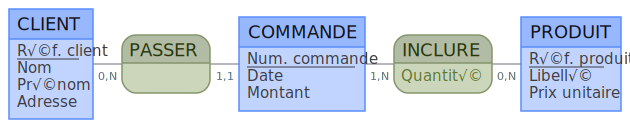

In [5]:
%%mocodo --colors ocean
CLIENT: R√©f. client [VARCHAR(8)], Nom [VARCHAR(255)], Pr√©nom [VARCHAR(255)], Adresse [VARCHAR(255)]
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande [VARCHAR(8)], Date [DATE], Montant [DECIMAL(10,2)]
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√© [INTEGER]
PRODUIT: R√©f. produit [VARCHAR(8)], Libell√© [VARCHAR(50)], Prix unitaire [DECIMAL(10,2)]

## Op√©rations de conversion

L'appel pr√©c√©dent a automatiquement enregistr√© le texte-source dans le r√©pertoire courant sous le nom de `sandbox.mcd`. On peut r√©cup√©rer celui-ci (`--input`) pour lui appliquer diverses op√©rations, par exemple le convertir (`--convert`) en dictionnaire des donn√©es (`data_dict`). Par d√©faut, le r√©sultat est un tableau Markdown √† trois colonnes¬†:

In [6]:
%mocodo --input sandbox --convert data_dict

| Entit√© ou association | Libell√© de l'attribut | Type |
|:---|:---|:---|
| CLIENT | Adresse | VARCHAR(255) |
| " | Nom | VARCHAR(255) |
| " | Pr√©nom | VARCHAR(255) |
| " | R√©f. client | VARCHAR(8) |
| COMMANDE | Date | DATE |
| " | Montant | DECIMAL(10,2) |
| " | Num. commande | VARCHAR(8) |
| INCLURE | Quantit√© | INTEGER |
| PRODUIT | Libell√© | VARCHAR(50) |
| " | Prix unitaire | DECIMAL(10,2) |
| " | R√©f. produit | VARCHAR(8) |


Avec le sous-argument `rel`, on g√©n√®re le sch√©ma relationnel¬†:

In [15]:
%mocodo --input sandbox --convert rel

**CLIENT** (<ins>R√©f. client</ins>, Nom, Pr√©nom, Adresse)<br>
**COMMANDE** (<ins>Num. commande</ins>, Date, Montant, _#R√©f. client_)<br>
**INCLURE** (<ins>_#Num. commande_</ins>, <ins>_#R√©f. produit_</ins>, Quantit√©)<br>
**PRODUIT** (<ins>R√©f. produit</ins>, Libell√©, Prix unitaire)


Le sous-argument `rel:diagram` permet de visualiser le diagramme correspondant¬†:

In [8]:
%mocodo --input sandbox --convert rel:diagram --colors desert

Et bien s√ªr, on peut aller jusqu'au niveau SQL¬†:

In [9]:
%mocodo --input sandbox --convert rel:sqlite --title="VPC"

```sql
.open "VPC";

CREATE TABLE "CLIENT" (
  "r√©f_client" VARCHAR(8),
  "nom" VARCHAR(255),
  "pr√©nom" VARCHAR(255),
  "adresse" VARCHAR(255),
  PRIMARY KEY ("r√©f_client")
);

CREATE TABLE "COMMANDE" (
  "num_commande" VARCHAR(8),
  "date" DATE,
  "montant" DECIMAL(10,2),
  "r√©f_client" VARCHAR(8),
  PRIMARY KEY ("num_commande"),
  FOREIGN KEY ("r√©f_client") REFERENCES "CLIENT" ("r√©f_client")
);

CREATE TABLE "INCLURE" (
  "num_commande" VARCHAR(8),
  "r√©f_produit" VARCHAR(8),
  "quantit√©" INTEGER,
  PRIMARY KEY ("num_commande", "r√©f_produit"),
  FOREIGN KEY ("num_commande") REFERENCES "COMMANDE" ("num_commande"),
  FOREIGN KEY ("r√©f_produit") REFERENCES "PRODUIT" ("r√©f_produit")
);

CREATE TABLE "PRODUIT" (
  "r√©f_produit" VARCHAR(8),
  "libell√©" VARCHAR(50),
  "prix_unitaire" DECIMAL(10,2),
  PRIMARY KEY ("r√©f_produit")
);

```

Notre MCD peut √™tre transcrit dans d'autres formalismes, par exemple _crow's foot_ (`crow`) pour [Mermaid](http://mermaid.js.org) (`mmd`)¬†:

In [10]:
%mocodo --input sandbox --convert crow:mmd

```mmd
erDiagram
  CLIENT {
    VARCHAR(8) ref_client PK
    VARCHAR(255) nom
    VARCHAR(255) prenom
    VARCHAR(255) adresse
  }
  COMMANDE {
    VARCHAR(8) num_commande PK
    DATE date
    DECIMAL(10-2) montant
  }
  INCLURE {
    INTEGER quantite
  }
  PRODUIT {
    VARCHAR(8) ref_produit PK
    VARCHAR(50) libelle
    DECIMAL(10-2) prix_unitaire
  }
  CLIENT ||--o{ COMMANDE: PASSER
  INCLURE }|..|| COMMANDE: IN
  INCLURE }o..|| PRODUIT: IN

```

Le rendu des diagrammes cod√©s en Mermaid ou dans d'autres formats tiers n'est pas directement pris en charge, mais peut √™tre d√©l√©gu√© (`defer`) de fa√ßon transparente √† un service web appropri√©, simplement en pr√©cisant le format d'image attendu (`svg`)¬†:

In [11]:
%mocodo --input sandbox --convert crow:mmd defer:svg

## Op√©rations de r√©√©criture

√Ä partir d'un MCD Mocodo, une r√©√©criture (`--rewrite`) produit un autre MCD Mocodo (par opposition √† une conversion, qui r√©sulte en un tout autre animal). Par d√©faut, son ex√©cution affiche, au-dessous du diagramme, le code-source r√©sultant¬†: cela permet de le copier-coller dans une autre cellule pour continuer √† travailler dessus.

Mettons par exemple les noms des entit√©s et associations (`boxes`) en majuscules, et tous les libell√©s (`labels`) en ASCII et _snake case_¬†:

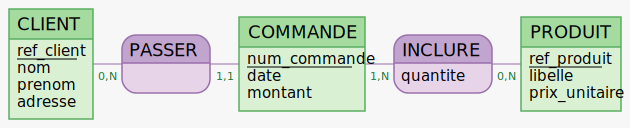

%%mocodo
CLIENT: ref_client [VARCHAR(8)], nom [VARCHAR(255)], prenom [VARCHAR(255)], adresse [VARCHAR(255)]
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: num_commande [VARCHAR(8)], date [DATE], montant [DECIMAL(10,2)]
INCLURE, 1N COMMANDE, 0N PRODUIT: quantite [INTEGER]
PRODUIT: ref_produit [VARCHAR(8)], libelle [VARCHAR(50)], prix_unitaire [DECIMAL(10,2)]


In [12]:
%mocodo --input sandbox --rewrite boxes:upper labels:ascii,snake --colors brewer+3

Quelques possibilit√©s de r√©√©criture s√©mantique sont offertes. Par exemple, on peut d√©composer un MCD quelconque en un MCD √©quivalent, mais n'employant que des d√©pendances fonctionnelles et des entit√©s faibles¬†:

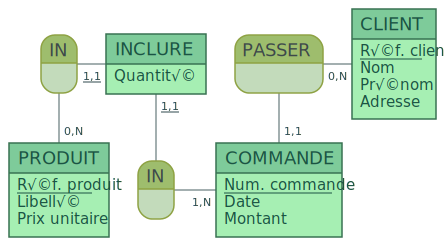

%%mocodo
IN2, _11 INCLURE, 0N PRODUIT
INCLURE: _Quantit√© [INTEGER]
PASSER, 0N CLIENT, 11 COMMANDE
CLIENT: R√©f. client [VARCHAR(8)], Nom [VARCHAR(255)], Pr√©nom [VARCHAR(255)], Adresse [VARCHAR(255)]

PRODUIT: R√©f. produit [VARCHAR(8)], Libell√© [VARCHAR(50)], Prix unitaire [DECIMAL(10,2)]
IN1, _11 INCLURE, 1N COMMANDE
COMMANDE: Num. commande [VARCHAR(8)], Date [DATE], Montant [DECIMAL(10,2)]
:


In [13]:
%mocodo --input sandbox --rewrite explode:weak,arity=2 arrange --seed=3 --colors pond

La sous-option `arrange` a proc√©d√© √† une r√©organisation des bo√Ætes, ce que la cr√©ation de deux nouvelles associations de d√©pendance fonctionnelles avait rendu n√©cessaire. Notez que, pour obtenir le m√™me r√©sultat √† chaque ex√©cution, nous avons fix√© le germe du g√©n√©rateur pseudo-al√©atoire (`--seed=3`).

**Remarque.** Mocodo met en ≈ìuvre une technique de r√©arrangement originale¬†: en contraignant la position des bo√Ætes aux intersections d'une grille invisible, il transforme un classique [probl√®me de plongement](https://en.wikipedia.org/wiki/Graph_embedding) en un [probl√®me d'affectation](https://fr.wikipedia.org/wiki/Probl√®me_d%27affectation), ce qui permet de satisfaire de fa√ßon efficace √† un certain nombre de contraintes esth√©tiques pertinentes (planarit√©, compacit√©, etc.).

Le r√©arrangement peut se faire automatiquement sur un nombre de rang√©es et de colonnes au rapport ¬´¬†√©quilibr√©¬†¬ª (i.e., proche du [nombre d'or](https://fr.wikipedia.org/wiki/Nombre_d%27or)), ou au contraire sp√©cifi√© par l'utilisateur. Ici, on constate que le MCD r√©sultant consiste en un ¬´¬†chapelet¬†¬ª d'entit√©s et d'associations. On peut donc demander √† l'arranger sur une seule ligne (`arrange:grid=7x1`)¬†:

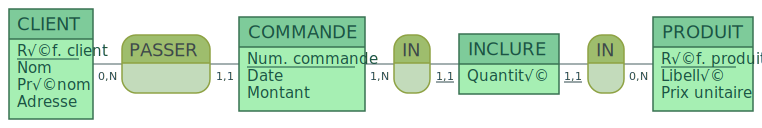

%%mocodo
CLIENT: R√©f. client [VARCHAR(8)], Nom [VARCHAR(255)], Pr√©nom [VARCHAR(255)], Adresse [VARCHAR(255)]
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande [VARCHAR(8)], Date [DATE], Montant [DECIMAL(10,2)]
IN1, _11 INCLURE, 1N COMMANDE
INCLURE: _Quantit√© [INTEGER]
IN2, _11 INCLURE, 0N PRODUIT
PRODUIT: R√©f. produit [VARCHAR(8)], Libell√© [VARCHAR(50)], Prix unitaire [DECIMAL(10,2)]


In [14]:
%mocodo --input sandbox --rewrite explode:weak,arity=2 arrange:grid=7x1 --seed=3 --colors pond

Apr√®s cet aper√ßu de quelques-unes des fonctionnalit√©s de Mocodo, passons aux choses s√©rieuses¬†!

# Installation du programme

## Installation compl√®te (recommand√©)

- Installez la [distribution Anaconda](https://www.anaconda.com/products/distribution), qui contient Python 3, Jupyter Notebook et bien plus encore.
- Ex√©cutez ensuite sous un terminal la ligne suivante pour installer Mocodo ainsi que sa ¬´¬†commande magique¬†¬ª (utilisable sous [Jupyter notebook](https://jupyter.org))¬†:

        python -m pip install mocodo

- Si vous souhaitez g√©n√©rer des figures en PDF ou en PNG¬†:

        python -m pip install cairosvg

## V√©rification

Toujours sous un terminal, tapez:

    mocodo

Si votre syst√®me se plaint que cette commande n'existe pas, localisez le fichier `mocodo` et ajoutez √† votre `PATH` le chemin du r√©pertoire contenant:
- [sous Linux ou macOS](http://www.commentcamarche.net/faq/3585-bash-la-variable-d-environnement-path#v-ajouter-un-repertoire-a-la-variable-path);
- [sous Windows](http://sametmax.com/ajouter-un-chemin-a-la-variable-denvironnement-path-sous-windows/).

Pour mettre la ¬´¬†commande magique¬†¬ª `mocodo` √† disposition d'un _notebook_ donn√©, √©valuez dans celui-ci la cellule suivante:

    %reload_ext mocodo

Techniquement, `%load_ext mocodo` suffit, mais cette forme vous √©pargnera un message d'erreur si vous r√©√©valuez ult√©rieurement la cellule.

Pour tester, √©valuez une cellule avec:

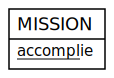

In [23]:
%%mocodo
MISSION: accomplie

Pour charger automatiquement `mocodo` √† chaque ouverture d'un notebook (ce qui dispense d'√©valuer `%load_ext mocodo`)¬†:

- ex√©cuter sous un terminal¬†:

			ipython profile create
	
- √©diter le fichier cr√©√© (p. ex.: `~/.ipython/profile_default/ipython_config.py`) pour remplacer les lignes suivantes¬†:

			## A list of dotted module names of IPython extensions to load.
			#c.InteractiveShellApp.extensions = []

  par celles-ci¬†:

			## A list of dotted module names of IPython extensions to load.
			c.InteractiveShellApp.extensions = [
			    "mocodo",
			]

## Installation minimale

- Si vous √™tes sous macOS ou Linux, vous avez d√©j√† Python 3. Dans le cas contraire, vous devrez probablement [l'installer](https://www.python.org/downloads/).
- Une fois Python install√©, tapez sous un terminal:

      python -m pip install mocodo

Vous ne b√©n√©ficierez pas de Jupyter Notebook, mais vous pourrez utiliser Mocodo en ligne de commande.

# Utilisation

Vous pouvez utiliser Mocodo¬†:

- √† distance, sans rien installer, avec [Mocodo _online_](https://www.mocodo.net);
- en local, comme n'importe quel programme Python;
- dans un document Jupyter Notebook (√† l'instar de cette documentation).

## Utiliser Mocodo _online_

Faites pointer votre navigateur sur www.mocodo.net¬†: vous pouvez commencer √† taper votre MCD. Appuyez √† tout moment sur le bouton de g√©n√©ration pour visualiser le diagramme conceptuel et en d√©duire les relations. Une fois que le r√©sultat vous convient, appuyez sur le bouton de t√©l√©chargement pour r√©cup√©rer une archive ZIP contenant tous les fichiers d'entr√©e et de sortie sp√©cifi√©s.

Mocodo _online_ est con√ßu pour une utilisation occasionnelle et/ou interactive, et son interface vise avant tout √† la simplicit√©. Vous n'avez donc acc√®s qu'aux options essentielles du programme. Si vous en voulez davantage, tant en termes de param√©trage que de calcul ou de fonctionnalit√©s, installez Mocodo sur votre machine.

## Utiliser Mocodo en ligne de commande

### Au plus simple

Tout a √©t√© fait pour faciliter au maximum la prise en main. Ainsi, pour peu que vous sachiez lancer une console (`cmd` sous Windows, Terminal sous macOS), il vous suffit d'y entrer:

```
mocodo
```

Invoqu√© sous cette forme, le script r√©cup√®re le texte d'entr√©e du MCD dans le r√©pertoire courant sous le nom de `sandbox.mcd`. Si ce fichier n'existe pas, il y sera automatiquement cr√©√© avec un MCD d'exemple. Par la suite, vous n'aurez qu'√† le garder ouvert sous un √©diteur de texte, afin de le modifier selon vos besoins avant de relancer la commande.

### Dissection de la commande `mocodo`

L'API de Mocodo a √©t√© revue de fa√ßon radicale pour la version 4.0. Le nombre d'options de premier niveau a √©t√© r√©duit¬†; en contrepartie, celles-ci sont devenues de v√©ritables mini-commandes, avec leur propre liste de sous-options, et une syntaxe et un comportement uniformes.

Introduisons, sur un exemple fictif, un vocabulaire que nous avons essay√© d'employer le plus rigoureusement possible tout au long de cette documentation (et dans le code lui-m√™me)¬†:

```
mocodo    --hide_notes    --rewrite  drain  arrange:grid  explode:weak,arity=2.5
```

- La **commande** `mocodo` est invoqu√©e avec les **options** `--hide_notes` et `--rewrite`.
- On passe √† la seconde trois **arguments** de complexit√© croissante, `drain`, `arrange:grid` et `explode:weak,arity=2.5`. Notez que le s√©parateur des arguments est l'espace. Par cons√©quent, un argument ne peut lui-m√™me contenir d'espaces (sauf entre guillemets).
- Chacun des arguments consiste en un nom de **sous-option** (`drain`, `arrange` ou `explode`), suivi √©ventuellement d'un deux-points (`:`), suivi d'une liste de **sous-arguments** s√©par√©s par des virgules (`,`).
- Chacun des sous-arguments consiste en un nom de **sous-sous-option**, suivi √©ventuellement d'un signe √©gal (`=`), suivi d'un **sous-sous-argument** (√©ventuellement entre guillemets).

On n'ira pas plus loin et, heureusement, la plupart des commandes r√©elles n'atteignent pas ce degr√© d'imbrication. La d√©composition suivante fixera peut-√™tre les id√©es, ou pourra du moins servir de r√©f√©rence en cas de doute¬†:

$$
\underbrace{\texttt{mocodo}}_{\text{command}}
\qquad
\texttt{-}\,\texttt{-}
\underbrace{\texttt{hide_notes}}_{\text{option}}
\qquad
\texttt{-}\,\texttt{-}
\underbrace{\texttt{rewrite}}_{\text{option}}
\qquad
\underbrace{
    \underbrace{
        \texttt{drain}
    }_{\text{sub-option}}
}_{\text{argument}}
\qquad
\underbrace{
    \underbrace{
        \texttt{arrange}
    }_{\text{sub-option}}
    \texttt{:}
    \underbrace{
        \underbrace{
            \texttt{grid}
        }_{\text{sub-sub-opt}}
    }_{\text{sub-arg}}
}_{\text{argument}}
\qquad
\underbrace{
    \underbrace{
        \texttt{explode}
    }_{\text{sub-option}}
    \texttt{:}
    \underbrace{
        \underbrace{
            \texttt{weak}
        }_{\text{sub-sub-opt}}
    }_{\text{sub-arg}}
    \texttt{,}
    \underbrace{
        \underbrace{
            \texttt{arity}
        }_{\text{sub-sub-opt}}
        \texttt{=}
        \underbrace{
            \texttt{2.5}
        }_{\text{sub-sub-arg}}
    }_{\text{sub-argument}}
}_{\text{argument}}
$$ 

L'int√©r√™t de cette structuration en arborescence est double. Elle permet¬†:
- de cr√©er des pipelines d'op√©rations¬†: le r√©sultat de l'application du premier argument est fourni en entr√©e au second, etc¬†;
- de regrouper les op√©rations interd√©pendantes. Par exemple, avant la version 4.0, l'argument `explode:weak,arity=2.5` aurait d√ª √™tre mis √† plat¬†: `--explode --weak_explosion --explosion_arity=2.5`. Un tel ¬´¬†tas¬†¬ª d'options est non seulement plus long, mais leur conf√®re ind√ªment le m√™me statut, masquant le fait que les deux derni√®res n'ont de sens qu'en pr√©sence de la premi√®re.

### Liste des options

TODO :
- compl√©ter le traitement des cl√©s alternatives dans les sorties autres que Markdown et MySQL. Deux items √† ajouter dans chacun.
- Mettre √† jour explode pour traiter (ou ignorer) les clusters.
- Cr√©er des transformations inverses¬†: implode, join (ou unsplit)
- Rendre -R idempotent.
- Imposer une cardinalit√© *1 autour d'une DF.
- Interdire la protection (+) des DF (lever un message d'erreur).
- Ajouter automatiquement des fl√®ches sur les patte oppos√©es √† la patte 11 des DF.
- Renommer "naturalized_" en "ex_".

In [13]:
%mocodo --help

usage: mocodo [--language CODE] [--params_path PATH] [--input PATH] [--help]
              [--version] [--restore] [--output_dir PATH]
              [--encodings [STR ...]] [--svg_to {png,pdf} [{png,pdf} ...]]
              [--print_params] [--reuse_geo] [--uid_suffix INT] [--no_mcd]
              [--mld] [--rewrite [STR ...]] [--convert STR [STR ...]]
              [--seed FLOAT] [--disambiguation {numbers_only,notes}]
              [--title STR] [--df STR] [--card_format [STR]]
              [--strengthen_card [STR]] [--flex FLOAT] [--colors STEM_OR_PATH]
              [--shapes STEM_OR_PATH] [--scale RATE] [--adjust_width RATE]
              [--hide_notes] [--detect_overlaps] [--gutters STR [STR ...]]

NAME:
  Mocodo - An Entity-Relation Diagram Generator.

DESCRIPTION:
  Mocodo is an open-source tool for designing and teaching relational databases.
  It takes as an input a textual description of both entities and associations
  of an entity-relationship diagram (ERD). It outputs a 

La commande `mocodo` admet de nombreux arguments optionnels. Voici la traduction en fran√ßais de la liste affich√©e par l'argument `--help`. Destin√©e √† servir de r√©f√©rence, elle peut √™tre [saut√©e](#Description-d'un-MCD) sans inconv√©nient √† la premi√®re lecture. Nous avons ajout√© des liens vers des exemples d'utilisation dans ce document¬†; notez cependant que les `%%` ou `%` qui pr√©fixent la ¬´¬†commande magique¬†¬ª `mocodo` doivent √™tre omis de la ligne de commande.

#### Options sur Mocodo lui-m√™me

- **`--help`**.
  Affiche un message d'aide, puis termine.
- **`--version`**.
  Affiche le num√©ro de version, puis termine.
- **`--language CODE`**.
  Outrepasse la localisation automatique des messages avec le code de langage donn√© (p. ex., `fr`, `en`, ...) (d√©faut: langue du syst√®me).
- **`--restore`**.
  Recr√©e une version originelle des fichiers `sandbox.mcd` et `params.json` dans le r√©pertoire d'entr√©e, puis termine (d√©faut: `False`).

#### Entr√©e-sortie

- **`--params_path PATH`**.
  Le chemin du fichier de param√®tres. S'il est omis, utilise `params.json` dans le r√©pertoire d'entr√©e. Si ce fichier n'existe pas, utilise les param√®tres par d√©faut (d√©faut: `params.json`).
- **`--input PATH`**.
  Le chemin du fichier d'entr√©e. Les fichiers de sortie seront par d√©faut g√©n√©r√©s dans le m√™me r√©pertoire (d√©faut: `sandbox.mcd`). 
- **`--output_dir PATH`**.
  Le r√©pertoire o√π g√©n√©rer les fichiers de sortie (d√©faut: le r√©pertoire o√π se trouve le fichier d'entr√©e). 
- **`--encodings [STR [STR ...]]`**.
  Un ou plusieurs encodages √† essayer successivement pour lire le fichier d'entr√©e (d√©faut: `utf8`, puis encodage historique de la plateforme).
- [**`--pdf`**](Conversion-dans-d'autres-formats-graphiques).
  G√©n√®re une version PDF de la sortie graphique (requiert CairoSVG).
- [**`--png`**](Conversion-dans-d'autres-formats-graphiques).
  G√©n√®re une version PNG de la sortie graphique (requiert CairoSVG).
- **`--print_params`**.
  Affiche le contenu du fichier de param√®tres, puis termine (d√©faut: `False`).
- [**`--reuse_geo`**](#Par-modification-du-fichier--de-g%C3%A9om%C3%A9trie).
  Utilise le fichier de g√©om√©trie g√©n√©r√© lors de la pr√©c√©dente ex√©cution.
- [**`--uid_suffix`**](#√âviter-qu'une-interaction-sur-un-SVG-ne-s'applique-√†-un-autre)
  Permet de distinguer les √©l√©ments interactifs entre plusieurs SVG d'un m√™me diagramme.

#### Aspect de la sortie graphique

- [**`--df STR`**](#Symbole-de-d%C3%A9pendance-fonctionnelle).
  Acronyme √† encercler dans une d√©pendance fonctionnelle (d√©faut: `DF`).
- [**`--card_format STR`**](#Format-des-cardinalit%C3%A9s).
  Cha√Æne de format pour les cardinalit√©s minimale et maximale (d√©faut: `{min_card},{max_card}`).
- [**`--strengthen_card STR`**](#Entit%C3%A9s-faibles-(identification-relative)).
  Cha√Æne pour les cardinalit√©s relatives (d√©faut: `_1,1_`).
- [**`--flex FLOAT`**](#Basculement-des-cardinalit%C3%A9s-et-inflexion-des-pattes-rectilignes).
  Infl√©chit les pattes rectilignes dont les cardinalit√©s sont susceptibles de collision (d√©faut: `0.75`).
- [**`--colors PATH`**](#Introduction).
  Palette de couleurs √† utiliser lors de la g√©n√©ration du dessin. Nom (sans extension) d'un fichier du r√©pertoire `colors`, ou chemin vers un fichier personnel (d√©faut: `bw`).
- [**`--shapes PATH`**](#Introduction).
  Sp√©cification des polices, des dimensions, etc. Nom (sans extension) d'un fichier du r√©pertoire `shapes`, ou chemin vers un fichier personnel (d√©faut: d√©pendant de votre syst√®me).
- [**`--scale SCALE`**](#Introduction).
  Facteur d'√©chelle multiplicatif (d√©faut: `1.0`).
- **`--adjust_width SCALE`**.
  Facteur multiplicatif appliqu√© √† la largeur des libell√©s (d√©faut: `1.0`).
- **`--hide_notes`**.
  Ignore le survol des √©l√©ments annot√©s (d√©faut: `False`).
- **`--detect_overlaps`**.
  L√®ve une erreur en pr√©sence de chevauchement de pattes horizontales ou verticales.
- [**`left_gutter {on,off,auto}`**](#Options-de-visualisation).
  Affiche dans chaque entit√© une information sur les identifiants candidats (d√©faut: `auto`).
- [**`left_gutter_strong_id STR`**](#Options-de-visualisation).
  Cha√Æne √† utiliser dans la goutti√®re gauche pour les identifiants forts (d√©faut: `ID`).
- [**`left_gutter_weak_id STR`**](#Options-de-visualisation).
  Cha√Æne √† utiliser dans la goutti√®re gauche pour les identifiants faibles (d√©faut: `id`).
- [**`left_gutter_alt_ids STR [STR ...]`**](#Options-de-visualisation).
  Cha√Ænes √† utiliser dans la goutti√®re gauche pour les identifiants alternatifs (d√©faut: `1`, `2`, ..., `9`).

#### Sortie relationnelle

- [**`--relations [NAME [NAME ...]]`**](#Construction-de-repr%C3%A9sentations-externes).
  Un ou plusieurs gabarits pour les sch√©mas relationnels g√©n√©r√©s. Cf. r√©pertoire `relation_templates` (d√©faut: `html text`).
- [**`--disambiguation {numbers_only,notes}`**](#R%C3%A9tablissement-explicite-de-la-s%C3%A9mantique-des-DF-disparues).
  M√©thode de d√©sambigu√Øsation des attributs migrants homonymes (d√©faut: `notes`).
- [**`--title STR`**](#Sorties-SQL).
  Nom de la base (utilis√© pour la sortie SQL) (d√©faut: `Sans titre`).
- **`--guess_title`**.
  Utiliser le nom de l'entit√© la plus r√©f√©renc√©e comme titre (d√©faut: `False`).

#### Modifications du texte-source

- [**`--arrange [{bb,ga}]`**](#R%C3%A9arrangement-automatique).
  Met en page le diagramme, soit par s√©paration et √©valuation (_branch and bound_), soit avec un algorithme g√©n√©tique (_genetic algorithm_), puis termine (d√©faut: `None`).
- **`--timeout SECONDS`**.
  Limite la dur√©e du calcul de la mise en page (d√©faut: `None`).
- **`--verbose`**.
  Affiche des d√©tails oiseux lors du r√©arrangement (d√©faut: `False`).
- [**`--flip {h,v,d}`**](#R%C3%A9arrangement-par-sym%C3%A9trie).
  Affiche une version retourn√©e horizontalement / verticalement / diagonalement du texte d'entr√©e, puis termine (d√©faut: `None`).
- [**`--fit [INT]`**](#Ajustement-automatique-dans-une-grille-minimale).
  Reformate le texte d'entr√©e dans la i√®me plus petite grille possible, puis termine (d√©faut: `None`).
- [**`--obfuscation_source [PATH]`**](#Remplacer-tous-les-libell%C3%A9s-par-du-faux-texte-(obfuscation)).
  Liste de mots utilis√©e pour l'obfuscation. Cf. r√©pertoire `lorem` (d√©faut: `None`).
- [**`--obfuscation_min_distance INT`**](#Remplacer-tous-les-libell%C3%A9s-par-du-faux-texte-(obfuscation)).
  Distance de Damerau Levenshtein minimale entre deux mots de substitution (d√©faut: 3).
- [**`--seed FLOAT`**](#R%C3%A9arrangement-automatique).
  Valeur du germe du g√©n√©rateur al√©atoire (d√©faut: `None`).

#### R√©arrangement par s√©paration et √©valuation

Sous-options accessibles avec l'option `--arrange=bb`.

- **`--call_limit INT`**.
  Nombre maximal d'appels pour une bo√Æte de d√©part donn√©e (d√©faut: `10000`).
- **`--min_objective INT`**.
  Meilleur objectif esth√©tique pour la mise en page (d√©faut: `0`).
- **`--max_objective INT`**.
  Pire objectif esth√©tique pour la mise en page (d√©faut: `15`).
- [**`--organic`**](#Par-croissance-organique).
  R√©arrangement non limit√© √† la grille originelle (d√©faut: `False`).

#### R√©arrangement par algorithme g√©n√©tique

Sous-options accessibles avec l'option `--arrange=ga`.

  - **`--population_size INT`**.
    Nombre d'individus √† faire √©voluer (d√©faut: `1000`).
  - **`--crossover_rate RATE`**.
    Taux de croisement, entre 0 et 1 (d√©faut: `0.9`).
  - **`--mutation_rate RATE`**.
    Taux de mutation, entre 0 et 1 (d√©faut: `0.06`).
  - **`--sample_size INT`**.
    Taille de l'√©chantillon pour les tournois (d√©faut: `7`).
  - **`--max_generations INT`**.
    Nombre maximal de g√©n√©rations (d√©faut: `300`).
  - **`--plateau INT`**.
    Nombre maximal de g√©n√©rations cons√©cutives sans am√©lioration (d√©faut: `30`).

#### Options sp√©cifiques aux Notebooks

Ignor√©es lors de l'appel en ligne de commande.

  - [**`--mld`**](#Passage-au-relationnel).
    Affiche le sch√©ma relationnel en HTML dans la sortie de la cellule (d√©faut: `False`).
  - [**`--no_mcd`**](#R%C3%A9tablissement-explicite-de-la-s%C3%A9mantique-des-DF-disparues).
    N'affiche pas le diagramme conceptuel dans la sortie de la cellule (d√©faut: `False`).
  - [**`--replace`**](#Modification-in-situ-d'une-cellule).
    Remplace le contenu de la cellule par le r√©sultat de son √©valuation (d√©faut: `False`).

### Param√©trage √† long terme

Pour √©viter d'avoir √† invoquer Mocodo r√©p√©titivement avec une longue kyrielle d'options, vous pouvez mettre celles-ci une fois pour toutes dans un fichier `params.json` situ√© dans le r√©pertoire de lancement de Mocodo. La commande:

    mocodo --restore

... le fait pour vous avec un fichier de param√®tres vide, i.e. , un fichier-texte r√©duit aux deux caract√®res `{}`  (attention, elle r√©tablit aussi le fichier `sandbox.mcd` √† son contenu par d√©faut). Vous √™tes encourag√©s √† modifier ce fichier de param√®tres selon vos go√ªts et vos besoins. De la sorte, le style de vos MCD pourra √™tre maintenu √† moindre frais √† travers tous vos documents. En cas de besoin, vous pourrez toujours ponctuellement passer outre ces r√©glages en en pr√©cisant d'autres en ligne de commande. Plus pr√©cis√©ment, chaque param√®tre est d√©termin√©:

1. par sa valuation en ligne de commande;
2. √† d√©faut, par sa valuation dans le fichier de param√®tres indiqu√© par `--params_path`;
3. √† d√©faut d'une telle indication, par sa valuation dans le fichier `params.json` du r√©pertoire courant;
4. √† d√©faut, par une valeur d√©faut √©ventuellement d√©pendante de votre syst√®me.

Si vous lancez Mocodo avec l'option `--print_params`, la valeur courante de l'ensemble des param√®tres sera affich√©e. Vous pouvez envoyer la sortie dans un fichier `params.json` et la modifier √† votre gr√© pour une prise en compte lors du lancement suivant.

## Utiliser Mocodo sous Jupyter Notebook

### Invocation

Elle n√©cessite l'installation de l'extension notebook `mocodo`, laquelle doit en outre √™tre recharg√©e √† chaque ouverture (`%reload_ext mocodo`, cf. premi√®re cellule du pr√©sent document). On a ainsi d√©clar√© une ¬´¬†commande magique¬†¬ª `mocodo` qui sera invoqu√©e en la pr√©fixant:

- de `%%` pour prendre toutes les lignes suivantes de la cellule comme texte d'entr√©e du MCD¬†;
- de `%` si l'on r√©cup√®re l'entr√©e ailleurs (avec `--input`), ou qu'on n'en a pas besoin (p. ex., `--help` ou `--print_params`).

√Ä part √ßa, la syntaxe est g√©n√©ralement la m√™me qu'en ligne de commande, ce qui devrait faciliter le passage de l'un √† l'autre.

### Principes de fonctionnement

Il peut √™tre utile de comprendre ce qui se passe en coulisses lorsque l'on invoque la commande magique sur une cellule:

- dans le r√©pertoire courant est cr√©√© au besoin un sous-r√©pertoire `mocodo_notebook`;
- le texte d'entr√©e y est sauvegard√© sous le nom de `sandbox.mcd`;
- la commande est lanc√©e sur ce fichier avec tous les param√®tres donn√©s par l'utilisateur. Cela signifie que tous les fichiers g√©n√©r√©s le seront au m√™me endroit sous les noms de `sandbox.svg`, `sandbox.html`, etc.;
- si la commande a produit un dessin, celui-ci est affich√© en sortie (sauf avec l'option `--no_mcd`); avec l'option `--mld`, le sch√©ma relationnel est √©galement affich√© au-dessous (au format HTML);
- si elle n'a pas produit de dessin, mais une nouvelle version du texte d'entr√©e (options `--arrange`, `--flip`, `--obfuscate`, ...), Mocodo est automatiquement relanc√© sur celle-ci, permettant de visualiser le diagramme et/ou le sch√©ma relationnel correspondants.

Tous les fichiers peuvent √™tre lus dans le r√©pertoire `mocodo_notebook` (commande magique `%load`, mise en commentaire dans ce notebook pour √©viter de recharger le fichier √† chaque ex√©cution).

### Exemples d'invocation

Les trois exemples de l'[introduction](#Introduction) illustrent plusieurs de ces techniques usuelles:

    %%mocodo --mld --colors ocean --shapes copperplate --relations diagram markdown_data_dict

... invoque le programme en demandant l'affichage du diagramme conceptuel (implicitement), du sch√©ma relationnel (avec `--mld`), des changements de style (avec `--colors` et `--shapes`) et la production d'un diagramme relationnel (`--relations diagram`) et d'un dictionnaire de donn√©es (`markdown_data_dict`). Le contenu de celui-ci est recharg√© et visualis√© √† l'aide de la commande suivante:

    %load mocodo_notebook/sandbox_data_dict.md

Tandis que le diagramme relationnel (MLD) est trac√© en relan√ßant Mocodo dessus:

    %mocodo --input sandbox.mld --colors desert

### Param√©trage √† long terme

Si vous voulez √©viter de pr√©ciser √† chaque fois les m√™mes arguments (par exemple un changement de couleurs), vous pouvez placer un fichier `params.json` dans le r√©pertoire `mocodo_notebook`. Mocodo peut m√™me vous aider √† le faire en ex√©cutant la cellule suivante:

```
%mocodo --print_params
```

Son √©valuation remplace son propre contenu par des lignes de code similaires √†: 

In [124]:
# You may edit and run the following lines
import json, pathlib
params = """
{
  "adjust_width": 1,
  "arrangement": "bb",
  "call_limit": 10000,
  "card_format": "{min_card},{max_card}",
  "colors": "bw",
  "crossover_rate": 0.9,
  "detect_overlaps": false,
  "df": "DF",
  "disambiguation": "notes",
  "encodings": [
    "utf8",
    "macroman"
  ],
  "explosion_arity": "3",
  "fit": null,
  "flex": 0.75,
  "flip": null,
  "guess_title": false,
  "hide_notes": false,
  "input": "mocodo_notebook/sandbox.mcd",
  "language": "fr",
  "left_gutter": "auto",
  "left_gutter_alt_ids": {
    "1": "1",
    "2": "2",
    "3": "3",
    "4": "4",
    "5": "5",
    "6": "6",
    "7": "7",
    "8": "8",
    "9": "9"
  },
  "left_gutter_strong_id": "ID",
  "left_gutter_weak_id": "id",
  "max_generations": 300,
  "max_objective": 15,
  "min_objective": 0,
  "mld": false,
  "mutation_rate": 0.06,
  "no_mcd": false,
  "obfuscation_min_distance": 3,
  "obfuscation_source": "/Users/aristide/Dropbox/Sites/mocodo/doc/lorem_ipsum.txt",
  "output_dir": "mocodo_notebook",
  "pdf": false,
  "plateau": 30,
  "png": false,
  "population_size": 1000,
  "print_params": false,
  "relations": [
    "html"
  ],
  "replace": false,
  "restore": false,
  "reuse_geo": false,
  "rewrite": null,
  "sample_size": 7,
  "scale": 1,
  "seed": null,
  "shapes": "copperplate",
  "strengthen_card": "_1,1_",
  "timeout": null,
  "title": "Sans titre",
  "uid_suffix": 0,
  "verbose": false,
  "weak_explosion": false
}

"""
try:
    json.loads(params)
except:
    raise RuntimeError("Invalid JSON. Check your syntax on https://jsonlint.com.")
pathlib.Path("mocodo_notebook/params.json").write_text(params.strip(), encoding="utf8")

1417

Modifiez la variable `params` √† votre gr√© en respectant la syntaxe [JSON](http://json.org) (attention en particulier au dernier couple cl√©-valeur, qui n'est pas termin√© par une virgule). Ex√©cutez la cellule pour cr√©er un fichier de nom et emplacement ad√©quats (notez que la valeur de `--print_params` a √©t√© pass√©e √† `false` pour vous √©viter de le faire √† la main).

# Description d'un MCD

## Besoins √©l√©mentaires

### Entit√©s, associations, attributs, identifiants, cardinalit√©s

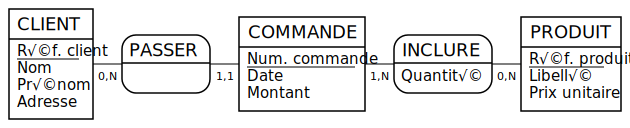

In [322]:
%%mocodo
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

La syntaxe ne devrait pas poser probl√®me¬†:
- une entit√© est d√©finie par¬†:
    -¬†son nom,
    - deux-points,
    - sa liste d'attributs s√©par√©s par des virgules¬†;
- une association est d√©finie par¬†:
    - son nom,
    - virgule,
    - les cardinalit√©s et l'entit√© distingu√©e par sa premi√®re patte,
    - virgule,
    - les cardinalit√©s et l'entit√© de sa deuxi√®me patte,
    - etc.,
    - deux-points,
    - sa liste d'attributs s√©par√©s par des virgules.

√Ä noter¬†:
- le premier attribut d'une entit√© est consid√©r√© par d√©faut comme son identifiant, et donc soulign√©;
- pour les associations sans attributs, le deux-points est facultatif;
- la premi√®re ligne:
        %%mocodo
  ... ne fait pas partie de la description. Dans ce document, elle permet de faire appel √† une ¬´¬†commande magique¬†¬ª, qui lance Mocodo sur les lignes qui la suivent. Sauf sous Jupyter Notebook, vous pouvez l'omettre dans votre texte d'entr√©e.
  De fa√ßon g√©n√©rale, la ou les premi√®res lignes d'un MCD qui commencent par le symbole de pourcentage (`%`) sont ignor√©es. Cela permet de placer en en-t√™te un commentaire qui pourra √™tre pr√©serv√© lors des √©ventuels r√©arrangements ult√©rieurs.
- Les accents pr√©sents dans votre fichier d'entr√©e sont correctement g√©r√©s pourvu que vous ayez enregistr√© celui-ci dans l'encodage attendu par Mocodo en entr√©e: c'est par d√©faut Unicode UTF-8. Une tol√©rance existe: si Mocodo √©choue √† d√©coder votre fichier avec `utf8`, il se rabattra sur le codec d'Europe de l'Ouest associ√© historiquement √† votre plateforme: `iso-8859-15` pour Windows et Linux, `mac-roman` pour macOS. Si les accents n'apparaissent pas correctement, vous aurez encore trois solutions:
  1. soit (fortement conseill√©), r√©-enregistrer votre fichier en UTF-8 au lieu d'un encodage historique;
  3. soit (ponctuellement), passer l'encodage de votre fichier en argument avec `--encodings`;
  2. soit (√† long terme), modifier dans `params.json` la liste des encodages pris en charge.

### D√©pendances fonctionnelles entre entit√©s

Lorsque l'une des cardinalit√©s maximales d'une association binaire est 1 (ou √† d√©faut 0), on d√©signe parfois cette association sous le nom de **d√©pendance fonctionnelle**. Certains auteurs la figurent par un cercle portant le symbole DF¬†: cela leur √©vite de se creuser la t√™te pour trouver un nom √† une association qui dispara√Ætra corps et bien au moment du passage au relationnel. Enfin, une fl√®che peut indiquer le sens de la d√©pendance¬†:

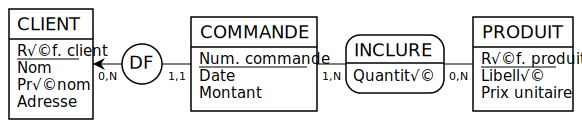

In [14]:
%%mocodo
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
DF, 0N> CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

Si on a plusieurs d√©pendances fonctionnelles √† repr√©senter, on devra suffixer le DF par un chiffre de 0 √† 9 (cf. [cet exemple](#Cr%C3%A9ation-de-plusieurs-entit%C3%A9s-ou-associations-de-m%C3%AAme-nom)).

### Associations r√©flexives

Quelquefois appel√©es **circulaires**, **unaires** ou **r√©cursives**, elles associent une entit√© √† elle-m√™me.

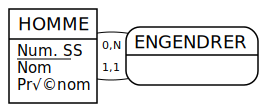

In [15]:
%%mocodo
HOMME: Num. SS, Nom, Pr√©nom
ENGENDRER, 0N HOMME, 11 HOMME

### Placement sur plusieurs rang√©es

Mocodo combine les avantages de l'approche _diagram as code_ (comme PlantUML, Mermaid ou Graphviz), avec la libert√© de positionnement offerte par les logiciels WYSIWYG (_what you see is what you get_).

L'ordre et la s√©paration des lignes de la description permet de sp√©cifier √† co√ªt z√©ro un plongement grossier, mais qui s'av√®re en g√©n√©ral suffisant:

- les bo√Ætes (entit√©s et associations) d√©finies sur des lignes cons√©cutives sont trac√©es sur une m√™me rang√©e;
- un saut de ligne indique une nouvelle rang√©e.

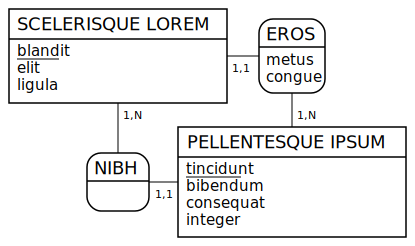

In [16]:
%%mocodo
SCELERISQUE LOREM: blandit, elit, ligula
EROS, 11 SCELERISQUE LOREM, 1N PELLENTESQUE IPSUM: metus, congue

NIBH, 1N SCELERISQUE LOREM, 11 PELLENTESQUE IPSUM
PELLENTESQUE IPSUM: tincidunt, bibendum, consequat, integer

Les bo√Ætes sont plac√©es aux intersections d'une grille invisible assurant que leurs centres soient align√©s aussi bien horizontalement que verticalement. C'est ce qui en g√©n√©ral est le plus satisfaisant esth√©tiquement, mais d'autres retouches peuvent √™tre op√©r√©es manuellement dans le fichier de sortie.

Le plongement fait l'objet d'une ¬´¬†compression¬†¬ª horizontale et verticale. Par exemple, ci-dessus, il y a un espace horizontal n√©gatif entre le bord droit de l'entit√© de gauche et le bord gauche de l'entit√© de droite.

## Besoins plus avanc√©s

### Modifications du texte-source¬†: principes

**Nouveaut√©s de la version 4.0.** L'analyse syntaxique du texte-source d√©crivant un MCD est d√©sormais compl√®tement s√©par√©e de son traitement (fermant ainsi l'[issue 77](https://github.com/laowantong/mocodo/issues/77)).

Une cons√©quence imm√©diate est l'introduction de la coloration syntaxique dans [Mocodo online](https://www.mocodo.net), ainsi que la cr√©ation du plugin [Mocodo syntax highlighter]( https://marketplace.visualstudio.com/items?itemName=laowantong.vscode-mocodo) pour VS-Code.

Ce travail a √©galement permis d'am√©liorer certaines fonctionnalit√©s et d'en cr√©er facilement de nouvelles. Mocodo 4.0 introduit donc la notion de **modification du texte-source**. Elle regroupe toutes les op√©rations qui transforment un MCD syntaxiquement correct en un autre MCD. Par exemple¬†:

- la mise en miroir et le r√©arrangement, qui existaient d√©j√†¬†;
- l'obfuscation d'un MCD, qui se voit accompagn√©e d'une possibilit√© de randomisation des cardinalit√©s¬†;
- l'effacement des attributs ou des cardinalit√©s pour cr√©er des ¬´¬†exercices √† trous¬†¬ª¬†;
- la rectification des cardinalit√©s mal form√©es (qui se fait maintenant √† la demande)¬†;
- l'homog√©n√©isation de la mise en forme (capitalisation, s√©parateurs, diacritiques, ...)¬†;
- la d√©composition d'un MCD donn√© pour n'employer que des DF sans attributs.

#### Pipeline d'op√©rations de modification

Toutes ces op√©rations peuvent maintenant √™tre encha√Æn√©es dans une m√™me commande de modification √† l'aide de la syntaxe suivante¬†:

```
mocodo --modify op1 op2 op3
```

ou en abr√©g√©¬†:

```
mocodo -m op1 op2 op3
```

Par exemple, vous pouvez d√©composer les associations n-aires, convertir les libell√©s des attributs en minuscules et calculer un nouveau plongement d'un seul coup, sans avoir besoin de copier-coller le r√©sultat d'une op√©ration pour le fournir √† la suivante.

Dans les versions pr√©c√©dentes, toutes les op√©rations de modification √©taient terminales. D√©sormais, Mocodo les ex√©cute en premier, puis applique au texte-source r√©sultant toutes les op√©rations restantes (p. ex., trac√© du MCD, conversion en MLD, etc.).

#### Affichage du r√©sultat et persistance

Le post-traitement d√©pend du support d'ex√©cution¬†:

- Sous Jupyter Notebook sont affich√©s en sortie, dans cet ordre, le diagramme conceptuel (sauf avec l'option `--no_mcd`), le diagramme relationnel (avec l'option `--mld`), enfin le nouveau texte-source (sauf avec l'option `--no_text`). Alternativement, l'option `--replace` supprime toutes les sorties, mais met √† jour le contenu de la cellule (contribution de Thomas Giro pour la version 2.0.20).
- Sur le web (Mocodo online), le texte d'entr√©e est mis √† jour.
- En ligne de commande, le fichier d'entr√©e (p. ex., `sandbox.mcd`) est mis √† jour.

#### Exemples

Voici le r√©sultat d'une s√©quence d'op√©rations de modification¬†:

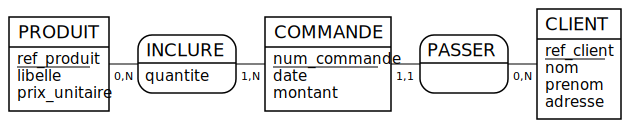

%%mocodo
PRODUIT: ref_produit, libelle, prix_unitaire
INCLURE, 1N COMMANDE, 0N PRODUIT: quantite
COMMANDE: num_commande, date, montant
PASSER, 0N CLIENT, 11 COMMANDE
CLIENT: ref_client, nom, prenom, adresse


In [15]:
%%mocodo -r flip:v labels:ascii,snake
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

Pour tester l'option `--replace`, cr√©ez une cellule avec le texte ci-dessous¬†:

```
%%mocodo --update flip:v labels:ascii,snake --replace
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire
```

Son ex√©cution devrait remplacer son propre contenu par¬†:

```
%%mocodo
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire
```

R√©√©valuez alors ce nouveau contenu pour tracer le MCD r√©sultant, ou annulez la derni√®re op√©ration pour revenir au contenu originel.

Notez que sans argument (ou avec l'argument `echo`), l'option `-m` n'applique aucune modification. Cela peut √™tre utile pour visualiser le texte-source d'un MCD enregistr√© sur le disque¬†:

In [20]:
%mocodo --input sandbox -u --no_mcd

%%mocodo
PRODUIT: ref_produit, libelle, prix_unitaire
INCLURE, 1N COMMANDE, 0N PRODUIT: quantite
COMMANDE: num_commande, date, montant
PASSER, 0N CLIENT, 11 COMMANDE
CLIENT: ref_client, nom, prenom, adresse


### Identifiants composites

Pr√©fixer d'un tiret bas (`_`) les second, troisi√®me, etc. attributs pour les inclure √† l'identifiant.

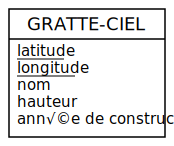

In [21]:
%%mocodo
GRATTE-CIEL: latitude, _longitude, nom, hauteur, ann√©e de construction

### Fl√®ches sur les pattes

Suffixer d'un chevron (`<` ou `>`) les cardinalit√©s de la patte concern√©e. La direction indiqu√©e se lit en partant de l'association et en allant vers l'entit√©.

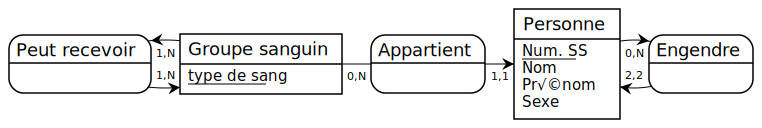

In [22]:
%%mocodo
Peut recevoir, 1N> Groupe sanguin, 1N< Groupe sanguin
Groupe sanguin: type de sang
Appartient, 11> Personne, 0N Groupe sanguin
Personne: Num. SS, Nom, Pr√©nom, Sexe
Engendre, 0N< Personne, 22> Personne

La position de la fl√®che sur la patte peut √™tre r√©gl√©e individuellement dans l'objet `ratio` du fichier de g√©om√©trie g√©n√©r√© (par d√©faut, `sandbox_geo.json`) ou sous l'onglet _Retouches_ de la version en ligne. La valeur correspondante peut varier de `0.0` (fl√®che cach√©e sous la bo√Æte d'origine) √† `1.0` (par d√©faut, pointe de la fl√®che au contact du bord de la bo√Æte de destination, compte non tenu de l'arrondi s'il s'agit d'une association).

### Styles

Plusieurs styles pr√©d√©finis sont distribu√©s avec l'application. Un style se d√©finit comme la combinaison d'une palette de couleurs (r√©pertoire `colors`) avec un dictionnaire de polices et de dimensions (r√©pertoire `shapes`). Un changement d'√©chelle d'un facteur multiplicatif positif peut √™tre pr√©cis√© avec l'argument `--scale`.

Vous pouvez bien s√ªr cr√©er vos propres styles en vous inspirant des fichiers fournis. Si vous √™tes particuli√®rement content d'un style, soumettez-le pour inclusion dans une prochaine distribution.

**Nouveaut√© de la version 3.0.** Une approximation de la largeur des caract√®res des diff√©rentes polices a √©t√© pr√©-calcul√©e sous macOS. Il est possible qu'elle soit inexacte, en particulier sous Windows ou Linux. Dans ce cas, en particulier, les traits de soulignement n'atteindront pas ou exc√©deront la largeur des libell√©s soulign√©s. Vous pouvez contourner le probl√®me en appliquant un facteur multiplicatif avec l'argument `--adjust_width`).

### Ins√©rer les types de donn√©es

Chaque attribut peut √™tre assorti de notes entre crochets. Ignor√©es au niveau du trac√© du MCD, elles sont [interpr√©t√©es comme des types de donn√©es lors de la g√©n√©ration d'un code-source SQL](#Sorties-SQL).

#### Cr√©er un espace r√©serv√© aux types

**Nouveaut√© de la version 4.0.** L'option `-u types:create` ajoute automatiquement des crochets vides √† tous les endroits o√π un type est attendu.

In [24]:
%%mocodo -u types:create --no_mcd
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

%%mocodo
CLIENT: R√©f. client [], Nom [], Pr√©nom [], Adresse []
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande [], Date [], Montant []
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√© []
PRODUIT: R√©f. produit [], Libell√© [], Prix unitaire []


#### Deviner les types √† partir des noms

**Nouveaut√© de la version 4.0.** Avec l'option `-u types:guess` Mocodo essaiera de d√©duire les types manquants des libell√©s des attributs. Les types devin√©s sont pr√©fix√©s d'un point d'interrogation, √† supprimer apr√®s contr√¥le de pertinence.

In [25]:
%%mocodo -u types:guess --no_mcd
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

%%mocodo
CLIENT: R√©f. client [VARCHAR(8)?], Nom [VARCHAR(255)?], Pr√©nom [VARCHAR(255)?], Adresse []
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande [VARCHAR(8)?], Date [DATE?], Montant [DECIMAL(10,2)?]
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√© [INTEGER?]
PRODUIT: R√©f. produit [VARCHAR(8)?], Libell√© [VARCHAR(50)?], Prix unitaire [DECIMAL(10,2)?]


La langue d√©finie avec l'option `--language` est prioritaire, mais l'anglais prend la rel√®ve en cas d'√©chec. 

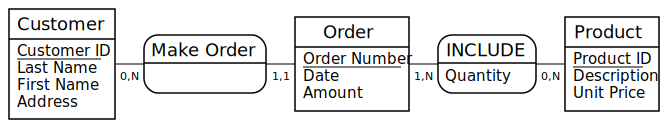

%%mocodo
Customer: Customer ID [VARCHAR(8)?], Last Name [VARCHAR(255)?], First Name [VARCHAR(255)?], Address []
Make Order, 0N Customer, 11 Order
Order: Order Number [], Date [DATE?], Amount [DECIMAL(10,2)?]
INCLUDE, 1N Order, 0N Product: Quantity [INTEGER?]
Product: Product ID [VARCHAR(8)?], Description [TEXT?], Unit Price [DECIMAL(10,2)?]


In [26]:
%%mocodo -u types:guess
Customer: Customer ID, Last Name, First Name, Address
Make Order, 0N Customer, 11 Order
Order: Order Number, Date, Amount
INCLUDE, 1N Order, 0N Product: Quantity
Product: Product ID, Description, Unit Price

La liste des types utilis√©e est [celle-ci](https://en.wikibooks.org/wiki/Structured_Query_Language/Data_Types). Consultez le code-source de [`_types.py`](https://github.com/laowantong/mocodo/blob/master/mocodo/update/_types.py) pour plus de d√©tails, et n'h√©sitez pas √† [ouvrir le d√©bat](https://github.com/laowantong/mocodo/issues/new) si vous avez des corrections ou des suggestions.

### Cardinalit√©s

#### Changer le format des cardinalit√©s

Par d√©faut, les cardinalit√©s sont s√©par√©es par une virgule.

**Nouveaut√© de la version 2.1.** On peut maintenant opter pour un format quelconque¬†:

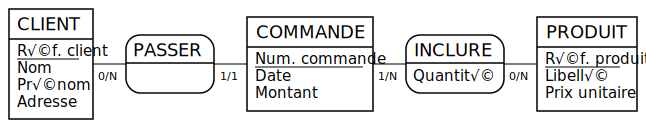

In [27]:
%%mocodo --card_format={min_card}/{max_card}
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

#### Rectifier les cardinalit√©s mal form√©es

L'option `-u cards:fix` corrige les fautes de frappe usuelles (inversion des cardinalit√©s minimale et maximale, lettre ¬´¬†O¬†¬ª au lieu du chiffre ¬´¬†0¬†¬ª) :

| formes erron√©es | forme rectifi√©e |
|:----------------|:----------------|
| `O1`, `o1`, `10`, `1O`, `1o` | `01` |
| `ON`, `oN`, `NO`, `No`, `N0` | `0N` |
| `On`, `on`, `no`, `nO`, `n0` | `0n`|
| `N1` | `1N` |
| `n1` | `1n` |

In [28]:
%%mocodo -u cards:fix --no_mcd
Personne: num. SS, Nom de Famille, Pr√©nom, Sexe
Engendrer, oN [parent] Personne, N0 [enfant] Personne

%%mocodo
Personne: num. SS, Nom de Famille, Pr√©nom, Sexe
Engendrer, 0N [parent] Personne, 0N [enfant] Personne


**NB.** Les cardinalit√©s (N,N), qui selon une certaine √©cole d√©notent une cardinalit√© minimale sup√©rieure √† 1, sont laiss√©es telles quelles.

**Changement de la version 4.0.** Ces modifications ne sont plus appliqu√©es automatiquement mais √† la demande.

### Changer le symbole de d√©pendance fonctionnelle

Il est possible d'activer l'encerclement d'un autre sigle que DF. C'est ce sigle qui devra alors appara√Ætre en entr√©e, par exemple:

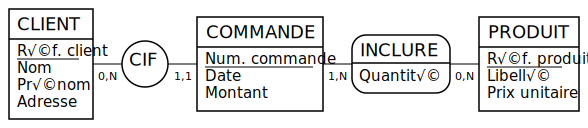

In [29]:
%%mocodo --df=CIF
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
CIF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

Comme le cercle est alors un peu plus grand, on peut vouloir r√©gler (_a priori_ une fois pour toutes) le ratio d√©fini dans l'objet `shapes` du fichier appel√© par d√©faut `sandbox_geo.json`):

```
"df_text_height_ratio" : 1.00,
```

### Cr√©er plusieurs entit√©s ou associations de m√™me nom

Normalement on doit choisir des noms diff√©rents pour toutes les bo√Ætes (entit√©s et associations) du MCD, √† l'exception des associations de d√©pendance fonctionnelle figur√©es par un sigle. On a vu que dans ce cas, il suffisait d'ajouter √† leur nom un chiffre de 0 √† 9¬†: celui-ci n'appara√Ætra pas en sortie.

Cette possibilit√© vaut pour n'importe quelle bo√Æte, y compris les triangles d√©notant l'h√©ritage (p. ex. `/1\` ou `/XT2\`).

Seul le dernier chiffre est concern√©. Cela limite √† 10 le nombre d'entit√©s ou associations homonymes, mais peut √™tre utile si vous avez besoin, pour une raison ou une autre, qu'un suffixe num√©rique apparaisse dans le nom d'une bo√Æte. Il suffit alors d'ajouter encore un chiffre √† celui-ci.

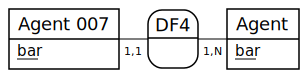

In [438]:
%%mocodo
Agent 0070: bar
DF42, 11 Agent 0070, 1N Agent1
Agent1: bar

La cr√©ation de bo√Ætes homonymes servira typiquement √† ¬´¬†distribuer¬†¬ª une entit√© DATE r√©duite √† son identifiant _date_, mais associ√©e √† de nombreuses entit√©s qui n'ont rien √† voir entre elles. Sachant qu'une telle entit√© est amen√©e √† dispara√Ætre lors du passage au relationnel, il n'y a aucun inconv√©nient √† en cr√©er plusieurs, et cela peut avoir l'avantage de faciliter (ou m√™me de rendre possible) l'obtention d'une bonne mise en page.

Par exemple, la mise en page du MCD suivant est ind√ªment complexifi√©e par le haut degr√© de l'entit√© DATE.

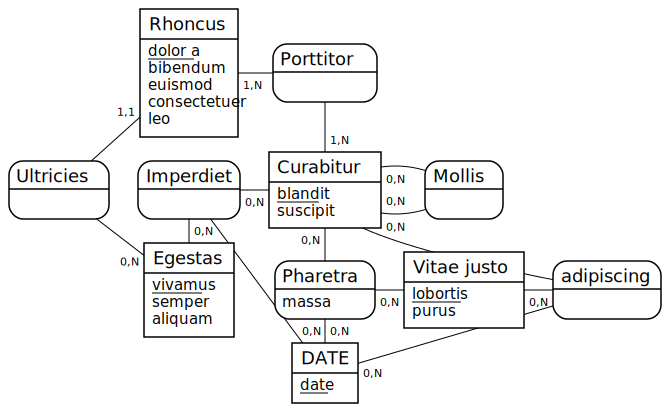

In [31]:
%%mocodo
:
Rhoncus: dolor a, bibendum, euismod, consectetuer, leo
Porttitor, 1N Rhoncus, 1N Curabitur
:
:

Ultricies, 11 Rhoncus, 0N Egestas
Imperdiet, 0N Egestas, 0N Curabitur, 0N DATE
Curabitur: blandit, suscipit
Mollis, 0N Curabitur, 0N Curabitur
:

:
Egestas: vivamus, semper, aliquam
Pharetra, 0N Curabitur, 0N DATE, 0N Vitae justo: massa
Vitae justo: lobortis, purus
adipiscing, 0N Curabitur, 0N Vitae justo, 0N DATE

:
:
DATE: date
:
:

Ajouter une autre entit√© DATE (sous le nom de DATE2) permettra √† Mocodo de calculer une mise en page √† la fois plus agr√©able √† l'≈ìil et plus compacte (√† savoir, $4\times3$ au lieu de $5\times4$). La s√©mantique est inchang√©e.

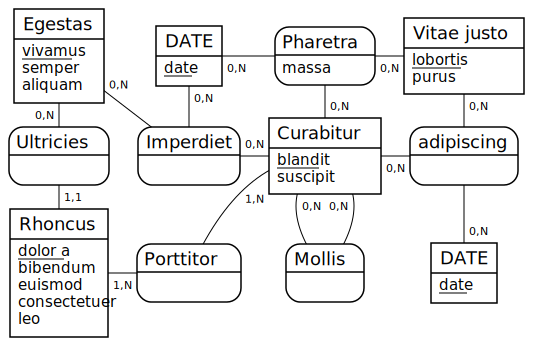

In [32]:
%%mocodo
Egestas: vivamus, semper, aliquam
DATE: date
Pharetra, 0N Curabitur, 0N DATE, 0N Vitae justo: massa
Vitae justo: lobortis, purus

Ultricies, 11 Rhoncus, 0N Egestas
Imperdiet, 0N Egestas, 0N Curabitur, 0N DATE
Curabitur: blandit, suscipit
adipiscing, 0N Curabitur, 0N Vitae justo, 0N DATE2

Rhoncus: dolor a, bibendum, euismod, consectetuer, leo
Porttitor, 1N Rhoncus, 1N Curabitur
Mollis, 0N Curabitur, 0N Curabitur
DATE2: date

### Homog√©n√©iser la mise en forme

Le MCD ci-dessous n'applique aucune r√®gle stricte de capitalisation (¬´¬†Num commande¬†¬ª / ¬´¬†Prix Unitaire¬†¬ª / ¬´¬†date¬†¬ª) ou d'abr√©viation (¬´¬†R√©f. client¬†¬ª / ¬´¬†RefProduit¬†¬ª / ¬´¬†Num commande¬†¬ª).

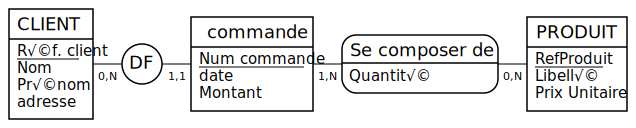

In [33]:
%%mocodo
CLIENT: R√©f. client, Nom, Pr√©nom, adresse
DF, 0N CLIENT, 11 commande
commande: Num commande, date, Montant
Se composer de, 1N commande, 0N PRODUIT: Quantit√©
PRODUIT: RefProduit, Libell√©, Prix Unitaire

Ces petits d√©fauts trahissent peut-√™tre un manque de soin, mais ne nuisent pas √† la compr√©hension du MCD. Par contre, ils risquent de devenir aga√ßants lors de l'√©criture de requ√™tes SQL. S'il n'existe pas de convention universelle pour la pr√©sentation des libell√©s apparaissant dans une base de donn√©es, on s'accorde √† pr√¥ner la coh√©rence des choix de mise en forme. Mocodo 4 peut vous aider √† atteindre cet objectif avec les op√©rations suivantes¬†:

| Nom | Comportement |
|:----|:-------------|
| `ascii` | Suppression des accents et autres diacritiques |
| `camel` | Conversion en [camelCase](https://en.wikipedia.org/wiki/Camel_case) |
| `capitalize` | Conversion de la premi√®re lettre en majuscule et des autres en minuscules ([doc](https://docs.python.org/3/library/stdtypes.html#str.capitalize)) |
| `casefold` | Conversion agressive en minuscules ([doc](https://docs.python.org/3/library/stdtypes.html#str.casefold)) |
| `lower` | Conversion en minuscules ([doc](https://docs.python.org/3/library/stdtypes.html#str.lower)) |
| `snake` | Conversion en [snake_case](https://en.wikipedia.org/wiki/Snake_case) |
| `swapcase` | Conversion des majuscules en minuscules et vice-versa ([doc](https://docs.python.org/3/library/stdtypes.html#str.swapcase)) |
| `title` | Conversion des premi√®res lettres en majuscules et des autres en minuscules ([doc](https://docs.python.org/3/library/stdtypes.html#str.title)) |
| `upper` | Conversion en majuscules ([doc](https://docs.python.org/3/library/stdtypes.html#str.upper)) |

Elles peuvent √™tre appliqu√©es √† n'importe quel [token](https://en.wikipedia.org/wiki/Lexical_analysis#Lexical_token_and_lexical_tokenization) d√©fini dans la [grammaire du langage](https://github.com/laowantong/mocodo/tree/master/mocodo/resources/grammar.lark), notamment¬†:

- `box_name`, le nom d'une entit√© ou d'une association¬†;
- `attr`, le libell√© d'un attribut d'entit√© ou d'association¬†;
- `card`, les deux caract√®res d√©finissant les cardinalit√©s minimale et maximale.

L'application d'une op√©ration `op` √† un token `tk` s'√©crit simplement `op_tk`. Ainsi, la commande suivante passe en majuscules le nom des bo√Ætes et en minuscules leurs attributs¬†:

In [34]:
%%mocodo -u box_name:upper,attr:lower --no_mcd
CLIENT: R√©f. client, Nom, Pr√©nom, adresse
DF, 0N CLIENT, 11 commande
commande: Num commande, date, Montant
Se composer de, 1N commande, 0N PRODUIT: Quantit√©
PRODUIT: RefProduit, Libell√©, Prix Unitaire

Mocodo Err.651 - Unknown update operation: box_name


Les pseudo-tokens suivants peuvent servir de raccourcis¬†:

- `labels` englobe `box_name`, `attr` et `leg_note`¬†;
- `notes` englobe `leg_note` et `constraint_note`.

Par exemple, pour convertir en ASCII et en _snake case_ tous les libell√©s susceptibles d'√™tre ult√©rieurement manipul√©s en SQL¬†:

In [35]:
%%mocodo -u labels:ascii,snake box_name:upper --no_mcd
CLIENT: R√©f. client, Nom, Pr√©nom, adresse
DF, 0N CLIENT, 11 commande
commande: Num commande, date, Montant
Se composer de, 1N commande, 0N PRODUIT: Quantit√©
PRODUIT: RefProduit, Libell√©, Prix Unitaire

Mocodo Err.651 - Unknown update operation: box_name


Notez enfin que, pour la commodit√© de l'utilisateur, si le nom donn√© comme token se termine par un _s_, celui-ci est supprim√©. Il est donc √©quivalent (mais plus intuitif) d'√©crire `lower_box_names` au lieu de `lower_box_name`.

## Extensions du mod√®le

### Entit√©s faibles (ou identification relative)

Pr√©fixer d'un tiret bas (`_`) une cardinalit√© (1,1) pour indiquer que l'entit√© distingu√©e est faible. Dans le diagramme, les identifiants (ou discriminants) d'une telle entit√© seront soulign√©s en pointill√©s, tandis que le (1,1) sera soulign√© d'un trait plein.

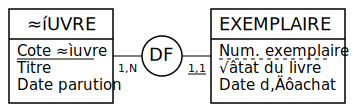

In [25]:
%%mocodo
≈íUVRE: Cote ≈ìuvre, Titre, Date parution
DF, 1N ≈íUVRE, _11 EXEMPLAIRE
EXEMPLAIRE: Num. exemplaire, √âtat du livre, Date d'achat

Une association ne peut renforcer plus d'une entit√© faible. Ainsi, une erreur se produit si l'on remplace le `1N` par `_11`:

In [44]:
%%mocodo
≈íUVRE: Cote ≈ìuvre, Titre, Date parution
DF, _11 ≈íUVRE, _11 EXEMPLAIRE
EXEMPLAIRE: Num. exemplaire, √âtat du livre, Date d'achat

Mocodo Err.22 - Identification relative r√©ciproque autour de ¬´¬†DF¬†¬ª.


**Nouveaut√© de la version 2.1.** Des notations plus traditionnelles de l'identification relative peuvent √™tre obtenues avec l'option `--strengthen_card`:

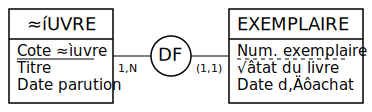

In [47]:
%%mocodo --strengthen_card "(1,1)"
≈íUVRE: Cote ≈ìuvre, Titre, Date parution
DF, 1N ≈íUVRE, _11 EXEMPLAIRE
EXEMPLAIRE: Num. exemplaire, √âtat du livre, Date d'achat

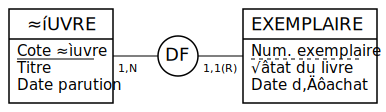

In [48]:
%%mocodo --strengthen_card "1,1(R)"
≈íUVRE: Cote ≈ìuvre, Titre, Date parution
DF, 1N ≈íUVRE, _11 EXEMPLAIRE
EXEMPLAIRE: Num. exemplaire, √âtat du livre, Date d'achat

### Visualisation des contraintes sur les associations

**Nouveaut√© de la version 3.2.** Certains utilisateurs avanc√©s de Mocodo ont besoin d'exprimer au niveau conceptuel les contraintes sur associations introduites par Merise 2. Jusqu'ici, ils devaient utiliser un √©diteur graphique pour ajouter ¬´¬†√† la main¬†¬ª les √©l√©ments correspondants. Ils peuvent dor√©navant le faire sous Mocodo. Attention, la prise en charge de ces extensions est purement visuelle¬†: le passage au niveau relationnel et/ou physique les ignorera.

#### Des ronds

D'un point de vue purement visuel, donc, une telle contrainte est figur√©e par un petit rond portant jusqu'√† trois lettres:

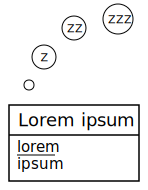

In [49]:
%%mocodo
(): 20, 45
(Z): 30, 30
(ZZ): Lorem ipsum, 15
(ZZZ): 80, 10

:

:
    
:

:

Lorem ipsum: lorem, ipsum

La syntaxe n√©cessite quelques explications.

1. Au contraire des bo√Ætes (entit√©s et associations), les contraintes ne sont pas... contraintes par la grille sous-jacente¬†: la mise en page du MCD n'en tient absolument pas compte. Celui de cet exemple a donc d√ª √™tre ¬´¬†a√©r√©¬†¬ª pour leur faire de la place¬†: ainsi, les quatre paragraphes r√©duits √† un deux-points ont ins√©r√© quatre rang√©es au d√©but de la grille.
2. Chaque membre du couple de ¬´¬†coordonn√©es¬†¬ª qui termine les d√©finitions de contraintes peut √™tre¬†:
  - soit un nombre, qui repr√©sente un pourcentages de la largeur ou de la hauteur du diagramme o√π centrer cette contrainte¬†;
  - soit (nouveaut√© de la version 4.0) un nom de bo√Æte, avec le centre de laquelle aligner horizontalement ou verticalement cette contrainte. Par exemple, la ¬´¬†coordonn√©e¬†¬ª _Lorem Ipsum_ donne √† la contrainte ZZ la m√™me abscisse que la bo√Æte _Lorem ipsum_.
3. De tout cela, il r√©sulte que le positionnement des contraintes est plut√¥t de l'ordre de la retouche¬†: ne vous en occupez pas tant que les bo√Ætes risquent de bouger.
4. Les clauses de d√©finition des contraintes peuvent appara√Ætre n'importe o√π. Notez cependant que tout r√©arrangement automatique les enverra syst√©matiquement √† la fin du texte-source.

De la m√™me mani√®re qu'avec les cardinalit√©s, on peut ins√©rer un court texte entre crochets qui appara√Ætra au survol de la contrainte.

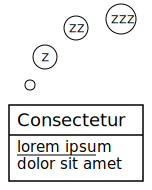

In [50]:
%%mocodo
() [adipiscing elit]: 20, 45
(Z) [sed do eiusmod]: 30, 30
(ZZ) [tempor incididunt] : Consectetur, 15
(ZZZ) [ut labore]: 80, 10

:

:
    
:

:

Consectetur: lorem ipsum, dolor sit amet

#### Des traits

Les contraintes sont normalement li√©es par des traits pleins¬†(`--`) ou pointill√©s (`..`) √† un certain nombre de bo√Ætes (entit√©s ou associations). Une fl√®che (`>` ou `<`) peut √™tre ajout√©e ou substitu√©e √† l'une et/ou l'autre des extr√©mit√©s d'un trait.

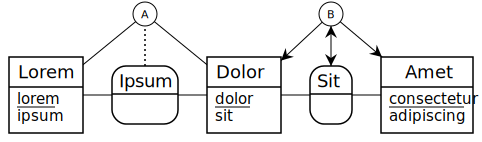

In [51]:
%%mocodo
(A) --Lorem, ..Ipsum, -Dolor: Ipsum, 10
(B) ->Dolor, <-->Sit, -->Amet: Sit, 10

:

:

Lorem: lorem, ipsum
Ipsum, XX Lorem, XX Dolor
Dolor: dolor, sit
Sit, XX Dolor, XX Amet
Amet: consectetur, adipiscing

#### Exemple

Voici un exemple plus r√©aliste, adapt√© de la Fig.¬†7.37 de _Merise, deuxi√®me g√©n√©ration_ (Dominique Nanci et Bernard Espinasse, 4e √©d., 2001)¬†:

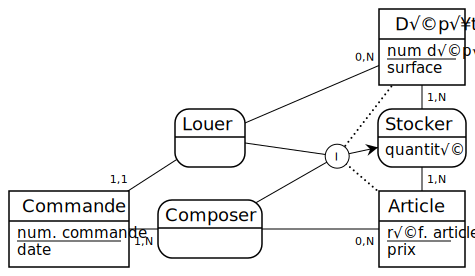

In [52]:
%%mocodo
:::::
D√©p√¥t: num d√©p√¥t, surface

:
Louer, 11 Commande, 0N D√©p√¥t
:::
Stocker, 1N D√©p√¥t, 1N Article: quantit√©

Commande: num. commande, date
Composer, 1N Commande, 0N Article
:::
Article: r√©f. article, prix

(I) ->Stocker, ..D√©p√¥t, ..Article, --Composer, --Louer

Notez que le couple de coordonn√©es est manquant. Dans ce cas, le moteur de plongement fait co√Øncider le centre de chaque contrainte avec le barycentre des bo√Ætes qu'elle met en jeu. Le positionnement ainsi d√©fini a plus de chances de rester correct si le MCD √©volue.

#### Bo√Ætes fictives et traits invisibles

On peut tirer parti de ce m√©canisme en int√©grant (fictivement) d'autres bo√Ætes √† la d√©finition de la contrainte, ou m√™me en en r√©p√©tant certaines. Dans ces deux cas, bien entendu, le trait devra √™tre rendu invisible (il suffit de l'omettre). Par exemple, int√©grer l'entit√© Commande et r√©p√©ter l'association Stocker permet de r√©duire la largeur du MCD sans compromettre sa lisibilit√©. Ci-dessous, on a en outre indent√© la d√©finition de la contrainte pour la placer sur un second calque¬†:

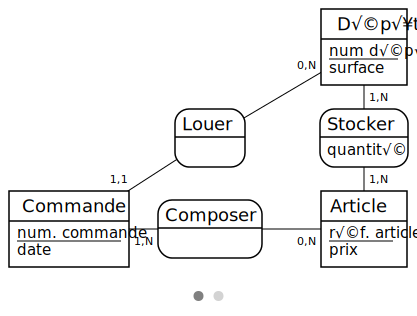

In [53]:
%%mocodo
:::
D√©p√¥t: num d√©p√¥t, surface

:
Louer, 11 Commande, 0N D√©p√¥t
:
Stocker, 1N D√©p√¥t, 1N Article: quantit√©

Commande: num. commande, date
Composer, 1N Commande, 0N Article
:
Article: r√©f. article, prix

  (I) ->Stocker, ..D√©p√¥t, ..Article, --Composer, --Louer, Commande, Stocker

Redisons-le¬†: √† l'heure actuelle (16h36), seul l'aspect graphique des contraintes est implant√©. L'√©ventuel aspect relationnel de certains types de contraintes est d√©j√† pris en charge par Mocodo, mais d'une autre mani√®re. C'est ce que nous allons voir dans les deux sections suivantes.

### Agr√©gation (ou pseudo-entit√©)

#### Probl√©matique

Le MCD ci-dessous a (au moins) un d√©faut¬†:

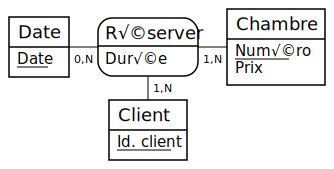

**Chambre** (<ins>Num√©ro</ins>, Prix)<br>
**R√©server** (<ins>Id. client</ins>, <ins>_#Num√©ro_</ins>, <ins>Date</ins>, Dur√©e)


In [52]:
%%mocodo --mld
Date: Date
R√©server, 1N Client, 1N Chambre, 0N Date: Dur√©e
Chambre: Num√©ro, Prix

Client: Id. client

Il n'emp√™che pas les ¬´¬†sur-r√©servations¬†¬ª¬†: deux clients peuvent r√©server la m√™me chambre pour la m√™me nuit. En effet, une r√©servation est identifi√©e par un triplet (date, chambre, client). Plusieurs r√©servations √† la m√™me date, pour la m√™me chambre et avec des clients distincts produisent des identifiants distincts, donc valides.

#### Solution possible¬†: agr√©gation

La notion d'agr√©gation peut ici nous tirer d'affaire. Elle permet d'agr√©ger les entit√©s DATE et CHAMBRE, ainsi que l'association R√âSERVER, en une ¬´¬†pseudo-entit√©¬†¬ª qui sera alors consid√©r√©e comme associ√©e √† l'entit√© CLIENT.

Syntaxiquement, il suffit de pr√©fixer la cardinalit√© de CLIENT d'une barre oblique (avant la version 3, c'est le nom de l'entit√© qui devait √™tre pr√©fix√©)¬†:

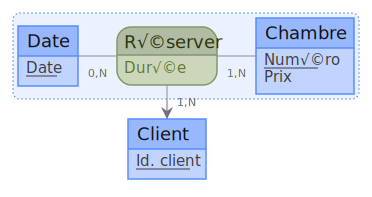

**Chambre** (<ins>Num√©ro</ins>, Prix)<br>
**R√©server** (<ins>_#Num√©ro_</ins>, <ins>Date</ins>, Id. client, Dur√©e)


In [56]:
%%mocodo --mld --colors ocean
Date: Date
R√©server, /1N Client, 1N Chambre, 0N Date: Dur√©e
Chambre: Num√©ro, Prix
    
Client: Id. client

Cette visualisation elle-m√™me est une nouveaut√© de la version 3. Notez que la repr√©sentation traditionnelle demanderait √† ins√©rer une association DF entre CLIENT et R√âSERVER, ce qui donnerait √† peu pr√®s ceci¬†:

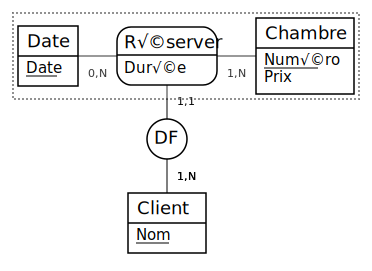

In [56]:
display.SVG("traditional_cluster.svg")

... mais permettre l'association d'une entit√© et d'une association demanderait √† apporter au code de Mocodo des changements cons√©quents, pour un b√©n√©fice qui ne nous saute pas forc√©ment aux yeux.

**Limitation.** La syntaxe choisie ne permet pas de repr√©senter les CIF √† unicit√© incompl√®te.

#### Autre solution : CIF

Cette situation s'exprime √©galement √† l'aide de la notion de contrainte sur associations, et plus pr√©cis√©ment de **contrainte d'int√©grit√© fonctionnelle**. √Ä partir de la version 3.2, on pourra donc choisir d'√©crire¬†:

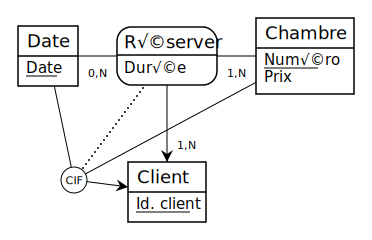

**Chambre** (<ins>Num√©ro</ins>, Prix)<br>
**R√©server** (<ins>_#Num√©ro_</ins>, <ins>Date</ins>, Id. client, Dur√©e)


In [57]:
%%mocodo --mld
Date: Date
R√©server, /1N Client, 1N Chambre, 0N Date: Dur√©e
Chambre: Num√©ro, Prix

:
    
Client: Id. client

(CIF) [M√™me date, m√™me chambre => un seul client] --Chambre, --Date, ->Client, ..R√©server: 20, 75

Lorsque Mocodo rencontre une d√©finition de CIF dans le texte-source, il d√©sactive par politesse sa visualisation des pseudo-entit√©s. Mais c'est toujours le `/1N Client` qui permet d'obtenir le sch√©ma relationnel attendu¬†: pensez √† le mettre.

#### Autre solution¬†: entit√© faible

Notez qu'on peut se passer de la notion d'agr√©gation d√®s lors que l'on a celle d'entit√© faible. Le m√™me MCD pourrait se repr√©senter ainsi¬†:

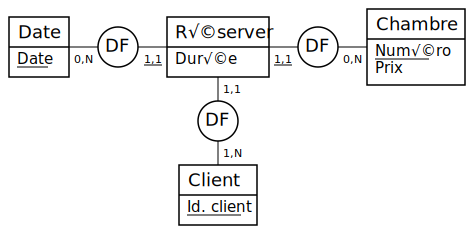

**Chambre** (<ins>Num√©ro</ins>, Prix)<br>
**R√©server** (<ins>_#Num√©ro_</ins>, <ins>Date</ins>, Dur√©e, Id. client)


In [435]:
%%mocodo --mld
Date: Date
DF, 0N Date, _11 R√©server
R√©server: _Dur√©e
DF, 0N Chambre, _11 R√©server
Chambre: Num√©ro, Prix
  
DF, 11 R√©server, 1N Client

Client: Id. client

#### Compl√©ments

Sous Mocodo, l'agr√©gation est trait√©e comme un cas particulier de ce que nous appelons une r√©duction de cl√© primaire. Le m√©canisme est d√©crit [ici](#R%C3%A9duction-de-cl%C3%A9-primaire-(ou-agr%C3%A9gation,-ou-pseudo-entit%C3%A9)).

Rien ne nous emp√™che par exemple de cr√©er un agr√©gat r√©duit √† une seule entit√©¬†:

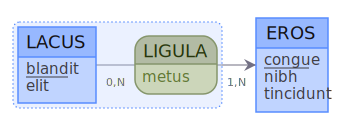

**EROS** (<ins>congue</ins>, nibh, tincidunt)<br>
**LACUS** (<ins>blandit</ins>, elit)<br>
**LIGULA** (<ins>_#blandit_</ins>, _#congue_, metus)


In [60]:
%%mocodo --mld --colors ocean
LACUS: blandit, elit
LIGULA, 0N LACUS, /1N EROS: metus
EROS: congue, nibh, tincidunt

In [78]:
%%mocodo -c chen:layout=circo,mindist=0 defer --shapes=serif --colors=ocean
LACUS: blandit, elit
LIGULA, 0N LACUS, /1N EROS: metus
EROS: congue, nibh, tincidunt

Pour en revenir √† la repr√©sentation graphique¬†:

- Apparaissent en pointill√©s la ou les pattes par lesquelles les identifiants vont migrer **en perdant leur caract√®re identifiant**.
- Une enveloppe de points appara√Æt autour de l'association et des entit√©s de l'agr√©gat dans les cas o√π¬†:
    - il y a au maximum deux entit√©s √† agr√©ger¬†;
    - l'angle form√© par l'association et les entit√©s est plat ou rectangle.

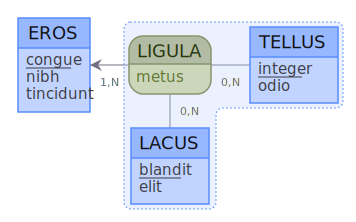

In [61]:
%%mocodo --colors ocean
EROS: congue, nibh, tincidunt
LIGULA, 0N LACUS, /1N EROS, 0N TELLUS: metus
TELLUS: integer, odio

LACUS: blandit, elit

Si ces conditions ne sont pas r√©unies, pour des raisons de simplicit√© du code et de clart√© du diagramme, l'enveloppe n'est pas affich√©e. Cependant, les pointill√©s de la ou des pattes concern√©es subsistent et le reste des traitements est inchang√©.

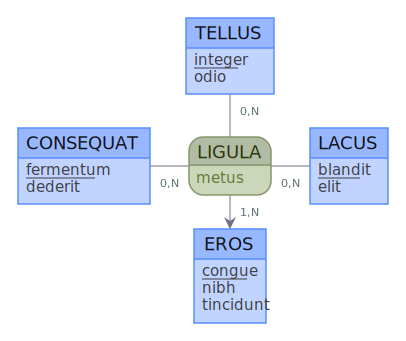

In [62]:
%%mocodo --colors ocean
TELLUS: integer, odio

CONSEQUAT: fermentum, dederit
LIGULA, 0N LACUS, /1N EROS, 0N TELLUS, 0N CONSEQUAT: metus
LACUS: blandit, elit

EROS: congue, nibh, tincidunt

### Conversion forc√©e d'une association DF en table

Normalement, les associations DF disparaissent lors du passage en relationnel. Il est cependant possible de forcer la cr√©ation d'une table √©ponyme. Cela se fait en pr√©fixant d'un + le nom de l'association (avant la version 3, on pr√©fixait d'une barre oblique l'une au moins des entit√©s non distingu√©es par un 01).

Au niveau visualisation, un rectangle en pointill√©s appara√Æt autour de l'association, indiquant que celle-ci va devenir une table.

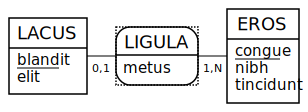

In [81]:
%%mocodo
LACUS: blandit, elit
+LIGULA, 01 LACUS, 1N EROS: metus
EROS: congue, nibh, tincidunt

La motivation et les d√©tails sont discut√©s dans la section [Passage au relationnel / Conversion forc√©e d'une association DF en table](#Conversion-forc√©e-d'une-association-DF-en-table).

### H√©ritage (ou sp√©cialisation)

#### Introduction

L'h√©ritage permet de regrouper dans une entit√©, dite ¬´¬†m√®re¬†¬ª, les attributs communs √† plusieurs autres entit√©s, dites ¬´¬†filles¬†¬ª, qui se distinguent les unes des autres par des attributs sp√©cifiques.

La syntaxe Mocodo est la suivante¬†:
```
/\ M√®re <- Fille_1, Fille_2, ...¬†: type
```
O√π¬†:
- **M√®re** est une entit√© normale¬†;
- _Fille_1_, _Fille_2_, etc. sont des entit√©s **sans identifiant** (inutile de les pr√©fixer par un tiret bas, il serait ignor√©)¬†;
- le ¬´¬†triangle¬†¬ª d√©finit le type d'h√©ritage, soit `/\`,  soit `/X\`, soit `/T\`, soit `/XT\`. **Nouveaut√© de la version 4.0**¬†: s'il y a plusieurs triangles de m√™me type, le suffixe num√©rique permettant de les distinguer est devenu facultatif¬†;
- la ¬´¬†fl√®che¬†¬ª d√©finit le m√©canisme de passage au relationnel, soit `<=`, soit `<-`, soit `->`, soit `=>`. Reportez-vous √† cette [section](#S%C3%A9mantique-de-la-fl%C3%A8che)¬†;
- le type (facultatif) n'appara√Æt pas sur le MCD, mais √©ventuellement, lors du passage au relationnel, dans la liste des champs de la table-m√®re ou, en cas de suppression de celle-ci, des tables dans lesquelles migre son identifiant. Il permet de pr√©ciser √† laquelle des entit√©s-filles on a affaire.

Voici un exemple¬†:

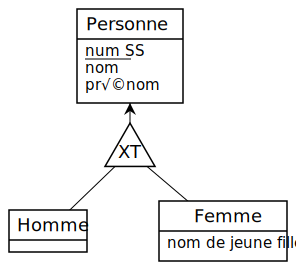

In [66]:
%%mocodo
Personne: num SS, nom, pr√©nom

/XT\ Personne <- Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

#### Les quatre types d'h√©ritage

Selon les symboles inscrits dans le triangle, le MCD pr√©c√©dent s'interpr√©tera ainsi¬†:

| Totalit√© | Exclusion | Symboles | Exemple de population | Toute personne est¬†: |
|----------|-----------|:------:-:|:---------:|:--------|
| oui        | oui         | `/XT\`  | <big>‚ôÇ‚ôÇ‚ôÇ‚ôÇ‚ôÇ‚ôÇ‚ôÇ<br>‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ</big> | - soit un homme<br>- soit une femme |
| non        | oui         | `/X\`   | <big>‚ôÇ‚ôÇ‚ôÇ‚ôÇ‚ôÇ‚ôÇ‚ôÇ‚ôÇ<br>‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ<br>‚ö¨‚ö¨‚ö¨‚ö¨</big> | - soit un homme<br>- soit une femme<br>- soit aucun des deux |
| oui        | non         | `/T\`   | <big>‚ôÇ‚ôÇ‚ôÇ‚ôÇ‚ôÇ‚ôÇ<br>‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ<br>‚ö•‚ö•‚ö•‚ö•</big> | - soit un homme<br>- soit une femme<br>- soit les deux √† la fois |
| non        | non         | `/\`    | <big>‚ôÇ‚ôÇ‚ôÇ‚ôÇ‚ôÇ<br>‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ‚ôÄ<br>‚ö¨‚ö¨‚ö¨‚ö¨<br>‚ö•‚ö•‚ö•‚ö•</big> | - soit un homme<br>- soit une femme<br>- soit aucun des deux<br>- soit les deux √† la fois |

Ces contraintes ne sont pas transposables au niveau relationnel, mais pourront √™tre r√©inject√©es au niveau physique (m√™me si Mocodo ne le fait pas actuellement).

#### Repr√©sentation graphique

Le type de fl√®che sp√©cifiant le m√©canisme de passage au mod√®le relationnel (`<=`, `<-`, `->` ou `=>`) fait par d√©faut l'objet d'une visualisation d√®s le mod√®le conceptuel¬†: la ou les pattes vers les entit√©s de destination des attributs migrants sont orient√©es vers celles-ci¬†; et la ou les autres pattes sont doubl√©es (pour `<=` et `=>`) ou non (pour `<-` et `->`).

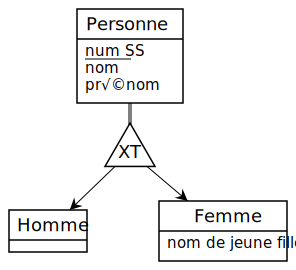

In [67]:
%%mocodo --mld
Personne: num SS, nom, pr√©nom

/XT\ Personne => Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

Cette visualisation n'est pas conventionnelle¬†: par d√©faut, on se borne √† ajouter une fl√®che dirig√©e vers l'entit√©-m√®re. Pour d√©sactiver l'embellissement op√©r√© par Mocodo, sans pour autant changer le m√©canisme de passage au relationnel, prolongez simplement d'un caract√®re la fl√®che¬†: `<==`, `<--`, `-->` ou `==>`.

**NB.** Cette syntaxe est une nouveaut√© de Mocodo 4.0. Dans la version 3, c'√©tait `->>` et `=>>` au lieu de `-->` ou `==>` (respectivement).

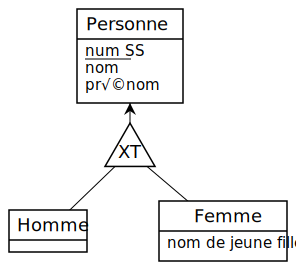

In [69]:
%%mocodo --mld
Personne: num SS, nom, pr√©nom

/XT\ Personne ==> Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

### Identifiants alternatifs

--gutter id:show=auto,strong=ID,weak=id,alts=123456789 type:show=off

--left_gutter {on,off,auto}
                        show the status of candidate identifiers in each
                        entity (default: auto)
  --left_gutter_strong_id STR
                        string to be used in the left gutter for strong
                        identifiers (default: ID)
  --left_gutter_weak_id STR
                        string to be used in the left gutter for weak
                        identifiers (default: id)
  --left_gutter_alt_ids STR [STR ...]
                        strings to be used in the left gutter for alt
                        identifiers (default: ['1', '2', '3', '4', '5', '6',
                        '7', '8', '9'])

#### D√©finition et syntaxe

**Nouveaut√© de la version 4.0.** On appelle **identifiant candidat** d'une entit√© tout sous-ensemble minimal d'attributs dont chaque occurrence est unique. Parmi ces sous-ensembles, l'un est √©lu **identifiant** (tout court), soulign√©, et appel√© √† devenir cl√© primaire lors du passage au relationnel. Les candidats malheureux sont appel√©s **identifiants alternatifs**.

Ainsi, dans l'exemple ci-dessus (propos√© par Fabien Duchateau), l'ensemble des identifiants candidats de CLIENT est constitu√© de¬†:

- l'identifiant proprement dit _R√©f. client_¬†;
- l'identifiant alternatif (_Nom_, _Pr√©nom_) (dont on supposera pour simplifier qu'il assure l'unicit√©)¬†;
- l'identifiant alternatif _Mail_.

(Nous changeons de police de caract√®res pour distinguer plus facilement les 1 des l.)

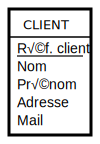

In [70]:
%%mocodo --shapes arial
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse, Mail

Mocodo permet de d√©finir, de visualiser et de traiter jusqu'√† 10 identifiants candidats par entit√©. On note `i_nom_attribut` tout attribut appartenant au i√®me candidat, avec `i` un chiffre de `0` √† `9` (le `0`, en g√©n√©ral facultatif, repr√©sente l'identifiant tout court). Sur l'exemple pr√©c√©dent¬†:

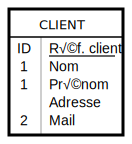

In [75]:
%%mocodo --shapes arial
CLIENT: R√©f. client, 1_Nom, 1_Pr√©nom, Adresse, 2_Mail

Par d√©faut, d√®s la premi√®re d√©claration d'un identifiant alternatif, Mocodo fait appara√Ætre une goutti√®re √† gauche des attributs de **toutes** les entit√©s. Y sont report√©s¬†:

- un symbole ¬´¬†ID¬†¬ª (resp. ¬´¬†id¬†¬ª) pour l'identifiant fort (resp. faible). Notez que ce symbole est redondant avec le soulignement plein (resp. pointill√©) de cet identifiant¬†;
- des chiffres de 1 √† 9 correspondant aux num√©ros des identifiants alternatifs.

On verra que la notion d'identifiant alternatif se traduit par des [contraintes d'unicit√© au niveau physique](#Traitement-des-identifiants-alternatifs).

#### Identifiants alternatifs non disjoints

Si certains attributs sont communs √† plusieurs identifiants alternatifs, concat√©nez simplement les num√©ros de ces identifiants, par exemple¬†:

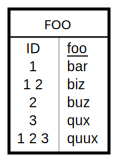

In [58]:
%%mocodo --shapes arial
FOO: foo, 1_bar, 12_biz, 2_buz, 3_qux, 123_quux

Ici, le premier identifiant alternatif est le triplet (_bar_, _biz_, _quux_), le second (_biz_, _buz_, _quux_) et le troisi√®me (_qux_, _quux_).

#### Explicitation de l'identifiant √† souligner

Ce cas peut se produire lorsque l'identifiant √† souligner a un attribut commun avec un identifiant alternatif. Ce dernier devant √™tre distinct et minimal, cela implique que l'identifiant est composite. Le cas est donc exceptionnel, mais doit √™tre pr√©vu.

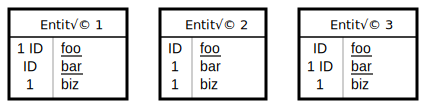

In [74]:
%%mocodo --shapes arial
Entit√© 10: 1_foo, _bar, 1_biz
Entit√© 20: foo, 1_bar, 1_biz
Entit√© 30: foo, 01_bar, 1_biz

- Si l'attribut commun est en t√™te de liste (ici, _foo_, entit√©¬†1), rien ne change, on √©crit `1_foo`.
- S'il n'est pas en t√™te de liste (ici, _bar_, entit√©¬†2), l'√©criture `1_bar` d√©note d√©j√† l'appartenance √† un identifiant alternatif. Elle ne peut d√©noter simult√©nement l'appartenance √† l'identifiant √† souligner.
- C'est pourquoi on doit donc expliciter l'appartenance √† l'identifiant √† souligner qui, comme on l'a vu, est num√©rot√© `0` (entit√© 3).

L'autre cas qui demande r√©flexion est encore plus exotique. C'est un sous-cas de celui o√π le premier attribut ne fait pas partie de l'identifiant √† souligner (entit√© 4). Si l'on veut alors que ce premier attribut appartienne √† une cl√© alternative, il faut expliciter le `0` (entit√© 5).

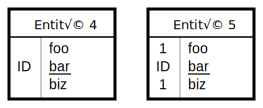

In [60]:
%%mocodo --shapes arial --gutters ids:visibility=on
Entit√© 40: _foo, _bar, biz
Entit√© 50: 01_foo, _bar, 1_biz

En r√©sum√©, on explicite le `0`, soit pour **emp√™cher le soulignement du premier attribut**, soit pour **forcer le soulignement d'un attribut suivant**.

Cela devrait vous rappeler quelque chose‚Ä¶ Remplacez `0` par `_` dans la phrase pr√©c√©dente et vous retrouverez la r√®gle que vous avez appris √† conna√Ætre et √† aimer¬†: on explicite le `_`, soit pour emp√™cher le soulignement du premier attribut, soit pour forcer le soulignement d'un attribut suivant.

#### Sous-sous-options de visualisation

La goutti√®re d'identifiants appara√Æt automatiquement (`visibility=auto`) d√®s qu'il y a au moins un identifiant alternatif. Il est possible de ne pas le faire (`visibility=off`)¬†:

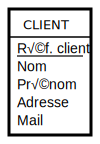

In [61]:
%%mocodo --gutters ids:visibility=off --shapes arial
CLIENT: R√©f. client, 1_Nom, 1_Pr√©nom, Adresse, 2_Mail

... ou au contraire de la forcer (`visibility=on`)¬†quand elle est superf√©tatoire¬†:

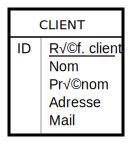

In [63]:
%%mocodo --gutters ids:visibility=on --shapes arial
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse, Mail

Vous pouvez aussi pr√©ciser quelles cha√Ænes d√©noteront un identifiant fort (par d√©faut, `strong=ID`), un identifiant faible (par d√©faut, `weak=id`) ainsi que les num√©ros des groupes d'identifiants alternatifs (par d√©faut, `alts=123456789`)¬†:

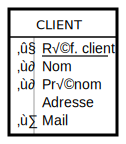

In [71]:
%%mocodo --gutters ids:strong=‚û§,alts=‚ù∂‚ù∑ --shapes arial
CLIENT: R√©f. client, 1_Nom, 1_Pr√©nom, Adresse, 2_Mail

## Besoins sp√©cifiques √† la p√©dagogie

Si vous n'√™tes pas enseignant de bases de donn√©es, [t√©l√©portez-vous directement √† la section suivante](#Trac%C3%A9-d'un-MCD).

### SVG interactifs

#### Afficher l'explication des cardinalit√©s

Les d√©butants ont souvent des doutes sur la s√©mantique de telle ou telle cardinalit√©. Cette information peut √™tre incluse dans le texte-source, en annotant les pattes correspondantes, pour appara√Ætre √† la demande lors du rendu (utile pour cr√©er des exercices √† faire en TD ou en autonomie).

Survolez les cardinalit√©s du MCD ci-dessous pour faire appara√Ætre leur description.

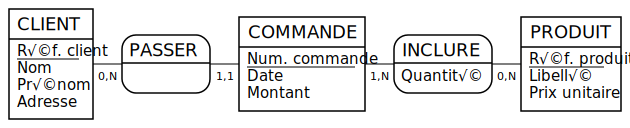

In [79]:
%%mocodo
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N [Un client peut passer un nombre quelconque de commandes.] CLIENT, 11 [Toute commande est pass√©e par un en un seul client.] COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N [Une commande peut inclure plusieurs produits distincts, et en inclut au moins un.] COMMANDE, 0N [Certains produits ne sont jamais command√©s, d'autres le sont plusieurs fois.] PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

Les notes s'ins√®rent entre cardinalit√©s et nom de l'entit√©. Elles sont d√©limit√©es par des crochets droits.

Avec l'option `--disambiguation=notes` (par d√©faut), elles sont √©galement exploitables lors du passage au relationnel pour [pr√©ciser la s√©mantique d'une cl√© √©trang√®re](#R%C3%A9tablissement-explicite-de-la-s%C3%A9mantique-des-DF-disparues).

L'affichage au survol peut √™tre d√©sactiv√© avec l'option `--hide_notes`.

**Limitations.**

- Non pris en charge par les √©diteurs de SVG comme Inkscape.
- Ne semble pas fonctionner dans une page HTML statique (comme la version HTML de ce document sous GitHub).
- N√©cessite de faire confiance √† un notebook (Trust notebook) pour s'afficher √† la r√©ouverture.

#### D√©voiler un MCD par √©tapes

**Nouveaut√© de la version 3.** Il est possible de faire appara√Ætre progressivement les diff√©rentes ¬´¬†bo√Ætes¬†¬ª constituant un MCD. Pour cela, il suffit d'indenter (d√©caler vers la droite √† l'aide d'espaces ou de tabulations) au moins une ligne. Les √©l√©ments correspondants seront alors r√©partis sur autant de ¬´¬†calques¬†¬ª qu'il y a de niveaux d'indentations.

Voici par exemple un exercice consistant en la description du ¬´¬†r√©el per√ßu¬†¬ª d'une entreprise de VPC¬†:

> 1. Un produit est connu par une r√©f√©rence, un libell√© et un prix unitaire.
> 1. Toute commande inclut un produit ou plusieurs, chacun en une certaine quantit√©.
> 1. Un client peut passer z√©ro (_client potentiel_) ou plusieurs commandes.
> 1. Un client peut entrer dans la base par parrainage d'un autre client.

L'enseignant peut le pr√©senter pas √† pas en suivant les √©tapes de l'√©nonc√©¬†:

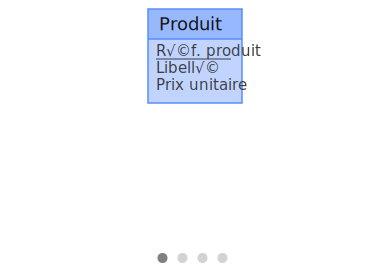

In [80]:
%%mocodo  --colors ocean --shapes copperplate

      Parrainer, 01 Client, 0N Client¬†: date parrainage
Produit: R√©f. produit, Libell√©, Prix unitaire
  Inclure, 1N Commande, 0N Produit: Quantit√©
 
    Client: R√©f. client, Nom, Pr√©nom, Adresse
    DF, 0N Client, 11 Commande
  Commande: Num. commande, Date, Montant

**Remarques.**
- Pas de r√®gle sur la taille de l'indentation. Pour Mocodo, autant de niveaux d'indentation distincts, autant de calques.
- Pour ajouter facilement de l'interactivit√© √† un MCD existant¬†:
    1. commencez par indenter au maximum toutes les lignes¬†;
    1. effacez l'indentation des lignes du premier calque¬†;
    1. d√©calez votre curseur de $n$ caract√®res vers la droite¬†;
    1. placez-vous tour √† tour sur les lignes √† int√©grer au deuxi√®me calque et effacez les espaces surnum√©raires¬†;
    1. recommencez √† l'√©tape 3 jusqu'au dernier calque.
    
  Depuis la version 4.0, l'√©diteur de Mocodo online vous permet de cr√©er des curseurs multiples, ce qui simplifie encore ces op√©rations.
- Les diff√©rents calques sont cod√©s directement dans le SVG. L'interaction ne n√©cessite donc aucun logiciel sp√©cifique.
- Sous Mocodo online, le MCD est toujours pr√©sent√© enti√®rement d√©voil√©. Cela permet de voir directement le r√©sultat d'une modification du texte-source.

**Limitations actuelles.**
- Pas de granularit√© plus fine que la ligne (entit√© ou association avec toutes ses pattes et cardinalit√©s).
- Pas de prise en charge des touches directionnelles. Cela serait sans doute possible, mais difficilement compatible avec la pr√©sence de plusieurs MCD interactifs sur une m√™me page (comme dans cette documentation).

#### √âviter qu'une interaction sur un SVG ne s'applique √† un autre

**Nouveaut√© de la version 3.1.1.** Dans un cas tr√®s rare, √† savoir lorsque plusieurs SVG interactifs g√©n√©r√©s √† partir du m√™me texte-source coexistent sur une m√™me page web (ou dans le m√™me notebook), une interaction op√©r√©e sur l'un s'applique √©galement √† tous les autres. Par exemple, cliquer sur l'un des ronds gris de l'une des figures ci-dessous agira sur les deux figures¬†:

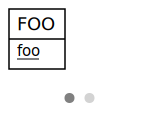

In [81]:
%%mocodo
FOO: foo
  BAR: bar

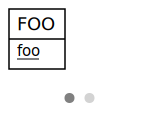

In [82]:
%%mocodo
FOO: foo
  BAR: bar

Ce probl√®me trahit une ¬´¬†collision¬†¬ª¬†: diff√©rents √©l√©ments du [DOM](https://fr.wikipedia.org/wiki/Document_Object_Model) se sont vus attribuer la m√™me empreinte (obtenue par hachage du texte-source). La solution est de passer un entier discriminant qui, par concat√©nation, fera de ces empreintes de v√©ritables identifiants.

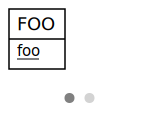

In [83]:
%%mocodo --uid_suffix 1
FOO: foo
  BAR: bar

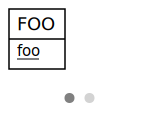

In [48]:
%%mocodo --uid_suffix 2
FOO: foo
  BAR: bar

### Cr√©er un MCD √† compl√©ter

Les MCD √† trous sont des exercices classiques d'introduction aux bases de donn√©es.

#### Supprimer le marquage d'un identifiant

Pour √©viter le marquage automatique du premier attribut d'une entit√© comme identifiant, il suffit de le pr√©fixer par un tiret bas (`_`)¬†: ce caract√®re est donc un commutateur, qui souligne un attribut non soulign√© par d√©faut, et d√©souligne un attribut soulign√© par d√©faut.

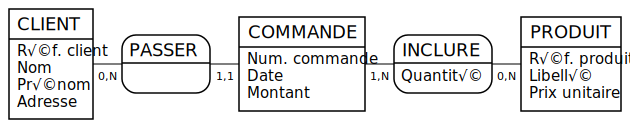

In [84]:
%%mocodo
CLIENT: _R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: _Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: _R√©f. produit, Libell√©, Prix unitaire

#### Masquer un couple de cardinalit√©s

Vous pouvez masquer n'importe quelles cardinalit√©s en les rempla√ßant pas `XX` (ci-dessous √† gauche) ou (nouveaut√© de la version 3.2) en les pr√©fixant d'un `-` (ci-dessous √† droite).

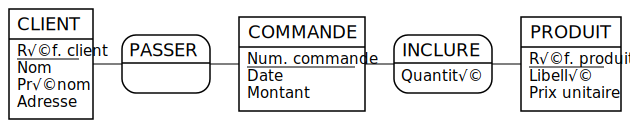

In [85]:
%%mocodo
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, XX CLIENT, XX COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, -1N COMMANDE, -0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

**Nouveaut√© de la version 4.0.** Si la cardinalit√© comporte un et un seul `X`, l'autre caract√®re sera affich√© tout seul.

**Nouveaut√© de la version 4.0.** Utilisez `-u cards:delete` pour effacer d'un coup toutes les cardinalit√©s¬†:

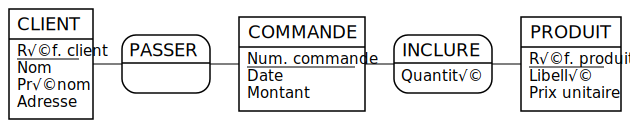

%%mocodo
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, XX CLIENT, XX COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, XX COMMANDE, XX PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire


In [8]:
%%mocodo -u cards:delete
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

#### Masquer un attribut

Vous pouvez mettre deux virgules cons√©cutives pour r√©server la place d'un attribut manquant.

Les espaces ins√©cables sont pr√©serv√©s, ce qui permet de r√©server plus d'espace horizontal, cf. ci-dessous premier attribut vide de INCLURE.

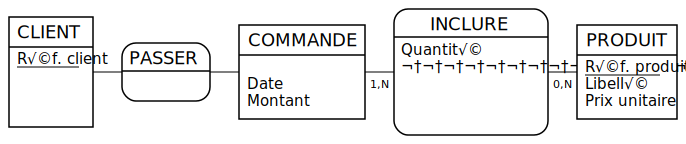

In [51]:
%%mocodo
CLIENT: R√©f. client, , , 
PASSER, XX CLIENT, XX COMMANDE
COMMANDE: , Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©, ¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬† , , ,
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

**Nouveaut√© de la version 4.0.** Utilisez `-r attrs:delete` pour effacer d'un coup tous les attributs¬†:

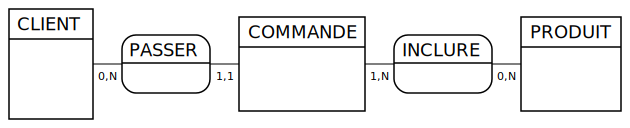

%%mocodo
CLIENT: , , , 
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: , , 
INCLURE, 1N COMMANDE, 0N PRODUIT: 
PRODUIT: , ,


In [111]:
%%mocodo -r attrs:delete
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

#### Ne faire appara√Ætre que le squelette du sch√©ma conceptuel

Enfin, vous pouvez transformer en exercice √† trous n'importe quel MCD en rendant compl√®tement transparentes les couleurs des attributs, associations et cardinalit√©s. Le style `blank` a √©t√© pr√©d√©fini √† cet effet:

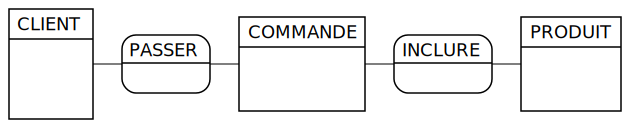

In [9]:
%%mocodo --colors=blank
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

Attention, n'utilisez pas cette m√©thode si vous souhaitez diffuser l'exercice sous forme √©lectronique: l'information textuelle est toujours pr√©sente, susceptible d'√™tre s√©lectionn√©e et coll√©e ailleurs pour √™tre lue. Vous pouvez bien s√ªr emp√™cher cette possibilit√© en convertissant la figure dans un format bitmap (comme PNG); mais le plus simple est de combiner les deux m√©thodes pr√©c√©dentes:

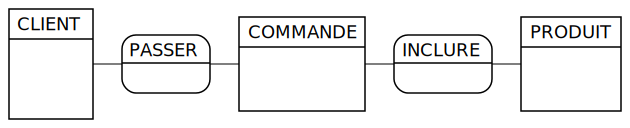

%%mocodo
CLIENT: , , , 
PASSER, XX CLIENT, XX COMMANDE
COMMANDE: , , 
INCLURE, XX COMMANDE, XX PRODUIT: 
PRODUIT: , ,


In [11]:
%%mocodo -u cards:del attrs:del
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

### Cr√©er un MCD al√©atoire √† partir d'un autre

#### Remplacer les libell√©s par du faux-texte (obfuscation)

L'obfuscation d'un MCD consiste √† vider celui-ci de sa s√©mantique de surface, en substituant des cha√Ænes al√©atoires √† tous les libell√©s. Le r√©sultat sera par exemple utilis√© pour montrer que les principales r√®gles de passage du sch√©ma conceptuel au sch√©ma relationnel peuvent √™tre appliqu√©es ¬´¬†b√™tement¬†¬ª, c'est-√†-dire sans comprendre le fonctionnement de l'organisme mod√©lis√©.

Ainsi, dans l'exemple ci-dessous, l'option `-u labels:obfuscate` remplace les libell√©s du MCD _CLIENT-COMMANDE-PRODUIT_ par des mots tir√©s au hasard:

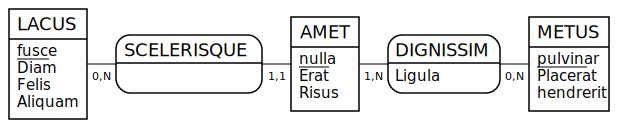

%%mocodo
LACUS: fusce, Diam, Felis, Aliquam
SCELERISQUE, 0N LACUS, 11 AMET
AMET: nulla, Erat, Risus
DIGNISSIM, 1N AMET, 0N METUS: Ligula
METUS: pulvinar, Placerat, hendrerit


In [112]:
%%mocodo -r labels:obfuscate --seed=1
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

En argument, vous pouvez ajouter le chemin d'un fichier texte UTF-8 quelconque o√π puiser les mots de substitution. Par exemple, le texte du `README` de ce projet:

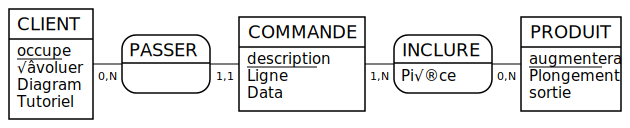

%%mocodo
CLIENT: occupe, √âvoluer, Diagram, Tutoriel
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: description, Ligne, Data
INCLURE, 1N COMMANDE, 0N PRODUIT: Pi√®ce
PRODUIT: augmentera, Plongement, sortie


In [113]:
%%mocodo -r attrs:obfuscate=../README.md --seed=42
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

Mocodo essaie d'abord de trouver ce fichier √† l'endroit indiqu√©. En cas d'√©chec, il le cherche (avec extension `.txt` facultative) parmi les textes distribu√©s avec le logiciel, √† savoir:

- `"lorem_ipsum.txt"`: le [faux-texte](https://fr.wikipedia.org/wiki/Faux-texte) le plus courant.
- `"disparition.txt"`: le lexique du [c√©l√®bre roman lipogrammatique](https://fr.wikipedia.org/wiki/La_Disparition_&#40;roman&#41;) de Georges Perec.
- `"four_letter_words.txt"`: une s√©lection (SFW) de mots anglais de quatre lettres.

En cas de nouvel √©chec, il se rabat sur `"lorem_ipsum.txt"`.

Notez enfin que l'algorithme s'assure que la [distance de Damerau-Levenshtein](https://fr.wikipedia.org/wiki/Distance_de_Damerau-Levenshtein) entre deux libell√©s de substitution quelconques est d'au moins 3 (valeur par d√©faut du param√®tre `obfuscation_min_distance`). En clair, cela signifie que, si vous donnez en examen un exercice de conversion en relationnel bas√© sur un tel MCD, les erreurs de transcription d'un √©tudiant stress√©, inattentif, illettr√©, dyslexique, roublard, ou tout cela √† la fois, ne devraient pas vous emp√™cher de lui octroyer les points qu'il m√©rite.

**Nouveaut√©s de la version 3.**
- L'option `--obfuscation_max_length` est supprim√©e¬†; inversement, la taille minimale d'un mot de substitution est fix√©e (en dur) √† 3.
- L'option `--seed` fonctionne quelle que soit la version de Python.

**Nouveaut√© de la version 4.0.**
L'obfuscation est plac√©e sous le chapeau de diverses autres op√©rations de modification. Ce qui s'√©crivait¬†:

```
mocodo --obfuscate=four_letter_words
```

s'√©crit maintenant (plus lourdement, il faut en convenir)¬†:

```
mocodo -r labels:obfuscate=four_letter_words
```

#### Randomiser les cardinalit√©s

**Nouveaut√© de la version 4.0.** On peut aller plus loin dans l'obfuscation en rempa√ßant toutes les cardinalit√©s par d'autres tir√©es au hasard (`-r cards:randomize`).

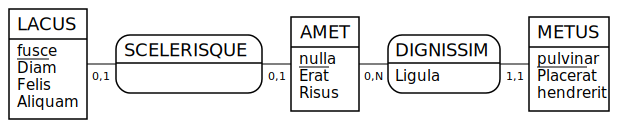

%%mocodo
LACUS: fusce, Diam, Felis, Aliquam
SCELERISQUE, 01 LACUS, 01 AMET
AMET: nulla, Erat, Risus
DIGNISSIM, 0N AMET, 11 METUS: Ligula
METUS: pulvinar, Placerat, hendrerit


In [114]:
%%mocodo -r cards:randomize --seed=42
LACUS: fusce, Diam, Felis, Aliquam
SCELERISQUE, 0N LACUS, 11 AMET
AMET: nulla, Erat, Risus
DIGNISSIM, 1N AMET, 0N METUS: Ligula
METUS: pulvinar, Placerat, hendrerit

Le MCD r√©sultant satisfait aux propri√©t√©s suivantes¬†:

1. Il comporte approximativement la m√™me proportion de cardinalit√©s `_11` (d√©notant une entit√© faible) que le MCD original, ou aucune si ce dernier n'en comportait pas.
2. Idem pour les cardinalit√©s `/1N` ou `/0N` (d√©notant une agr√©gation).
3. Toute association comporte au plus une cardinalit√© `11`.
4. Toute association not√©e DF comporte exactement une cardinalit√© `11`.

**Limitation.** Si le MCD original comportait au moins une entit√© faible, la randomisation des cardinalit√©s peut r√©sulter en un MCD invalide (l'absence de cycles d'entit√©s faibles n'est pas garantie).

### Cr√©er un MCD n'employant que des DF √©l√©mentaires

**Nouveaut√© de la version 4.0.** Aussi surprenant que cela puisse para√Ætre, tout MCD peut √™tre transform√© en un MCD √©quivalent dont les seules associations sont des d√©pendances fonctionnelles binaires non porteuses d'attributs, telles que celle ci-dessous¬†:

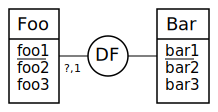

In [104]:
%%mocodo
Foo: foo1, foo2, foo3
DF, ?1 Foo, XX Bar
Bar: bar1, bar2, bar3

La transformation n√©cessite trois op√©rations de modification √©l√©mentaires que Mocodo appelle _drain_, _split_ et _explode_, et que nous allons d√©couvrir dans les sous-sections suivantes.

#### Vider les DF de leurs attributs

Mettre des attributs dans les associations 11 est souvent consid√©r√© comme une anomalie.

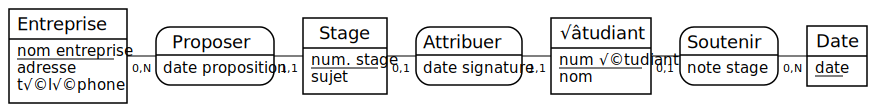

**Entreprise** (<ins>nom entreprise</ins>, adresse, t√©l√©phone)<br>
**Stage** (<ins>num. stage</ins>, sujet, _#nom entreprise_, date proposition)<br>
**√âtudiant** (<ins>num √©tudiant</ins>, nom, _#num. stage_, date signature, date, note stage)


In [116]:
%%mocodo --mld
Entreprise: nom entreprise, adresse, t√©l√©phone
Proposer, 0N Entreprise, 11 Stage: date proposition
Stage: num. stage, sujet
Attribuer, 11 √âtudiant, 01 Stage: date signature
√âtudiant: num √©tudiant, nom
Soutenir, 01 √âtudiant, 0N Date: note stage
Date: date

Mocodo peut les d√©placer dans les entit√©s distingu√©es par les cardinalit√©s 11. Nous appelons cette op√©ration de modification un ¬´¬†drainage de d√©pendances fonctionnelles¬†¬ª (option `-r drain`). Notez bien que ces deux MCD sont strictement √©quivalents, et produisent le m√™me MLD.

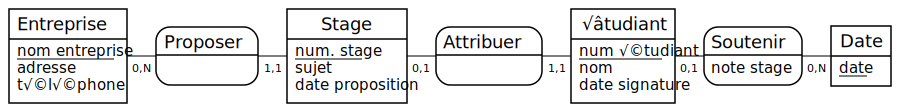

**Entreprise** (<ins>nom entreprise</ins>, adresse, t√©l√©phone)<br>
**Stage** (<ins>num. stage</ins>, sujet, date proposition, _#nom entreprise_)<br>
**√âtudiant** (<ins>num √©tudiant</ins>, nom, date signature, _#num. stage_, date, note stage)


%%mocodo
Entreprise: nom entreprise, adresse, t√©l√©phone
Proposer, 0N Entreprise, 11 Stage
Stage: num. stage, sujet, date proposition
Attribuer, 11 √âtudiant, 01 Stage
√âtudiant: num √©tudiant, nom, date signature
Soutenir, 01 √âtudiant, 0N Date: note stage
Date: date


In [117]:
%%mocodo --mld -r drain
Entreprise: nom entreprise, adresse, t√©l√©phone
Proposer, 0N Entreprise, 11 Stage: date proposition
Stage: num. stage, sujet
Attribuer, 11 √âtudiant, 01 Stage: date signature
√âtudiant: num √©tudiant, nom
Soutenir, 01 √âtudiant, 0N Date: note stage
Date: date

La premi√®re version peut √™tre pr√©f√©r√©e pour des raisons de localit√© s√©mantique (_date proposition_ dans PROPOSER), ou honnie parce qu'elle complique la d√©finition d'identifiant d'association. Mocodo n'a pas d'opinion sur la question. Par contre, il se refuse √† proc√©der au drainage _via_ les cardinalit√©s 01. Dans le MCD ci-dessus, le placement de _note stage_ dans SOUTENIR indique qu'un √©tudiant peut ne pas se voir attribuer de note de stage¬†; si elle √©tait mise dans √âTUDIANT, la connaissance du fait que ce champ autorise la valeur `NULL` serait perdue.

TODO: implanter le champ nullable en SQL.

#### D√©composer les DF n-aires

De m√™me, d'aucuns regardent de travers les d√©pendances fonctionnelles d'arit√© $n$ sup√©rieure √† 2¬†:

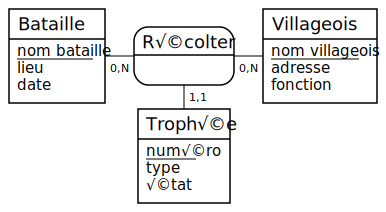

**Bataille** (<ins>nom bataille</ins>, lieu, date)<br>
**Troph√©e** (<ins>num√©ro</ins>, type, √©tat, _#nom villageois_, _#nom bataille_)<br>
**Villageois** (<ins>nom villageois</ins>, adresse, fonction)


In [119]:
%%mocodo --mld
Bataille: nom bataille, lieu, date
R√©colter, 0N Villageois, 0N Bataille, 11 Troph√©e
Villageois: nom villageois, adresse, fonction

Troph√©e: num√©ro, type, √©tat

Toute DF de ce type peut √™tre ¬´¬†fendue¬†¬ª en $n-1$ DF. L'option `-m split` g√©n√®re un MCD √©quivalent¬†:

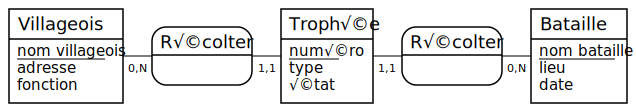

**Bataille** (<ins>nom bataille</ins>, lieu, date)<br>
**Troph√©e** (<ins>num√©ro</ins>, type, √©tat, _#nom villageois_, _#nom bataille_)<br>
**Villageois** (<ins>nom villageois</ins>, adresse, fonction)


In [122]:
%%mocodo --mld -r split quiet arrange:grid=10x1 --seed=9
Bataille: nom bataille, lieu, date
R√©colter, 0N Villageois, 0N Bataille, 11 Troph√©e
Villageois: nom villageois, adresse, fonction

Troph√©e: num√©ro, type, √©tat

#### D√©composer les associations n-aires non DF

Toute association non DF d'arit√© $n$ peut √™tre d√©compos√©e en un ensemble de $n$ associations DF¬†: elle-m√™me se voit alors remplac√©e par une entit√© li√©e aux $n$ entit√©s originales. Cette nouvelle entit√© est appel√©e ¬´¬†entit√©-intersection¬†¬ª, ¬´¬†entit√©-associative¬†¬ª ou ¬´¬†Gerund¬†¬ª (Song, Il-Yeol & Evans, Mary & Park, Eui Kyun. _A Comparative Analysis of Entity-Relationship Diagrams_. Journal of Computer and Software Engineering. 3 (1995)). Dans les cours de [Laurent Audibert](https://laurent-audibert.developpez.com/Cours-BD/?page=conception-des-bases-de-donnees-modele-a#L2-3-3-b) ou de [Patrick Bergougnoux](https://gestion.pumbo.fr/boutique/livre/modelisation-conceptuelle-de-donnees), l'op√©ration est illustr√©e √† l'aide du MCD suivant¬†:

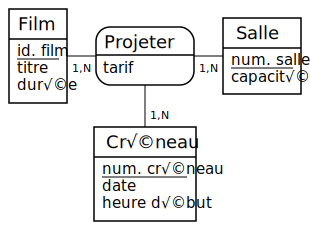

**Cr√©neau** (<ins>num. cr√©neau</ins>, date, heure d√©but)<br>
**Film** (<ins>id. film</ins>, titre, dur√©e)<br>
**Projeter** (<ins>_#num. salle_</ins>, <ins>_#num. cr√©neau_</ins>, <ins>_#id. film_</ins>, tarif)<br>
**Salle** (<ins>num. salle</ins>, capacit√©)


In [123]:
%%mocodo --mld
Film: id. film, titre, dur√©e
Projeter, 1N Salle, 1N Cr√©neau, 1N Film: tarif
Salle: num. salle, capacit√©

Cr√©neau: num. cr√©neau, date, heure d√©but

La d√©composition est invoqu√©e par l'option `-r explode`¬†:

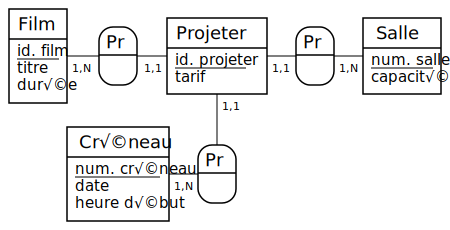

**Cr√©neau** (<ins>num. cr√©neau</ins>, date, heure d√©but)<br>
**Film** (<ins>id. film</ins>, titre, dur√©e)<br>
**Projeter** (<ins>id. projeter</ins>, tarif, _#id. film_, _#num. salle_, _#num. cr√©neau_)<br>
**Salle** (<ins>num. salle</ins>, capacit√©)


%%mocodo
Film: id. film, titre, dur√©e
Pr3, 11 Projeter, 1N Film
Projeter: id. projeter, tarif
Pr1, 11 Projeter, 1N Salle
Salle: num. salle, capacit√©

:
Cr√©neau: num. cr√©neau, date, heure d√©but
Pr2, 11 Projeter, 1N Cr√©neau
:
:


In [148]:
%mocodo --input sandbox --mld -r explode arrange:grid=5x2 --seed=21

En fait, le nouveau MCD a vocation √† √™tre retouch√© pour se rapprocher du plongement initial et avoir des noms plus appropri√©s aux nouveaux identifiant, entit√© et associations cr√©√©s, par exemple¬†:

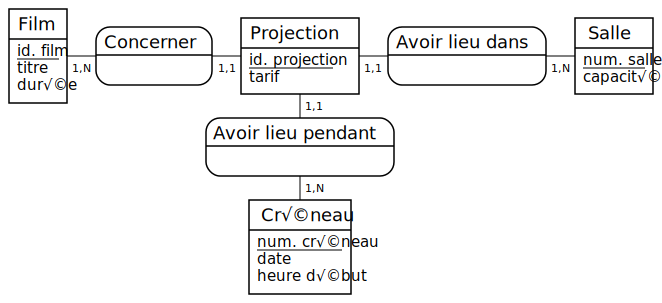

**Cr√©neau** (<ins>num. cr√©neau</ins>, date, heure d√©but)<br>
**Film** (<ins>id. film</ins>, titre, dur√©e)<br>
**Projection** (<ins>id. projection</ins>, tarif, _#id. film_, _#num. salle_, _#num. cr√©neau_)<br>
**Salle** (<ins>num. salle</ins>, capacit√©)


In [150]:
%%mocodo --mld
Film: id. film, titre, dur√©e
Concerner, 11 Projection, 1N Film
Projection: id. projection, tarif
Avoir lieu dans, 11 Projection, 1N Salle
Salle: num. salle, capacit√©

Avoir lieu pendant, 11 Projection, 1N Cr√©neau

Cr√©neau: num. cr√©neau, date, heure d√©but

#### D√©composer les associations binaires non DF

Consid√©rons le MCD suivant, qui comporte deux associations binaires non DF, l'une porteuse d'attribut, l'autre non¬†:

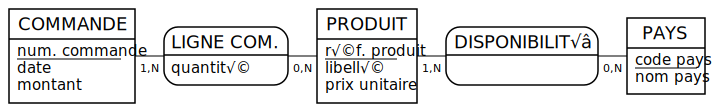

**COMMANDE** (<ins>num. commande</ins>, date, montant)<br>
**DISPONIBILIT√â** (<ins>_#r√©f. produit_</ins>, <ins>_#code pays_</ins>)<br>
**LIGNE COM.** (<ins>_#num. commande_</ins>, <ins>_#r√©f. produit_</ins>, quantit√©)<br>
**PAYS** (<ins>code pays</ins>, nom pays)<br>
**PRODUIT** (<ins>r√©f. produit</ins>, libell√©, prix unitaire)


In [158]:
%%mocodo --mld
COMMANDE: num. commande, date, montant
LIGNE COM., 1N COMMANDE, 0N PRODUIT: quantit√©
PRODUIT: r√©f. produit, libell√©, prix unitaire
DISPONIBILIT√â, 1N PRODUIT, 0N PAYS
PAYS: code pays, nom pays

Par souci de concision, quand on parle d'associations $n$-aires dans ce document, c'est par opposition aux associations binaires¬†; mais bien s√ªr, la r√®gle de d√©composition √©nonc√©e √† la section pr√©c√©dente est √©galement valable pour $n=2$, m√™me si par d√©faut elle ne s'applique qu'aux associations d'arit√© minimale 3. En r√©duisant la valeur de `arity` √† 2, toutes les associations binaires non DF seront √©galement d√©compos√©es¬†:

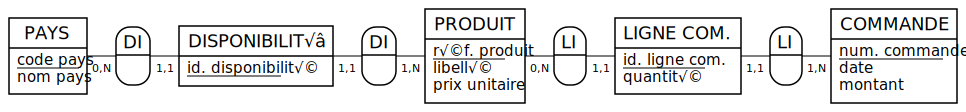

**COMMANDE** (<ins>num. commande</ins>, date, montant)<br>
**DISPONIBILIT√â** (<ins>id. disponibilit√©</ins>, _#code pays_, _#r√©f. produit_)<br>
**LIGNE COM.** (<ins>id. ligne com.</ins>, quantit√©, _#r√©f. produit_, _#num. commande_)<br>
**PAYS** (<ins>code pays</ins>, nom pays)<br>
**PRODUIT** (<ins>r√©f. produit</ins>, libell√©, prix unitaire)


In [159]:
%mocodo --mld --input=mocodo_notebook/sandbox.mcd -r explode:arity=2 quiet arrange:grid=10x1 --seed=1

Cette d√©composition devient un peu extr√™me¬†! Vous pouvez conserver certaines associations binaires non DF, √† savoir celles qui ne portent aucun attribut, en mettant `arity` √† `2.5` (√† lire comme ¬´¬†interm√©diaire entre `2` et `3`¬†¬ª)¬†:

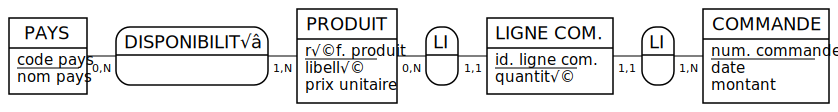

**COMMANDE** (<ins>num. commande</ins>, date, montant)<br>
**DISPONIBILIT√â** (<ins>_#r√©f. produit_</ins>, <ins>_#code pays_</ins>)<br>
**LIGNE COM.** (<ins>id. ligne com.</ins>, quantit√©, _#r√©f. produit_, _#num. commande_)<br>
**PAYS** (<ins>code pays</ins>, nom pays)<br>
**PRODUIT** (<ins>r√©f. produit</ins>, libell√©, prix unitaire)


In [161]:
%mocodo --mld --input=mocodo_notebook/sandbox.mcd -r explode:arity=2.5 quiet arrange:grid=10x1 --seed=1

#### D√©composer en cr√©ant des entit√©s faibles

Ci-dessus, le processus de modification a cr√©√© un identifiant _id. ligne com._ qui peut sembler superf√©tatoire. Si l'on a introduit la notion d'entit√© faible, on aura ici avantage √† utiliser l'option `weak`¬†:

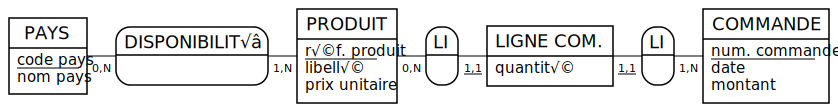

**COMMANDE** (<ins>num. commande</ins>, date, montant)<br>
**DISPONIBILIT√â** (<ins>_#r√©f. produit_</ins>, <ins>_#code pays_</ins>)<br>
**LIGNE COM.** (<ins>_#num. commande_</ins>, <ins>_#r√©f. produit_</ins>, quantit√©)<br>
**PAYS** (<ins>code pays</ins>, nom pays)<br>
**PRODUIT** (<ins>r√©f. produit</ins>, libell√©, prix unitaire)


In [162]:
%mocodo --mld --input=mocodo_notebook/sandbox.mcd -r explode:arity=2.5,weak quiet arrange:grid=10x1 --seed=1

**Cas des pseudo-entit√©s.** Comme on l'a vu plus haut, la notion d'entit√© faible permet de se passer de celle d'agr√©gation (TODO: c'est faux). Ainsi, le MCD ci-dessous¬†:

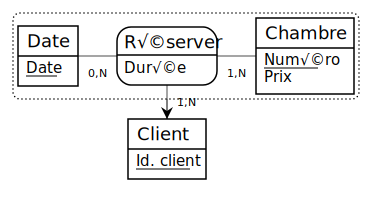

**Chambre** (<ins>Num√©ro</ins>, Prix)<br>
**R√©server** (<ins>_#Num√©ro_</ins>, <ins>Date</ins>, Id. client, Dur√©e)


In [164]:
%%mocodo --mld
Date: Date
R√©server, /1N Client, 1N Chambre, 0N Date: Dur√©e
Chambre: Num√©ro, Prix

Client: Id. client

... se verra d√©compos√© de la m√™me fa√ßon que sans agr√©gation, √† ceci pr√®s que la patte distingu√©e par le `"/"` produira une cardinalit√© `11` au lieu d'une cardinalit√© `_11`¬†:

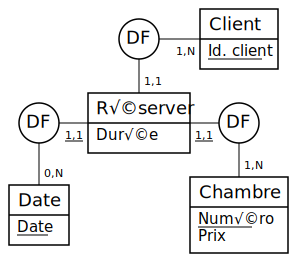

**Chambre** (<ins>Num√©ro</ins>, Prix)<br>
**R√©server** (<ins>_#Num√©ro_</ins>, <ins>Date</ins>, Dur√©e, Id. client)


In [419]:
%%mocodo -r explode:weak quiet arrange --seed 11 --mld
Date: Date
R√©server, /1N Client, 1N Chambre, 0N Date: Dur√©e
Chambre: Num√©ro, Prix

Client: Id. client

#### Simplifier le r√©sultat de la d√©composition

Cette d√©composition pourra quelquefois √™tre am√©lior√©e manuellement. Reprenons l'exemple non modifi√© des r√©servations de chambre¬†:

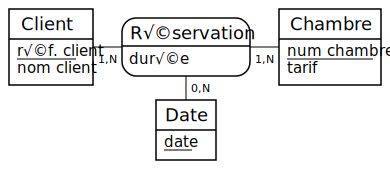

In [193]:
%%mocodo
Client: r√©f. client, nom client
R√©servation, 1N Client, 1N Chambre, 0N Date: dur√©e
Chambre: num chambre, tarif

Date: date

La d√©composition automatique produit¬†:

In [194]:
%mocodo --input sandbox --mld -r explode arrange:grid=10x2 flip:h,v quiet --seed 10

Traceback (most recent call last):
  File "/Users/aristide/opt/anaconda3/bin/mocodo", line 8, in <module>
    sys.exit(main())
  File "/Users/aristide/Dropbox/Sites/mocodo/mocodo/__main__.py", line 272, in main
    run = Runner()
  File "/Users/aristide/Dropbox/Sites/mocodo/mocodo/__main__.py", line 40, in __init__
    self.params = parsed_arguments()
  File "/Users/aristide/Dropbox/Sites/mocodo/mocodo/argument_parser.py", line 208, in parsed_arguments
    raise MocodoError(2, _('The file "{input}" doesn\'t exist.').format(input=args.input))  # fmt: skip
mocodo.mocodo_error.MocodoError: Mocodo Err.2 - Le fichier ¬´¬†sandbox.mcd¬†¬ª n'existe pas.


En anticipant sur le passage au relationnel, on remarque que l'entit√© DATE est [ind√©pendante et r√©duite √† sa cl√© primaire](#Suppression-des-tables-ind√©pendantes-r√©duites-√†-leur-cl√©-primaire)¬†: on peut donc la supprimer, apr√®s avoir pris soin de d√©placer dans R√âSERVATION son unique attribut.

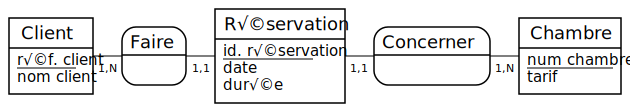

In [158]:
%%mocodo
Client: r√©f. client, nom client
Faire, 11 R√©servation, 1N Client
R√©servation: id. r√©servation, date, dur√©e
Concerner, 11 R√©servation, 1N Chambre
Chambre: num chambre, tarif

Cette simplification s'applique √©galement √† la variante avec cr√©ation d'entit√©s faibles¬†:

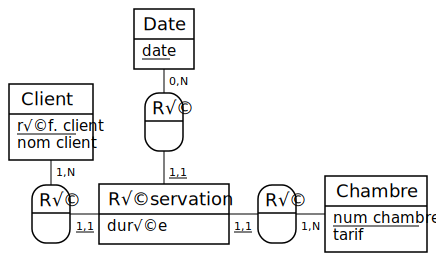

In [189]:
%%mocodo -r explode:weak quiet arrange --seed 19
Client: r√©f. client, nom client
R√©servation, 1N Client, 1N Chambre, 0N Date: dur√©e
Chambre: num chambre, tarif

Date: date

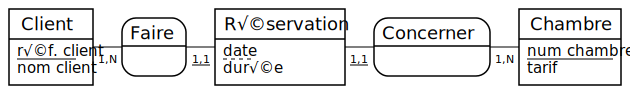

**Chambre** (<ins>num chambre</ins>, tarif)<br>
**Client** (<ins>r√©f. client</ins>, nom client)<br>
**R√©servation** (<ins>_#num chambre_</ins>, <ins>_#r√©f. client_</ins>, <ins>date</ins>, dur√©e)


In [190]:
%%mocodo --mld
Client: r√©f. client, nom client
Faire, _11 R√©servation, 1N Client
R√©servation: date, dur√©e
Concerner, _11 R√©servation, 1N Chambre
Chambre: num chambre, tarif

#### Conclusion sur ces d√©compositions

Comme l'indique le nom que nous leur avons malicieusement attribu√©, certaines de ces d√©compositions peuvent litt√©ralement faire _exploser_ la taille du MCD. Cependant¬†:

- elles sont int√©ressantes d'un point de vue <s>terroriste</s> th√©orique¬†;
- elles peuvent permettre la d√©tection d'erreurs de conception¬†;
- elles peuvent conduire √† des am√©liorations fines du MCD (c'est ce qu'on vient de faire sur celui des r√©servations de chambre)¬†;
- elles d√©crivent le MCD dans un langage volontairement appauvri, ce qui le rendra plus ais√©ment portable dans une autre notation, comme UML ou _crow's foot_.

### Cr√©er une vue en extension

La [technique de duplication](#Cr%C3%A9ation-de-plusieurs-entit%C3%A9s-ou-associations-de-m%C3%AAme-nom) vue plus haut peut servir √† produire une vue en extension d'un MCD. Voici par exemple le MCD que j'utilise en cours pour introduire la notion d'entit√© faible (√† gauche, vue en compr√©hension, √† droite vue en extension):

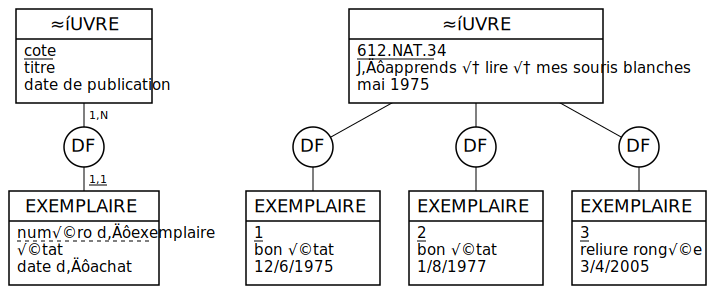

In [434]:
%%mocodo
≈íUVRE1: cote, titre, date de publication
:::
≈íUVRE2: 612.NAT.34, J'apprends √† lire √† mes souris blanches, mai 1975
:
  
DF, 1N ≈íUVRE1, _11 EXEMPLAIRE1
::
DF, XX ≈íUVRE2, XX EXEMPLAIRE2
DF, XX ≈íUVRE2, XX EXEMPLAIRE3
DF, XX ≈íUVRE2, XX EXEMPLAIRE4

EXEMPLAIRE1: num√©ro d'exemplaire, √©tat, date d'achat
::
EXEMPLAIRE2: 1, bon √©tat, 12/6/1975
EXEMPLAIRE3: 2, bon √©tat, 1/8/1977
EXEMPLAIRE4: 3, reliure rong√©e, 3/4/2005

Mocodo n'interdit pas la conversion en relationnel d'un tel MCD, mais celle-ci n'a aucun sens.

**Nouveaut√© de la version 3.2.** Pour pr√©server la s√©mantique des cardinalit√©s sans les afficher, il est maintenant possible de les pr√©fixer d'un `-` (¬´¬†moins¬†¬ª). Le r√©sultat de la conversion en relationnel peut alors √™tre interpr√©t√© comme l'ensemble des lignes des diff√©rentes tables.

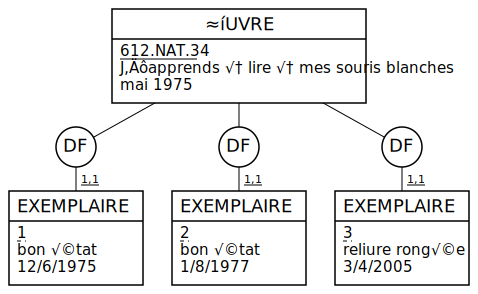

**EXEMPLAIRE1** (<ins>_#612.NAT.34_</ins>, <ins>1</ins>, bon √©tat, 12/6/1975)<br>
**EXEMPLAIRE2** (<ins>_#612.NAT.34_</ins>, <ins>2</ins>, bon √©tat, 1/8/1977)<br>
**EXEMPLAIRE3** (<ins>_#612.NAT.34_</ins>, <ins>3</ins>, reliure rong√©e, 3/4/2005)<br>
**≈íUVRE** (<ins>612.NAT.34</ins>, J'apprends √† lire √† mes souris blanches, mai 1975)


In [433]:
%%mocodo --mld
≈íUVRE: 612.NAT.34, J'apprends √† lire √† mes souris blanches, mai 1975
  
DF, -1N ≈íUVRE, -_11 EXEMPLAIRE1
DF, -1N ≈íUVRE, -_11 EXEMPLAIRE2
DF, -1N ≈íUVRE, -_11 EXEMPLAIRE3

EXEMPLAIRE1: 1, bon √©tat, 12/6/1975
EXEMPLAIRE2: 2, bon √©tat, 1/8/1977
EXEMPLAIRE3: 3, reliure rong√©e, 3/4/2005

# Trac√© d'un MCD

## Interdiction des chevauchements

Les d√©butants ne comprennent pas toujours du premier coup que l'ordre des lignes du texte-source correspond √† celui des bo√Ætes du MCD affich√©¬†; ou qu'il faut sauter une ligne chaque fois que l'on veut une nouvelle rang√©e de bo√Ætes. Ces malheureux se retrouvent donc plus souvent qu'√† leur tour avec des chevauchements pas forc√©ment faciles √† voir¬†:

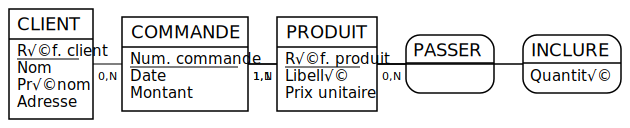

In [27]:
%%mocodo
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
COMMANDE: Num. commande, Date, Montant
PRODUIT: R√©f. produit, Libell√©, Prix unitaire
PASSER, 0N CLIENT, 11 COMMANDE
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©

Ci-dessus, par exemple, l'association INCLURE, qui devrait se trouver entre CLIENT et COMMANDE, est d√©port√©e de telle sorte que ses pattes chevauchent COMMANDE, PRODUIT et PASSER, ‚Äî ce qui ne se voit pas vraiment puisque les entit√©s et associations sont trac√©es **apr√®s** les pattes.

**Nouveaut√© de la version 3.0.** Mocodo peut lever une erreur dans une telle situation. L'option correspondante, `--detect_overlaps` est par d√©faut activ√©e sous Mocodo online, et d√©sactiv√©e en ligne de commande.

Si vous rencontrez une telle erreur, vous pouvez¬†:
    
- Modifier manuellement l'ordre des lignes du texte-source et/ou ins√©rer des sauts de ligne.
- [R√©arranger automatiquement](#R√©arrangement-automatique) le MCD (en cliquant üîÄ sous Mocodo online, ou avec l'option `-m arrange` en ligne de commande).
- Ignorer le probl√®me en d√©sactivant la d√©tection des chevauchements (sous l'onglet ¬´¬†Options¬†¬ª de Mocodo online).

**Remarques.**

- Les calculs sont op√©r√©s, non pas √† partir des coordonn√©es r√©elles des bo√Ætes, mais de leurs indices $(i, j)$ dans la matrice correspondant √† la grille qui sert de base au plongement. Les √©ventuelles [retouches](#Retouches-fines) apport√©es √† la position de leurs centres sont ignor√©es.
- Seuls les chevauchements mettant en jeu des pattes horizontales ou verticales sont d√©tect√©s. Par exemple, ci-dessous, le chevauchement sera ignor√©.

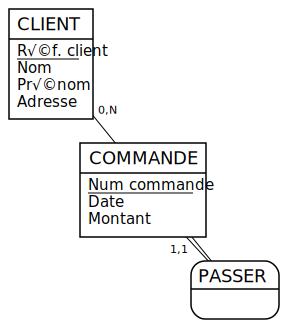

In [59]:
%%mocodo
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
::

:
COMMANDE: Num. commande, Date, Montant
:

::
PASSER, 0N CLIENT, 11 COMMANDE

## Insertion manuelle d'espacements

Le trac√© r√©alis√© par Mocodo pour des MCD de plusieurs rang√©es laisse parfois √† d√©sirer¬†:

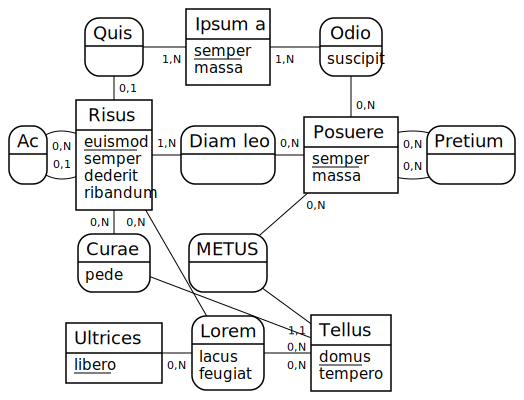

In [28]:
%%mocodo
Quis, 01 Risus, 1N Ipsum a
Ipsum a: semper, massa
Odio, 1N Ipsum a, 0N Posuere: suscipit

Ac, 01 Risus, 0N Risus
Risus: euismod, semper, dederit, ribandum
Diam leo, 1N Risus, 0N Posuere
Posuere: semper, massa
Pretium, 0N Posuere, 0N Posuere

Curae, 0N Risus, 0N Tellus: pede
METUS, 11 Tellus, 0N Posuere

Ultrices: libero
Lorem, 0N Ultrices, 0N Tellus, 0N Risus: lacus, feugiat
Tellus: domus, tempero

On voit que, par d√©faut, Mocodo centre les rang√©es qui contiennent moins de bo√Ætes que les autres. Cela donne un bon r√©sultat pour la premi√®re rang√©e, mais pas pour la troisi√®me.

L'utilisateur peut cependant sp√©cifier les espacements qu'il d√©sire en compl√©tant les rang√©es par des bo√Ætes invisibles dont le seul r√¥le est de ¬´¬†pousser ¬ª les autres √† l'emplacement voulu. Ainsi, il va pr√©ciser que l'association _Curae_ doit commencer sur la troisi√®me colonne en ins√©rant des lignes r√©duites au caract√®re deux-points, et en profiter pour ins√©rer un espace entre _Lorem_ et _Tellus_¬†:

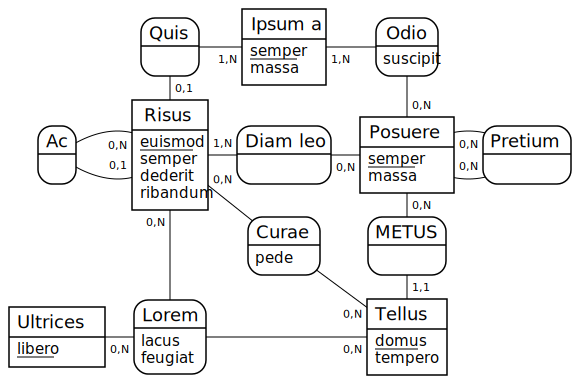

In [29]:
%%mocodo
Quis, 01 Risus, 1N Ipsum a
Ipsum a: semper, massa
Odio, 1N Ipsum a, 0N Posuere: suscipit

Ac, 01 Risus, 0N Risus
Risus: euismod, semper, dederit, ribandum
Diam leo, 1N Risus, 0N Posuere
Posuere: semper, massa
Pretium, 0N Posuere, 0N Posuere

:
:
Curae, 0N Risus, 0N Tellus: pede
METUS, 11 Tellus, 0N Posuere
:

Ultrices: libero
Lorem, 0N Ultrices, 0N Tellus, 0N Risus: lacus, feugiat
:
Tellus: domus, tempero

NB. Il est possible de ¬´¬†compresser ¬ª les suites de deux-points en supprimant les retours-chariots, autrement dit, de remplacer $n$ lignes r√©duites √† deux-points par une ligne r√©duite √† une s√©quence de $n$ deux-points.

## Basculement des cardinalit√©s et inflexion des pattes rectilignes

**Nouveaut√© de la version 2.1.** Mocodo est capable de d√©tecter certaines configurations de pattes dont les cardinalit√©s pr√©sentent un risque √©lev√© de collision. Il proc√®de alors √† deux types d'ajustements:

1. [Issue 25](https://github.com/laowantong/mocodo/issues/25). Les cardinalit√©s d'une patte verticale ou horizontale sont envoy√©es de l'autre c√¥t√© de la patte. Par exemple, dans le plongement du MCD pr√©c√©dent, la pr√©sence de la patte oblique _BLANDIT-VIVAMUS_ envoie les cardinalit√©s de _VELIT-BLANDIT_ √† l'oppos√© de leur position par d√©faut (√† droite d'une patte verticale ou en bas d'une patte horizontale).
2. [Issue 27](https://github.com/laowantong/mocodo/issues/27). Les pattes obliques sont infl√©chies de fa√ßon √† m√©nager plus d'espace pour afficher deux couples de cardinalit√©s. Ici, l'inflexion de la patte _DF-CONGUE_ permet √† ses cardinalit√©s de coexister sans probl√®me avec celles de l'association r√©flexive.

Ces ajustements automatiques r√©solvent les probl√®mes les plus courants. Toutefois, √©tant ant√©rieurs au trac√© proprement dit, ils peuvent seulement r√©duire les risques de collision, et non les pr√©venir totalement. Ils peuvent m√™me en produire d'autres. Ainsi, autour des entit√©s particuli√®rement pattues, des collisions qui ne se seraient pas produites par d√©faut seront parfois observ√©es. L'utilisateur a alors deux possibilit√©s:

- modifier √† la main les coordonn√©es des cardinalit√©s en conflit, comme expliqu√© dans la section suivante;
- diminuer la valeur du param√®tre `--flex` (par d√©faut, `0.75`) pour r√©duire la courbure de l'inflexion automatique, en allant jusqu'√† `0` pour la d√©sactiver totalement ([exemple](#Sym%C3%A9tries-selon-les-diagonales-(transposition))).

## Retouches fines

### Par modification du fichier  de g√©om√©trie

Lors du plongement, Mocodo g√©n√®re syst√©matiquement un fichier (intitul√© par d√©faut `sandbox_geo.json`) r√©pertoriant les positions les plus importantes du dessin. La plupart des autres coordonn√©es sont calcul√©es relativement √† celles-ci.

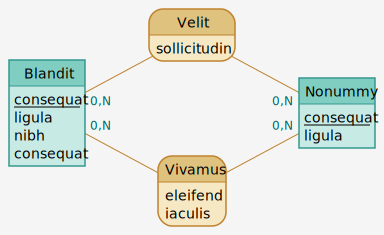

In [66]:
%%mocodo --shapes trebuchet --colors=brewer+1
Velit, 0N Blandit, 0N Nonummy: sollicitudin

Blandit: consequat, ligula, nibh, consequat
:::
Nonummy: consequat, ligula
  
Vivamus, 0N Nonummy, 0N Blandit: eleifend, iaculis

Si on ouvre le fichier de g√©om√©trie g√©n√©r√©, on y retrouvera les principaux param√®tres de position:

In [67]:
display.Code("mocodo_notebook/sandbox_geo.json")

{
  "width": 384,
  "height": 235,
  "cx": [
    [ "Velit", 192 ],
    [ "Blandit", 47 ],
    [ "Nonummy", 337 ],
    [ "Vivamus", 192 ]
  ],
  "cy": [
    [ "Velit", 35 ],
    [ "Blandit", 113 ],
    [ "Nonummy", 113 ],
    [ "Vivamus", 191 ]
  ],
  "shift": [
    [ "Velit,Blandit,0", 0 ],
    [ "Velit,Nonummy,0", 0 ],
    [ "Vivamus,Nonummy,0", 0 ],
    [ "Vivamus,Blandit,0", 0 ]
  ],
  "ratio": []
}

- Un couple de dimensions `width` et `height` d√©finit la taille du MCD¬†;
- deux listes de couples `cx` et `cy`, les abscisses et ordonn√©es des centres des bo√Ætes¬†;
- un dictionnaire `shift`, les positions relatives des cardinalit√©s par rapport √† leur position par d√©faut¬†;
- une liste `ratio`, les positions des fl√®ches √©ventuelles.

Pour rendre le plongement plus compact, nous apportons √† ce fichier quelques modifications¬†:

In [68]:
%%file mocodo_notebook/sandbox_geo.json
{
  "width": 384,
  "height": 155,
  "cx": [
    [ "Velit", 192 ],
    [ "Blandit", 47 ],
    [ "Nonummy", 337 ],
    [ "Vivamus", 192 ]
  ],
  "cy": [
    [ "Velit", 35 ],
    [ "Blandit", 73 ],
    [ "Nonummy", 73 ],
    [ "Vivamus", 111 ]
  ],
  "shift": [
    [ "Velit,Blandit,0", -30 ],
    [ "Velit,Nonummy,0", -30 ],
    [ "Vivamus,Nonummy,0", -30 ],
    [ "Vivamus,Blandit,0", -30 ]
  ],
  "ratio": []
}

Overwriting mocodo_notebook/sandbox_geo.json


Il suffit maintenant d'ajouter l'option `--reuse_geo` pour appliquer ces modifications¬†:

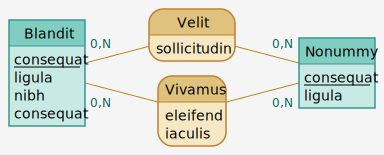

In [69]:
%%mocodo --shapes trebuchet --colors=brewer+1 --reuse_geo
Velit, 0N Blandit, 0N Nonummy: sollicitudin

Blandit: consequat, ligula, nibh, consequat
:::
Nonummy: consequat, ligula
  
Vivamus, 0N Nonummy, 0N Blandit: eleifend, iaculis

### Par √©dition de la sortie au format SVG

Tous les navigateurs modernes prennent en charge la visualisation des SVG. Pour aller au-del√†, il faudra faire appel √† un logiciel de dessin vectoriel d√©di√©, comme [Inkscape](https://www.inkscape.org/?lang=fr) (libre) ou Adobe Illustrator, Freehand, CorelDRAW, etc.
Les √©l√©ments du fichier SVG produit pourront alors √™tre repositionn√©s √† la souris. Certains sont group√©s pour permettre leur d√©placement en bloc. Dans la version actuelle, les liens ne suivent pas ces d√©placements, ce qui peut obliger √† des manipulations suppl√©mentaires.

## Mise en miroir d'un MCD

### Axes de sym√©trie

Mocodo permet de calculer facilement les sym√©triques d'un MCD. √Ä partir de la version 4.0, ces op√©rations sont des arguments de l'option `-r`¬†:

- selon l'axe vertical¬†: `-m flip_v`¬†;
- selon l'axe horizontal¬†: `-m flip_h`¬†;
- selon la premi√®re diagonale (transposition)¬†: `-m flip_d`.

**Astuce.** Pour une sym√©trie selon la seconde diagonale, il suffit de s√©quencer ces trois op√©rations dans un ordre quelconque¬†:
- selon la seconde diagonale¬†: `-m flip_v flip_h flip_d`.

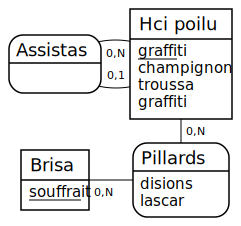

In [11]:
%%mocodo
Assistas, 01 Hci poilu, 0N Hci poilu
Hci poilu: graffiti, champignon, troussa, graffiti

Brisa: souffrait
Pillards, 0N Brisa, 0N Hci poilu: disions, lascar

%%mocodo
Pillards, 0N Brisa, 0N Hci poilu: disions, lascar
Hci poilu: graffiti, champignon, troussa, graffiti

Brisa: souffrait
Assistas, 01 Hci poilu, 0N Hci poilu


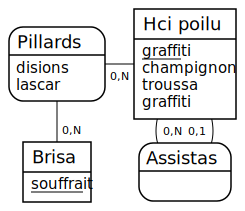

In [12]:
%%mocodo -m flip_v flip_h flip_d
Assistas, 01 Hci poilu, 0N Hci poilu
Hci poilu: graffiti, champignon, troussa, graffiti

Brisa: souffrait
Pillards, 0N Brisa, 0N Hci poilu: disions, lascar

### Astuce: √©dition rapide d'une ou plusieurs colonnes

La transposition peut √™tre utilis√©e pour r√©aliser plus facilement certaines op√©rations d'√©dition en colonne, en particulier sous [Mocodo online](http://mocodo.net). Par exemple, supposons que l'on souhaite d√©caler vers le haut la derni√®re colonne du MCD ci-dessous:

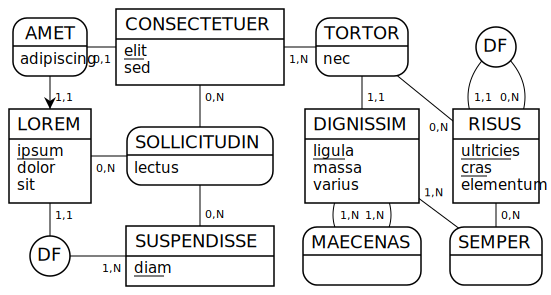

In [432]:
%%mocodo --flex=0
AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
CONSECTETUER: elit, sed
TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
DF, 11 RISUS, 0N RISUS

LOREM: ipsum, dolor, sit
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
DIGNISSIM: ligula, massa, varius
RISUS: ultricies, _cras, elementum

DF, 11 LOREM, 1N SUSPENDISSE
SUSPENDISSE: diam
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM
SEMPER, 0N RISUS, 1N DIGNISSIM

On commence par transposer:

In [431]:
%%mocodo --no_mcd -r flip:d
AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
CONSECTETUER: elit, sed
TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
DF, 11 RISUS, 0N RISUS

LOREM: ipsum, dolor, sit
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
DIGNISSIM: ligula, massa, varius
RISUS: ultricies, _cras, elementum

DF, 11 LOREM, 1N SUSPENDISSE
SUSPENDISSE: diam
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM
SEMPER, 0N RISUS, 1N DIGNISSIM

%%mocodo
AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
LOREM: ipsum, dolor, sit
DF, 11 LOREM, 1N SUSPENDISSE

CONSECTETUER: elit, sed
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
SUSPENDISSE: diam

TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
DIGNISSIM: ligula, massa, varius
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM

DF, 11 RISUS, 0N RISUS
RISUS: ultricies, _cras, elementum
SEMPER, 0N RISUS, 1N DIGNISSIM


Il suffit alors d'ins√©rer un deux-points au d√©but de chacune des trois premi√®res rang√©es, puis de retransposer dans l'autre sens:

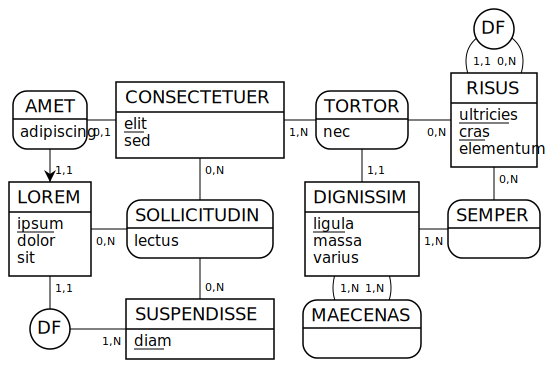

%%mocodo
:
:
:
DF, 11 RISUS, 0N RISUS

AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
CONSECTETUER: elit, sed
TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
RISUS: ultricies, _cras, elementum

LOREM: ipsum, dolor, sit
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
DIGNISSIM: ligula, massa, varius
SEMPER, 0N RISUS, 1N DIGNISSIM

DF, 11 LOREM, 1N SUSPENDISSE
SUSPENDISSE: diam
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM
:


In [429]:
%%mocodo -r flip:d
:
AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
LOREM: ipsum, dolor, sit
DF, 11 LOREM, 1N SUSPENDISSE

:
CONSECTETUER: elit, sed
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
SUSPENDISSE: diam

:
TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
DIGNISSIM: ligula, massa, varius
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM

DF, 11 RISUS, 0N RISUS
RISUS: ultricies, _cras, elementum
SEMPER, 0N RISUS, 1N DIGNISSIM


On peut se convaincre en examinant le nouveau texte d'entr√©e que le r√©sultat aurait √©t√© beaucoup plus p√©nible √† obtenir en proc√©dant directement.

## R√©arrangement automatique

Il est possible de demander √† Mocodo de chercher tout seul une ¬´¬†bonne¬†¬ª permutation des bo√Ætes, ce qui √† la main deviendrait vite difficile.

Le crit√®re que nous avons retenu pour √©valuer la qualit√© d'une permutation est double¬†:

1. les liens ne doivent pas se couper¬†;
2. leur longueur cumul√©e doit √™tre minimale.

Actuellement, deux algorithmes d'arrangement sont fournis¬†:

- un algorithme exact (`bb`, pour _Branch & Bound_), qui ne trouve que des solutions satisfaisant au premier crit√®re¬†;
- un algorithme approch√© (`ga`, pour _Genetic Algorithm_), r√©serv√© aux cas o√π il est impossible d'y satisfaire. L'algorithme va alors chercher des solutions o√π les liens se coupent seulement le moins possible.

### M√©thode exacte (_branch & bound_)

#### Arrangement dans la grille courante

Par d√©faut, le r√©arrangement automatique des bo√Ætes s'op√®re dans les limites de la grille courante¬†; c'est-√†-dire que le MCD r√©sultant aura (au plus) le m√™me nombre de colonnes et de rang√©es que le texte de d√©part (ici, $4\times5$)¬†:

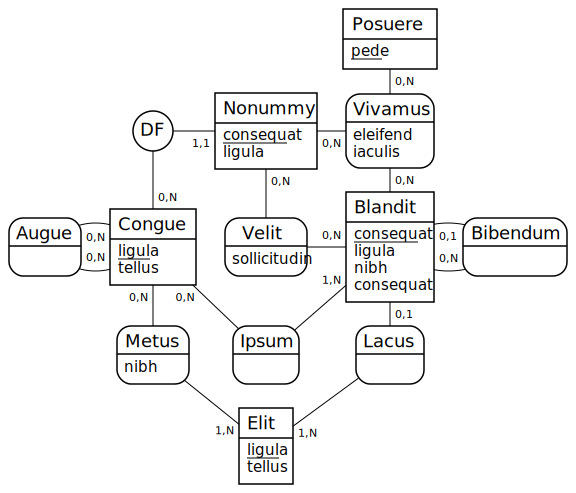

%%mocodo
:
:
:
Posuere: pede
:

:
DF, 11 Nonummy, 0N Congue
Nonummy: consequat, ligula
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
:

Augue, 0N Congue, 0N Congue
Congue: ligula, tellus
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Blandit: consequat, ligula, nibh, consequat
Bibendum, 01 Blandit, 0N Blandit

:
Metus, 1N Elit, 0N Congue: nibh
Ipsum, 1N Blandit, 0N Congue
Lacus, 01 Blandit, 1N Elit
:

:
:
Elit: ligula, tellus
:
:


In [51]:
%%mocodo -u arrange --seed=1 --no_text
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit

Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue

Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue
Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis

Nonummy: consequat, ligula

On peut quelquefois essayer de r√©duire cette grille. Par exemple, ce MCD comportant 13 bo√Ætes, celles-ci pourraient th√©oriquement tenir dans une grille $5\times3=15$. Modifions subrepticement le texte d'entr√©e √† la main pour avoir 3 blocs d'au plus 5 lignes, et v√©rifions qu'un tel r√©arrangement est possible:

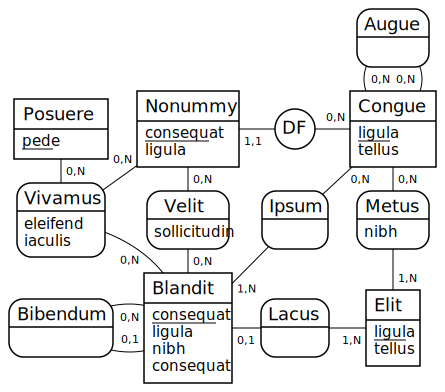

%%mocodo
:
:
:
Augue, 0N Congue, 0N Congue

Posuere: pede
Nonummy: consequat, ligula
DF, 11 Nonummy, 0N Congue
Congue: ligula, tellus

Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Ipsum, 1N Blandit, 0N Congue
Metus, 1N Elit, 0N Congue: nibh

Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus


In [53]:
%%mocodo -u arrange:fit=0 --seed=4 --no_text
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat

Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue

Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Nonummy: consequat, ligula

R√©arranger sur la grille courante est √©galement utile si vous vous rendez compte que votre MCD forme un [graphe chemin](https://fr.wikipedia.org/wiki/Graphe_chemin)¬†:

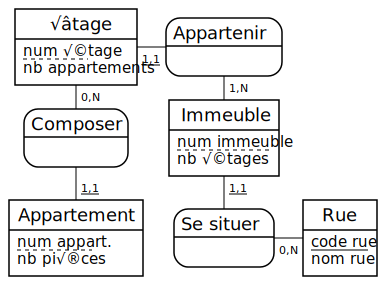

In [165]:
%%mocodo
√âtage: num √©tage, nb appartements
Appartenir, 1N Immeuble, _11 √âtage

Composer, 0N √âtage, _11 Appartement
Immeuble: num immeuble, nb √©tages

Appartement: num appart., nb pi√®ces
Se situer, 0N Rue, _11 Immeuble
Rue: code rue, nom rue

Dans ce cas, il vous suffit d'effacer (√† la main) les lignes vides avant de lancer le r√©arrangement¬†:

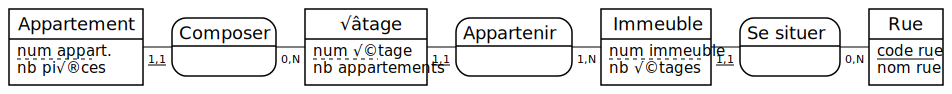

%%mocodo
Appartement: num appart., nb pi√®ces
Composer, 0N √âtage, _11 Appartement
√âtage: num √©tage, nb appartements
Appartenir, 1N Immeuble, _11 √âtage
Immeuble: num immeuble, nb √©tages
Se situer, 0N Rue, _11 Immeuble
Rue: code rue, nom rue


In [164]:
%%mocodo -m arrange
√âtage: num √©tage, nb appartements
Appartenir, 1N Immeuble, _11 √âtage
Composer, 0N √âtage, _11 Appartement
Immeuble: num immeuble, nb √©tages
Appartement: num appart., nb pi√®ces
Se situer, 0N Rue, _11 Immeuble
Rue: code rue, nom rue

#### Arrangement non contraint

Le r√©arrangement dit organique consiste √† choisir une premi√®re bo√Æte au hasard, puis √† essayer d'agr√©ger les autres sans se pr√©occuper de contenir le tout dans une grille pr√©d√©termin√©e. Il est invoqu√© par l'option `-m arrange_organic`.

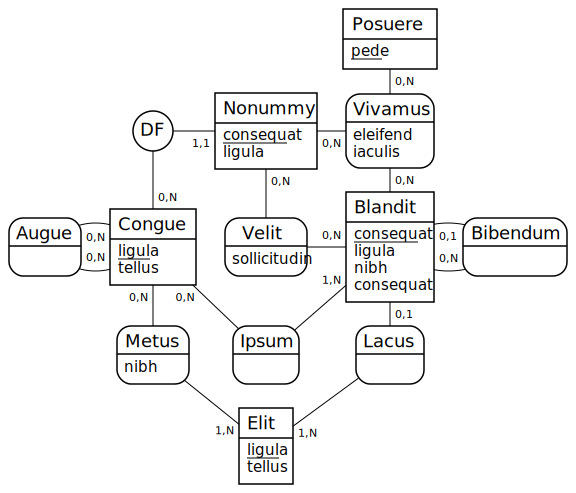

In [15]:
%%mocodo -m arrange_organic --seed=9 --no_text
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat

Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue

Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Nonummy: consequat, ligula

Cela donne un plongement sur une grille $5\times5$, ce qui est loin d'√™tre optimal. Cependant, l'arrangement organique fournit souvent un bon point de d√©part pour chercher soi-m√™me une permutation plus esth√©tique ou mettant en √©vidence certaines propri√©t√©s du MCD, en particulier dans le cas o√π Mocodo se plaint qu'aucun plongement planaire n'existe sur la grille courante.

#### Arrangement dans une grille √©quilibr√©e minimale

**Changement de la version 4.0.** Le reformatage du MCD pour le faire entrer dans une grille minimale n'avait de sens que s'il √©tait suivi d'un r√©arrangement du MCD. Il y est d√©sormais int√©gr√© comme pr√©-traitement. L'option `--fit` est donc retir√©e.

**Nouveaut√© de la version 2.2.** On peut √©viter √† la fois d'imposer des contraintes dimensionnelles (en modifiant √† la main le texte d'entr√©e) et de les relaxer (en optant pour une croissance organique). On cherche en g√©n√©ral √† faire tenir le MCD dans la plus petite grille possible, tout en maintenant un rapport ¬´¬†√©quilibr√©¬†¬ª entre hauteur et largeur. Par exemple, un MCD de 13 bo√Ætes (entit√©s ou associations) peut tenir dans les grilles:

- $13\times1$;
- $7\times2$, ce qui laisse 1 case vide;
- $5\times3$, ce qui laisse 2 cases vides;
- $4\times4$, ce qui laisse 3 cases vides;
- etc.

Les deux premi√®res grilles √©tant non √©quilibr√©es, on retiendra la plus petite des suivantes, de dimensions $5\times3$.

La table ci-dessous √©num√®re les dimensions des grilles minimales d'√©quilibre sup√©rieur √† 0,5 pour tous les MCD comportant moins de 100 bo√Ætes. On peut y v√©rifier par exemple que le MCD de taille 13 (en gras) se trouve effectivement aux coordonn√©es (5, 3).

|  | **1** | **2** | **3** | **4** | **5** | **6** | **7** | **8** | **9** | **10** | **11** | **12** | **13** |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| **1** | 1 | 2 | 3 |  |  |  |  |  |  |  |  |  |  |
| **2** |  | 4 | 5, 6 |  |  |  |  |  |  |  |  |  |  |
| **3** |  |  | 7, 8, 9 | 10, 11, 12 | **13**, 14, 15 |  |  |  |  |  |  |  |  |
| **4** |  |  |  | 16 | 17, 18, 19, 20 | 21, 22, 23, 24 | 26, 27, 28 |  |  |  |  |  |  |
| **5** |  |  |  |  | 25 | 29, 30 | 31, 32, 33, 34, 35 | 37, 38, 39, 40 | 43, 44, 45 |  |  |  |  |
| **6** |  |  |  |  |  | 36 | 41, 42 | 46, 47, 48 | 50, 51, 52, 53, 54 | 57, 58, 59, 60 | 65, 66 |  |  |
| **7** |  |  |  |  |  |  | 49 | 55, 56 | 61, 62, 63 | 67, 68, 69, 70 | 73, 74, 75, 76, 77 | 82, 83, 84 | 91 |
| **8** |  |  |  |  |  |  |  | 64 | 71, 72 | 78, 79, 80 | 85, 86, 87, 88 | 92, 93, 94, 95, 96 |  |
| **9** |  |  |  |  |  |  |  |  | 81 | 89, 90 | 97, 98, 99 |  |  |
| **10** |  |  |  |  |  |  |  |  |  | 100 |  |  |  |

**Nouveaut√© de la version 3.0.** La contrainte d'√©quilibre est rel√¢ch√©e pour les MCD √† 2 et 3 bo√Ætes, qui sont plac√©s respectivement sur des grilles $2\times1$ et $3\times1$ au lieu de $2\times2$.

L'argument `arrange` peut √™tre suffix√© d'un `_0` pour imposer un plongement sur la plus petite grille minimale √©quilibr√©e, ici donc $5\times3$¬†:

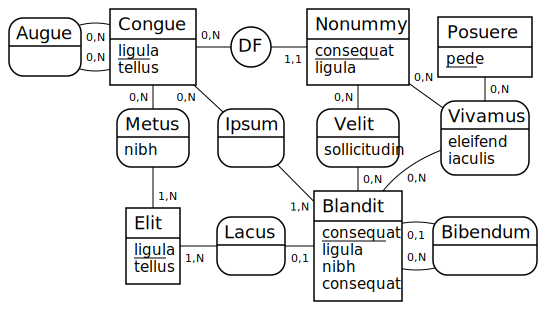

In [17]:
%%mocodo -m arrange_0 --seed 1 --no_text
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
  
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue

Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
  
DF, 11 Nonummy, 0N Congue
Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
  
Nonummy: consequat, ligula

Si ce r√©arrangement √©choue ou laisse √† d√©sirer, il est en fait possible de sp√©cifier n'importe laquelle des grilles suivantes avec l'option `-m arrange_i`, o√π $i$ est un entier positif. Ci-dessous, `_1` d√©signe la _premi√®re_ des grilles suivant la grille minimale, √† savoir $4\times4$.

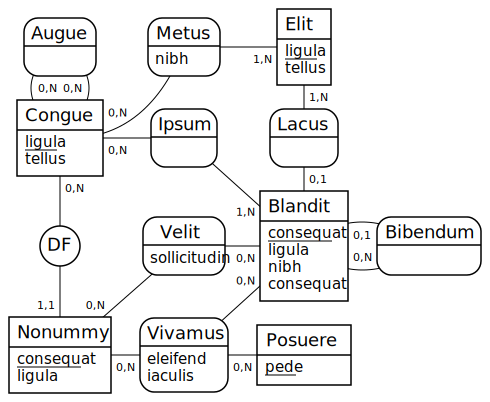

In [30]:
%%mocodo -m arrange_1 --seed 1 --no_text
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
  
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue

Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
  
DF, 11 Nonummy, 0N Congue
Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
  
Nonummy: consequat, ligula

Et ainsi de suite, `_2` pour la grille $5\times4$¬†:

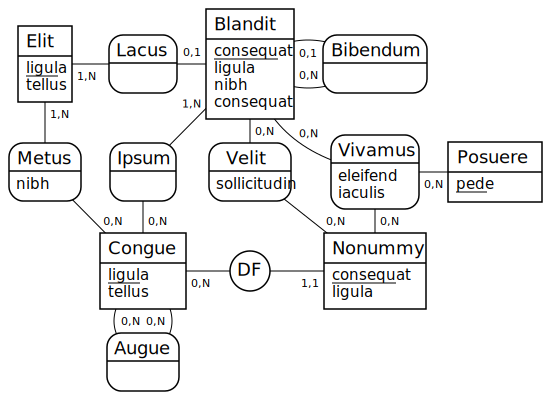

In [33]:
%%mocodo -m arrange_2 --seed 3 --no_text
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
  
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue

Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
  
DF, 11 Nonummy, 0N Congue
Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
  
Nonummy: consequat, ligula

**Remarques.**
- Quand le suffixe num√©rique de `arrange` d√©signe une grille inutilement grande, le r√©arrangement automatique retombe fr√©quemment sur une sous-grille de celle-ci.
- Dans [Mocodo online](https://www.mocodo.net), cliquer sur le bouton de r√©arrangement automatique cherche un plongement planaire non contraint (`arrange_organic`). Avec les touches de modification suivantes, il sera cherch√© sur une grille pr√©d√©finie (ce qui augmente le risque d'√©chec)¬†:
  - <kbd>shift</kbd>¬†: la grille courante (`arrange`)¬†;
  - <kbd>alt</kbd>¬†: la plus petite grille √©quilibr√©e (`arrange_0`)¬†;
  - <kbd>shift</kbd><kbd>alt</kbd>¬†: la premi√®re grille suivante (`arrange_1`).
- Changement de la version 4.0. Le reformatage d'un MCD pour le faire entrer dans une grille minimale (option `--fit`) n'avait de sens que s'il √©tait suivi d'un r√©arrangement. Il y est maintenant int√©gr√©. L'option est donc retir√©e.

 #### Limitations

Pour permettre au programme de rendre plus rapidement de bonnes solutions, on a born√© arbitrairement le nombre d'appels √† la fonction charg√©e de construire une permutation √† partir du placement de la premi√®re bo√Æte. De ce fait, l'algorithme n'est plus exact, en ce sens que la meilleure solution peut occasionnellement lui √©chapper. Si vous soup√ßonnez que c'est le cas, faites un autre essai, √©ventuellement en augmentant la borne (par d√©faut 10000):
```shell
mocodo --arrange --call_limit=100000
```

D'autre part, le r√©arrangement exact ne fonctionnera jamais sur les MCD:
  
- non planaires;
- planaires, mais n'admettant aucun plongement planaire dans les limites de la grille sp√©cifi√©e.

Rappelons qu'un graphe est dit [planaire](https://fr.wikipedia.org/wiki/Graphe_planaire) lorsqu'il en existe au moins un arrangement sans croisement. Le graphe non planaire comportant le plus petit nombre de liens est connu sous le doux nom de [$K_{3,3}$](http://www.nomachetejuggling.com/2011/10/29/why-the-complete-bipartite-graph-k33-is-not-planar/):

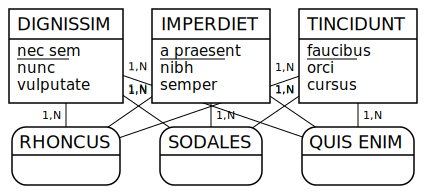

In [80]:
%%mocodo
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

Son r√©arrangement par _Branch & bound_ √©chouera donc n√©cessairement¬†:

In [122]:
%%mocodo -r arrange
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

Traceback (most recent call last):
  File "/Users/aristide/opt/anaconda3/bin/mocodo", line 8, in <module>
    sys.exit(main())
  File "/Users/aristide/Dropbox/Sites/mocodo/mocodo/__main__.py", line 250, in main
    run()
  File "/Users/aristide/Dropbox/Sites/mocodo/mocodo/__main__.py", line 69, in __call__
    source = self.arrange(source, subargs)
  File "/Users/aristide/Dropbox/Sites/mocodo/mocodo/__main__.py", line 146, in arrange
    raise ValueError(is_constrained)
ValueError: False


In [127]:
%%mocodo -r arrange:grid=organic
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

Mocodo Err.41 - Impossible de calculer une mise en page planaire sur la grille impartie.


Comme on voit, Mocodo ne cherche pas √† savoir si la non-planarit√© est intrins√®que au graphe, ou r√©sulte des dimensions de la grille impos√©e pour le plongement. Pour en avoir le c≈ìur net, tentez un arrangement non contraint¬†:

In [126]:
%%mocodo -r arrange:grid=0
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

Mocodo Err.9 - Failed to calculate a planar layout on the given grid.


### M√©thode heuristique (algorithme g√©n√©tique)

Dans tous ces cas, on pourra se rabattre sur l'heuristique. Celle-ci, au lieu d'interdire les croisements, cherche simplement √† en minimiser le nombre. L'algorithme est invoqu√© en pr√©cisant √† part `--arrangement ga` (pour _Genetic Algorithm_). Les √©ventuels suffixes de `arrange` sont alors ignor√©s.

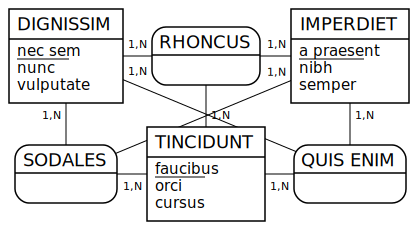

%%mocodo
DIGNISSIM: nec sem, nunc, vulputate
RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
IMPERDIET: a praesent, nibh, semper

SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
TINCIDUNT: faucibus, orci, cursus
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT


In [42]:
%%mocodo -m arrange --arrangement=ga --seed=42
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

L'am√©lioration ne saute pas forc√©ment aux yeux, mais il n'y a plus que 3 croisements au lieu de 9. Ce plongement constitue en tout cas un bon point de d√©part pour un r√©arrangement manuel. Pour arriver √† une repr√©sentation lisible, il ne reste plus qu'√† ins√©rer quelques bo√Ætes invisibles:

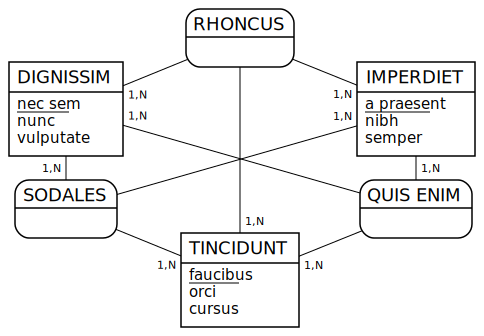

In [43]:
%%mocodo
RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

DIGNISSIM: nec sem, nunc, vulputate
:::
IMPERDIET: a praesent, nibh, semper

SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
:::
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

TINCIDUNT: faucibus, orci, cursus

**NB.** De nombreux param√®tres permettent de r√©gler le fonctionnement de l'algorithme g√©n√©tique¬†:

- `population_size` (d√©faut¬†: 1000)
- `max_generations` (d√©faut¬†: 300)
- `plateau` (d√©faut¬†: 30)
- `crossover_rate` (d√©faut¬†: 0.9)
- `mutation_rate` (d√©faut¬†: 0.06)
- `sample_size` (d√©faut¬†: 7)

R√©serv√©s aux sp√©cialistes, ils ne sont pas d√©crits dans cette documentation.

## Conversion dans d'autres formats graphiques

Mocodo g√©n√®re syst√©matiquement une sortie au format SVG¬†:

In [104]:
%%mocodo --no_mcd --svg_to png pdf
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

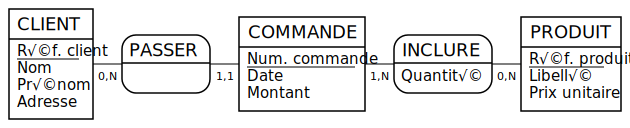

In [105]:
display.SVG("mocodo_notebook/sandbox.svg")

**Nouveaut√© de la version 3.0.** Avec l'option `--svg_to` suivie de `pdf` et/ou `png` (ou en cochant les cases correspondantes dans l'onglet Options de la version web), Mocodo convertit d√©sormais ce SVG en PDF et PNG. Le premier format est id√©al pour l'inclusion dans des documents destin√©s √† √™tre projet√©s, diffus√©s ou imprim√©s¬†:

In [106]:
display.IFrame("mocodo_notebook/sandbox.pdf", width="100%", height="100%")

Le second est un format bitmap, donc avec une certaine perte de qualit√©¬†:

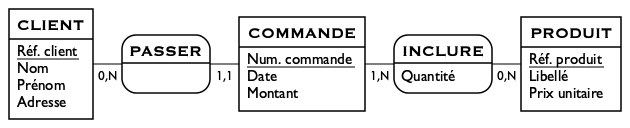

In [107]:
display.Image("mocodo_notebook/sandbox.png")

Attention, dans un cas comme dans l'autre, seules les polices de caract√®res les plus courantes seront compos√©es correctement sur toutes les plateformes.

**Changement de la version 4.0.** Ces fonctionnalit√©s ne sont plus accessibles avec les options `--pdf` et `--png` (retir√©es), mais comme arguments de la nouvelle option `--svg_to`.

# Conversion en relationnel

Le passage au relationnel se fait en deux √©tapes:
- la cr√©ation d'une repr√©sentation **interne** compl√®te du MLD;
- la traduction de celle-ci en une repr√©sentation **externe** dans le ou les formats de sortie souhait√©s.

## Construction de la repr√©sentation interne

L'algorithme de base r√©alise la s√©quence d'op√©rations suivante¬†:

1. Pour chaque entit√©, une relation (table) de m√™me nom et de m√™mes attributs est cr√©√©e. Le ou les identifiants de l'entit√© constituent la cl√© primaire de la relation.
2. Toute relation issue d'une entit√© faible est renforc√©e, c'est-√†-dire que la cl√© primaire de l'entit√© qu'elle d√©termine fonctionnellement vient s'adjoindre √† sa cl√© primaire, au besoin de fa√ßon r√©cursive.
3. Les associations sont trait√©es ainsi:
  1. si toutes les pattes de l'association portent la cardinalit√© maximale N, une relation de m√™me nom et de m√™mes attributs est cr√©√©e. Sa cl√© primaire est constitu√©e de l'ensemble des cl√©s primaires des relations issues des entit√©s mises en jeu;
  2. dans le cas contraire, c'est-√†-dire si l'une des pattes de l'association porte la cardinalit√© (1,1), ou √† d√©faut (0,1), l'entit√© distingu√©e se voit adjoindre:
    1. en tant que cl√©s √©trang√®res, l'ensemble des cl√©s primaires des autres entit√©s mises en jeu;
    2. en tant que simples attributs, l'ensemble des attributs de l'association.

**Remarque.** Un couple de cardinalit√©s non standard, c'est-√†-dire distinct de (0,1), (1,1), (0,N) et (1,N), est trait√© comme (0,1) si son deuxi√®me symbole est un 1, et comme (0,N) sinon. Cela couvre en particulier les cas (\*, 1), (\*,N), (?,?) et (X,X).

### Traitement des associations non DF

Illustrons le premier cas du troisi√®me point sur un MCD comportant des associations triple, double et r√©flexive dont toutes les cardinalit√©s maximales sont √† N.

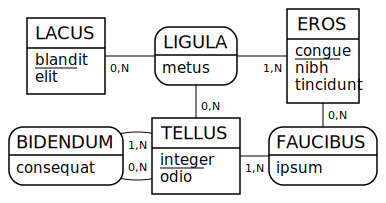

In [48]:
%%mocodo --mld
LACUS: blandit, elit
LIGULA, 0N LACUS, 1N EROS, 0N TELLUS: metus
EROS: congue, nibh, tincidunt  

BIDENDUM, 0N TELLUS, 1N TELLUS: consequat
TELLUS: integer, odio
FAUCIBUS, 1N TELLUS, 0N EROS: ipsum

Notez la [d√©sambigu√Øsation automatique par num√©rotation](#disambiguation_by_number) du deuxi√®me attribut de BIBENDUM.

### Traitement des associations DF

Illustrons l'autre cas sur un MCD quasiment identique, √† ceci pr√®s que certaines cardinalit√©s maximales ont √©t√© ramen√©es √† 1. En tant que d√©pendances fonctionnelles, toutes les associations vont alors dispara√Ætre.

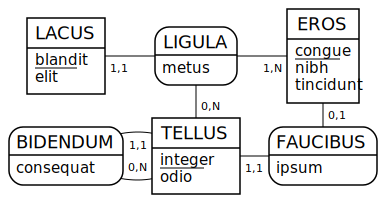

In [49]:
%%mocodo --mld
LACUS: blandit, elit
LIGULA, 11 LACUS, 1N EROS, 0N TELLUS: metus
EROS: congue, nibh, tincidunt  

BIDENDUM, 0N TELLUS, 11 TELLUS: consequat
TELLUS: integer, odio
FAUCIBUS, 11 TELLUS, 01 EROS: ipsum

Notez les points suivants:
- la cardinalit√© (1,1) est par d√©faut prioritaire sur (0,1) lors du traitement de l'association FAUCIBUS;
- Mocodo n'impose pas de borne sup√©rieure √† l'arit√© d'une association de d√©pendance fonctionnelle, ici par exemple LIGULA est ternaire (alternative: `-m split`);
- Mocodo n'interdit pas √† une association de d√©pendance fonctionnelle de porter des attributs (alternative: `-m drain`).

Les deux alternatives mentionn√©es, plus orthodoxes mais plus lourdes, produisent de toute fa√ßon le m√™me sch√©ma relationnel.

Autre point litigieux: dans les d√©pendances fonctionnelles √† double sens ((1,1) des deux c√¥t√©s), la priorit√© est donn√©e √† la premi√®re des entit√©s √©num√©r√©es dans l'association. M√™me chose quand deux (0,1) sont en concurrence.

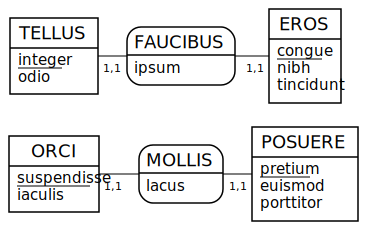

In [50]:
%%mocodo --mld
TELLUS: integer, odio
FAUCIBUS, 11 TELLUS, 11 EROS: ipsum
EROS: congue, nibh, tincidunt  

ORCI: suspendisse, iaculis
MOLLIS, 11 POSUERE, 11 ORCI: lacus
POSUERE: pretium, euismod, porttitor

Les traitements alternatifs (migration dans les deux sens, fusion en une seule table, etc.)  ne sont pas pris en charge par Mocodo.

### Traitement des entit√©s faibles (identification relative)

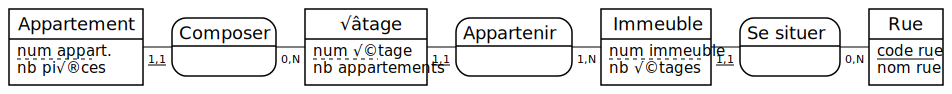

In [51]:
%%mocodo --mld --relations diagram
Appartement: num appart., nb pi√®ces
Composer, 0N √âtage, _11 Appartement
√âtage: num √©tage, nb appartements
Appartenir, 1N Immeuble, _11 √âtage
Immeuble: num immeuble, nb √©tages
Se situer, 0N Rue, _11 Immeuble
Rue: code rue, nom rue

Dans ce joli exemple d√ª √† Idris NEUMANN, [_Initiation √† la conception de bases de donn√©es relationnelles avec MERISE_](http://ineumann.developpez.com/tutoriels/merise/initiation-merise/#LIV-A), les renforcements successifs aboutissent √† faire entrer l'identifiant de RUE dans celui de APPARTEMENT, alors m√™me que ces entit√©s sont s√©par√©es par non moins de trois associations.

Ce processus appara√Æt clairement sur le [diagramme relationnel](#Diagramme-relationnel) g√©n√©r√© par la commande pr√©c√©dente:

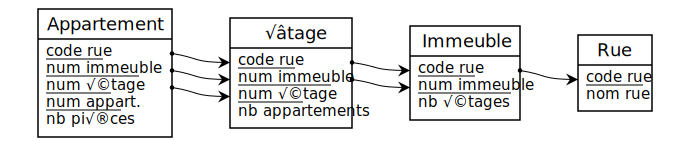

In [52]:
%mocodo --input sandbox.mld

Les renforcements en cascade sont correctement g√©r√©s dans tous les cas, et les renforcements cycliques produisent un message d'erreur.

In [61]:
%%mocodo
Pick, 0N Land, _11 Peer
Land: true, hold

Peer: foot, city
Zone, 1N Peer, _11 Land

Mocodo Err.17 - Cycle d'entit√©s faibles dans "Land", "Peer".


### R√©tablissement explicite de la s√©mantique des DF disparues

Mocodo permet de modifier l√©g√®rement le nom d'une cl√© √©trang√®re, de fa√ßon √† r√©introduire la s√©mantique perdue lors de la disparition de l'association de d√©pendance fonctionnelle par laquelle elle a migr√©.

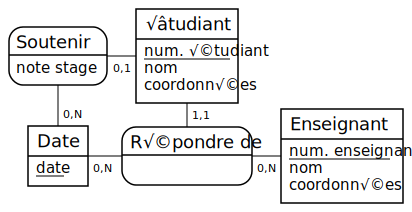

In [62]:
%%mocodo --mld
Soutenir, 01 √âtudiant, 0N Date: note stage
√âtudiant: num. √©tudiant, nom, coordonn√©es

Date: date
R√©pondre de, 0N Date, 11 √âtudiant, 0N Enseignant
Enseignant: num. enseignant, nom, coordonn√©es

Par exemple, ci-dessus, la conversion en relationnel produit dans la relation √âTUDIANT des cl√©s √©trang√®res _date_ et _date.1_ qui ne peuvent √™tre laiss√©es en l'√©tat. Par ailleurs, on peut souhaiter expliciter la raison pour laquelle un num√©ro d'enseignant appara√Æt dans la table √âTUDIANT.

Dans les deux cas, il suffit d'employer le syst√®me d'annotation de pattes introduit [plus haut](#Afficher-l'explication-des-cardinalit%C3%A9s). Le nom entre crochets s'appelle alors un **r√¥le**.

In [94]:
%%mocodo --mld --no_mcd
Soutenir, 01 √âtudiant, 0N [soutenance] Date: note stage
√âtudiant: num. √©tudiant, nom, coordonn√©es

Date: date
R√©pondre de, 0N [visite] Date, 11 √âtudiant, 0N [responsable] Enseignant
Enseignant: num. enseignant, nom, coordonn√©es

De fa√ßon moins cruciale, la technique s'applique aussi aux autres types d'association:

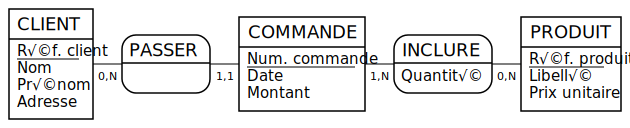

In [63]:
%%mocodo --mld
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
PASSER, 0N [ayant command√©] CLIENT, 11 [note ignor√©e] COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N [pass√©e] COMMANDE, 0N [command√©] PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

Pour d√©sactiver cette fonctionnalit√© (notamment dans le cas o√π vous annotez chaque cardinalit√© d'une explication destin√©e aux novices), passez l'option `--disambiguation=numbers_only`.

### Conversion forc√©e d'une association DF en table

Le traitement r√©gulier d'une association DF (pr√©sence d'une cardinalit√© (1,1) ou, √† d√©faut, (0,1)) ne la convertit pas en table. On a cependant la possibilit√© de forcer cette conversion en pr√©fixant son nom d'un signe ¬´¬†`+`¬†¬ª.

**Nouveaut√© de la version 4.0.** Auparavant, il fallait mettre entre crochets droits le nom de l'association. La nouvelle notation est coh√©rente avec celle utilis√©e pour [emp√™cher la suppression d'une table r√©duite √† sa cl√© primaire](#Suppression-des-tables-ind√©pendantes-r√©duites-√†-leur-cl√©-primaire).

Par exemple, supposons une cardinalit√© (0,1) dans laquelle le 0 est grand devant le 1 en termes de fr√©quence d'apparition¬†: par d√©faut, la plupart des occurrences de la cl√© √©trang√®re ainsi constitu√©e restent vides. Forcer la cr√©ation d'une table d√©di√©e permettra d'√©conomiser de l'espace de stockage.

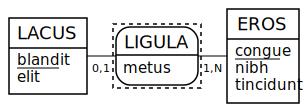

In [64]:
%%mocodo --relations html_verbose
LACUS: blandit, elit
+LIGULA, 01 LACUS, 1N EROS: metus
EROS: congue, nibh, tincidunt

In [65]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

Cliquez sur LIGULA ci-dessus pour voir mentionner le fait que la cr√©ation de la table a √©t√© forc√©e manuellement.

La nouvelle notation fonctionne quelles que soient les cardinalit√©s de l'association. Si cette derni√®re devait d√©j√† donner lieu √† la cr√©ation d'une table, l'indication est visualis√©e, mais ignor√©e lors du passage au relationnel.

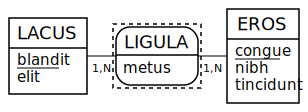

In [68]:
%%mocodo --relations html_verbose
LACUS: blandit, elit
+LIGULA, 1N LACUS, 1N EROS: metus
EROS: congue, nibh, tincidunt

In [69]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

**Limitation.** Cette conversion forc√©e ne fonctionne si l'association est appel√©e ¬´¬†DF¬†¬ª, qui clairement ne constituerait pas un bon nom de table.

### R√©duction de cl√© primaire (ou agr√©gation, ou pseudo-entit√©)

Il arrive qu'un sous-ensemble strict de l'ensemble des identifiants des entit√©s mises en jeu dans une association dont toutes les pattes portent la cardinalit√© N, suffise √† constituer la cl√© primaire de la table issue de cette association¬†: cela se fait facilement au niveau relationnel en privant de leur caract√®re identifiant les cl√©s qui n'appartiennent pas √† ce sous-ensemble.

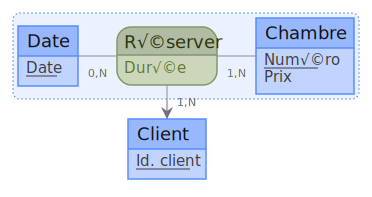

**Chambre** (<ins>Num√©ro</ins>, Prix)<br>
**R√©server** (<ins>_#Num√©ro_</ins>, <ins>Date</ins>, Id. client, Dur√©e)


In [46]:
%%mocodo --mld --colors ocean
Date: Date
R√©server, /1N Client, 1N Chambre, 0N Date: Dur√©e
Chambre: Num√©ro, Prix

Client: Id. client

C'est plus ou moins √©quivalent √† la notion traditionnelle d'agr√©gation ou pseudo-entit√©.

Le traitement se g√©n√©ralise naturellement aux agr√©gats r√©duits √† une seule entit√©¬†:

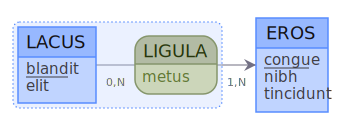

**EROS** (<ins>congue</ins>, nibh, tincidunt)<br>
**LACUS** (<ins>blandit</ins>, elit)<br>
**LIGULA** (<ins>_#blandit_</ins>, _#congue_, metus)


In [124]:
%%mocodo --mld --colors ocean
LACUS: blandit, elit
LIGULA, 0N LACUS, /1N EROS: metus
EROS: congue, nibh, tincidunt

TODO: √ßa doit √™tre faux. Voir une bonne solution deux cellules plus loin.

In [126]:
%mocodo --input sandbox -c chen:layout=circo defer --colors=ocean

Version √©quivalente avec entit√© faible¬†:

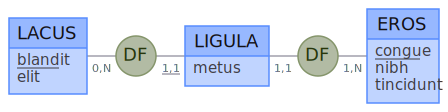

**EROS** (<ins>congue</ins>, nibh, tincidunt)<br>
**LACUS** (<ins>blandit</ins>, elit)<br>
**LIGULA** (<ins>_#blandit_</ins>, metus, _#congue_)


In [420]:
%%mocodo --mld --colors ocean
LACUS: blandit, elit
DF, 0N LACUS, _11 LIGULA
LIGULA: _metus
DF, 11 LIGULA, 1N EROS
EROS: congue, nibh, tincidunt

In [421]:
%mocodo --input sandbox -c chen:layout=circo defer --colors=ocean

### Traitement de l'h√©ritage

#### S√©mantique de la fl√®che

- Le sens de la fl√®che d√©termine si la migration d'attributs se fait de la m√®re vers les filles (`>`) ou l'inverse (`<`).
- Son √©paisseur d√©termine si la migration est ¬´¬†minimale¬†¬ª (`-`) ou ¬´¬†maximale¬†¬ª (`=`).

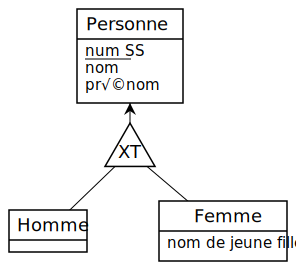

In [72]:
%%mocodo --mld
Personne: num SS, nom, pr√©nom

/XT\ Personne <- Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

Ci-dessus, le passage au relationnel produit une seule table¬†:
- _num SS_ est l'identifiant¬†;
- _nom_ et _pr√©nom_ sont des champs communs √† toutes les occurrences¬†;
- _sexe_ permet de pr√©ciser si une ligne donn√©e correspond √† un homme et/ou une femme. Si le type d'h√©ritage est total et exclusif, un bool√©en ¬´¬†non nullable¬†¬ª (`NOT NULL` en SQL) fera l'affaire¬†; s'il n'y a pas totalit√©, certaines personnes ne sont ni homme, ni femme, et ce bool√©en est ¬´¬†nullable¬†¬ª¬†; s'il n'y a pas exclusion, certaines personnes peuvent √™tre √† la fois homme et femme, et dans ce cas on peut choisir de coder le type par un entier que l'on interpr√©tera en binaire.
- _nom de jeune fille_ est un attribut sp√©cifique aux femmes. Notez qu'il peut √™tre nul, non seulement pour les occurrences ¬´¬†non femmes¬†¬ª, mais aussi pour les occurrences ¬´¬†femmes¬†¬ª c√©libataires. Cela montrer l'int√©r√™t de disposer d'un champ _sexe_ s√©par√©.

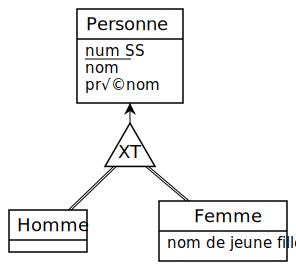

In [73]:
%%mocodo --mld
Personne: num SS, nom, pr√©nom

/XT\ Personne <= Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

Ci-dessus, on a doubl√© la fl√®che pour r√©aliser une migration ¬´¬†maximale¬†¬ª des entit√©s-filles vers l'entit√©-m√®re. Notez le doublement des pattes qui distinguent les entit√©s-filles. Deux nouveaux champs sont apparus¬†: _Homme_ et _Femme_, cens√©s √™tre de type bool√©en. Selon le type d'h√©ritage, ils sont ici plus ou moins redondants avec _sexe_ (si c'est `/XT\`, _sexe_ est pr√©f√©rable, mais si c'est `/\`, _sexe_ peut √™tre supprim√©).

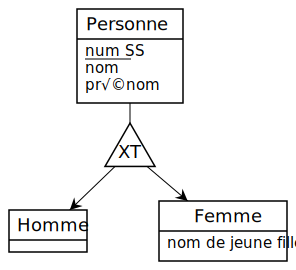

In [74]:
%%mocodo --mld
Personne: num SS, nom, pr√©nom

/XT\ Personne -> Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

Ci-dessus, on a r√©alis√© une migration ¬´¬†minimale¬†¬ª de la m√®re vers les filles. Notez l'inversion du sens des fl√®ches sur le sch√©ma conceptuel.

- Une table _Personne_ accueille les attributs communs. Notez la pr√©sence du champ _sexe_.
- Une table _Femme_ compl√®te ces informations par l'attribut sp√©cifique _nom de jeune fille_.
- La table _Homme_, r√©duite √† sa cl√© primaire, a √©t√© supprim√©e.

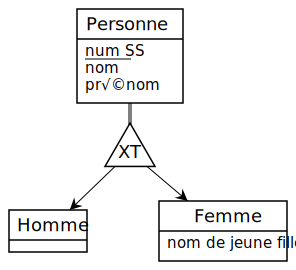

In [75]:
%%mocodo --mld
Personne: num SS, nom, pr√©nom

/XT\ Personne => Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

Avec une migration ¬´¬†maximale¬†¬ª vers les entit√©s-filles, les attributs communs sont ¬´¬†d√©plac√©s¬†¬ª dans chacune des tables-filles. Aucune table-m√®re n'est cr√©√©e.

Cela n'est possible que si l'h√©ritage est total (`/T\` ou `/XT\`)¬†; dans le cas contraire, certaines occurrences (celles qui ne sont ni homme, ni femme) seraient perdues. Mocodo l√®ve alors une erreur¬†:

In [76]:
%%mocodo --mld
Personne: num SS, nom, pr√©nom

/X\ Personne => Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

Mocodo Err.25 - La totalit√© (/T\ or /XT\) est requise pour d√©finir l'h√©ritage ¬´ => ¬ª sur
l'entit√©-m√®re ¬´¬†Personne¬†¬ª.


#### H√©ritage et associations externes

Trois des quatre m√©canismes de passage au relationnel d√©crits ci-dessus conduisent √† la disparition d'entit√©s. Pour assurer que les jointures restent possibles, il faut alors veiller √† ¬´¬†recoller¬†¬ª les r√©f√©rences qui transitaient par ces entit√©s. On se donne ci-dessous un MCD o√π les entit√©s d'un h√©ritage sont associ√©es de fa√ßon diverses √† des entit√©s externes, et on √©tudie les tables et le diagramme relationnel produits selon le m√©canisme de passage au relationnel demand√©.

**Aide.** Cliquez sur le nom des tables pour lire les explications d√©taill√©es. Survolez le libell√© des attributs pour afficher leur cat√©gorie attribu√©e en interne par Mocodo (√† des fins de d√©bogage).

Voici un √©ventail de cas possibles pour le m√©canisme de migration `<-` vers une entit√©-m√®re, avec disparition des entit√©s-filles (le cas `<=`, essentiellement identique, n'est pas donn√©).

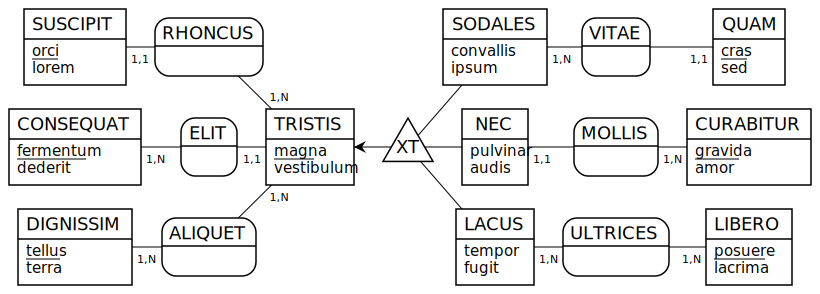

In [77]:
%%mocodo --relations diagram html_verbose
SUSCIPIT: orci, lorem
RHONCUS, 1N TRISTIS, 11 SUSCIPIT
:
:
SODALES: convallis, ipsum
VITAE, 11 QUAM, 1N SODALES
QUAM: cras, sed

CONSEQUAT: fermentum, dederit
ELIT, 11 TRISTIS, 1N CONSEQUAT
TRISTIS: magna, vestibulum
/XT\ TRISTIS <- SODALES, NEC, LACUS: type
NEC: pulvinar, audis
MOLLIS, 1N CURABITUR, 11 NEC
CURABITUR: gravida, amor

DIGNISSIM: tellus, terra
ALIQUET, 1N TRISTIS, 1N DIGNISSIM
:
:
LACUS: tempor, fugit
ULTRICES, 1N LIBERO, 1N LACUS
LIBERO: posuere, lacrima

In [78]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

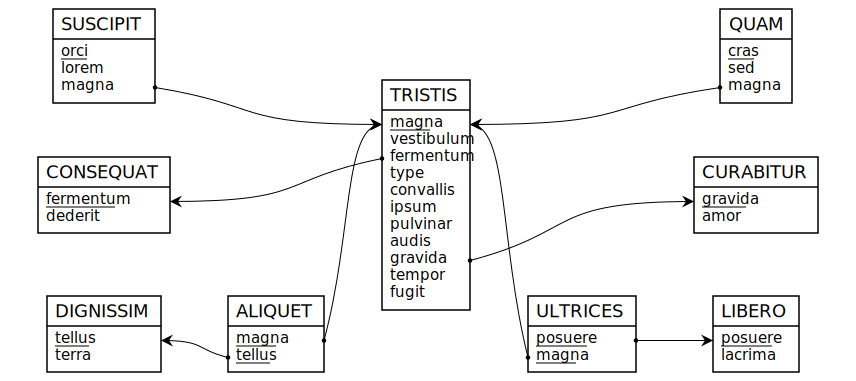

In [79]:
%mocodo --input sandbox.mld

C'est la partie droite de ce diagramme relationnel qui est int√©ressante. Notez que la disparition des entit√©s-filles n'emp√™che pas de lier _Quam_, _Curabitur_ et _Ultrices_ √† la table-m√®re _Tristis_.

Changeons maintenant le sens de la fl√®che¬†:

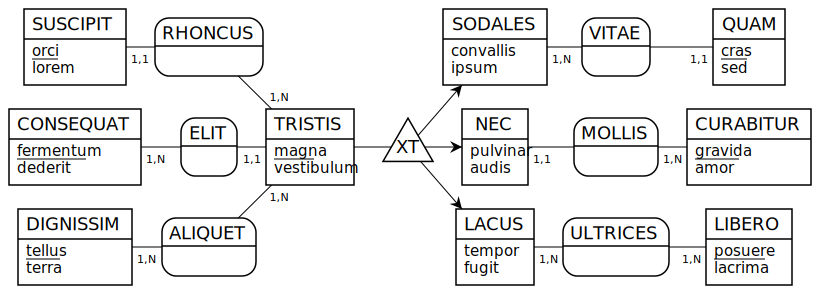

In [80]:
%%mocodo --relations diagram html_verbose
SUSCIPIT: orci, lorem
RHONCUS, 1N TRISTIS, 11 SUSCIPIT
:
:
SODALES: convallis, ipsum
VITAE, 11 QUAM, 1N SODALES
QUAM: cras, sed

CONSEQUAT: fermentum, dederit
ELIT, 11 TRISTIS, 1N CONSEQUAT
TRISTIS: magna, vestibulum
/XT\ TRISTIS -> SODALES, NEC, LACUS: type
NEC: pulvinar, audis
MOLLIS, 1N CURABITUR, 11 NEC
CURABITUR: gravida, amor

DIGNISSIM: tellus, terra
ALIQUET, 1N TRISTIS, 1N DIGNISSIM
:
:
LACUS: tempor, fugit
ULTRICES, 1N LIBERO, 1N LACUS
LIBERO: posuere, lacrima

In [81]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

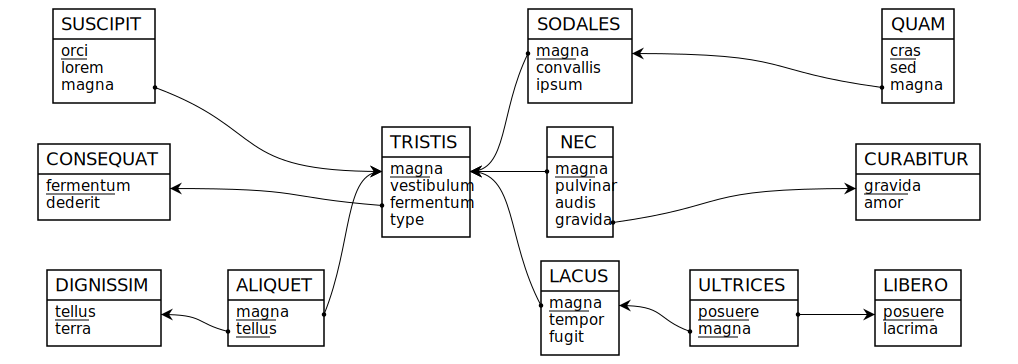

In [82]:
%mocodo --input sandbox.mld

Ce cas est facile, puisque toutes les entit√©s ont donn√© lieu √† la cr√©ation d'une table.

C'est plus compliqu√© si l'on demande une migration ¬´¬†maximale¬†¬ª vers les entit√©s-filles (avec disparition de l'entit√©-m√®re)¬†:

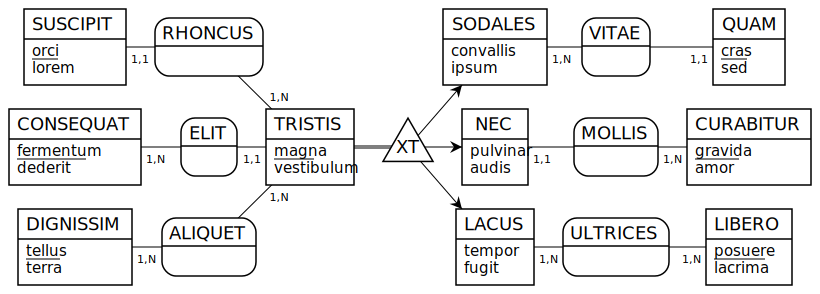

In [83]:
%%mocodo --relations diagram html_verbose
SUSCIPIT: orci, lorem
RHONCUS, 1N TRISTIS, 11 SUSCIPIT
:
:
SODALES: convallis, ipsum
VITAE, 11 QUAM, 1N SODALES
QUAM: cras, sed

CONSEQUAT: fermentum, dederit
ELIT, 11 TRISTIS, 1N CONSEQUAT
TRISTIS: magna, vestibulum
/XT\ TRISTIS => SODALES, NEC, LACUS: type
NEC: pulvinar, audis
MOLLIS, 1N CURABITUR, 11 NEC
CURABITUR: gravida, amor

DIGNISSIM: tellus, terra
ALIQUET, 1N TRISTIS, 1N DIGNISSIM
:
:
LACUS: tempor, fugit
ULTRICES, 1N LIBERO, 1N LACUS
LIBERO: posuere, lacrima

In [84]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

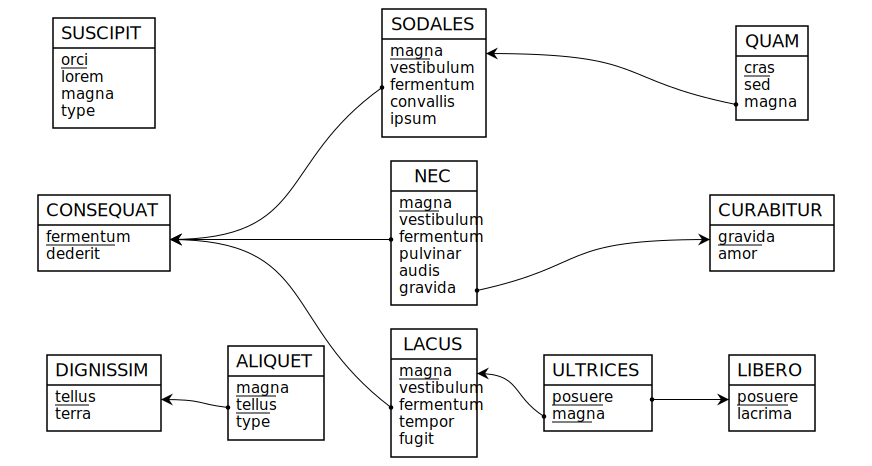

In [85]:
%mocodo --input sandbox.mld

On remarque que la cl√© √©trang√®re _fermentum_ est correctement reproduite dans les tables-filles, mais que les tables _Suscipit_ et _Aliquet_ ne sont plus li√©es au reste du MCD. L'int√©grit√© r√©f√©rentielle du champ _magna_ n'est plus assur√©e. Notez cependant que le champ _type_ d√©fini avec l'h√©ritage migre jusque dans ces tables. Ainsi, _type_ permet de savoir si la valeur de _magna_ dans une occurrence de _Suscipit_ r√©f√®re √† une occurrence de _Sodales_, de _Nec_ ou de _Lacus_.

#### H√©ritage et associations internes

On passe maintenant en revue, sans commentaire, le traitement des diff√©rentes forme d'h√©ritage lorsque des associations lient l'entit√©-m√®re et les entit√©s-filles.

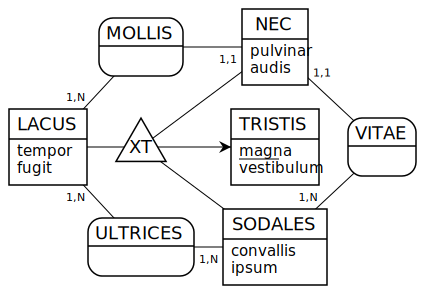

In [86]:
%%mocodo --relations diagram html_verbose
:
MOLLIS, 1N [via mollis] LACUS, 11 NEC
NEC: pulvinar, audis
:

LACUS: tempor, fugit
/XT\ TRISTIS <- SODALES, NEC, LACUS: type
TRISTIS: magna, vestibulum
VITAE, 11 NEC, 1N [via vitae] SODALES

:
ULTRICES, 1N [sodales] SODALES, 1N [lacus] LACUS
SODALES: convallis, ipsum
:

In [87]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

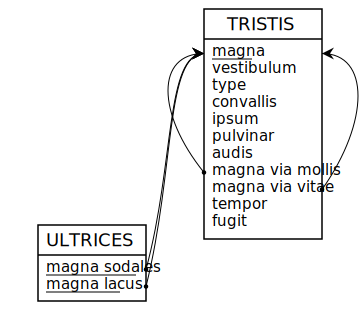

In [88]:
%mocodo --input sandbox.mld

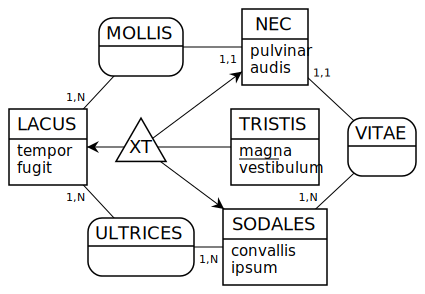

In [89]:
%%mocodo --relations diagram html_verbose
:
MOLLIS, 1N [via mollis] LACUS, 11 NEC
NEC: pulvinar, audis
:

LACUS: tempor, fugit
/XT\ TRISTIS -> SODALES, NEC, LACUS: type
TRISTIS: magna, vestibulum
VITAE, 11 NEC, 1N [via vitae] SODALES

:
ULTRICES, 1N [sodales] SODALES, 1N [lacus] LACUS
SODALES: convallis, ipsum
:

In [90]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

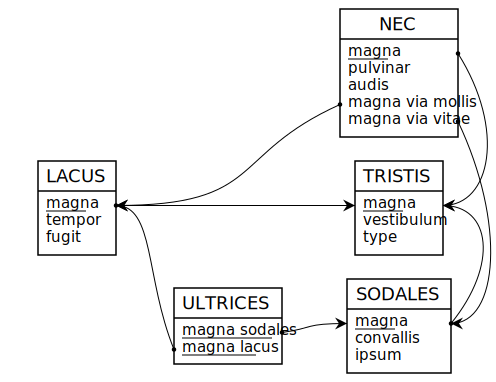

In [91]:
%mocodo --input sandbox.mld

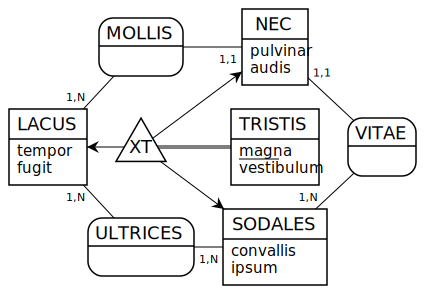

In [92]:
%%mocodo --relations diagram html_verbose
:
MOLLIS, 1N [via mollis] LACUS, 11 NEC
NEC: pulvinar, audis
:

LACUS: tempor, fugit
/XT\ TRISTIS => SODALES, NEC, LACUS: type
TRISTIS: magna, vestibulum
VITAE, 11 NEC, 1N [via vitae] SODALES

:
ULTRICES, 1N [sodales] SODALES, 1N [lacus] LACUS
SODALES: convallis, ipsum
:

In [93]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

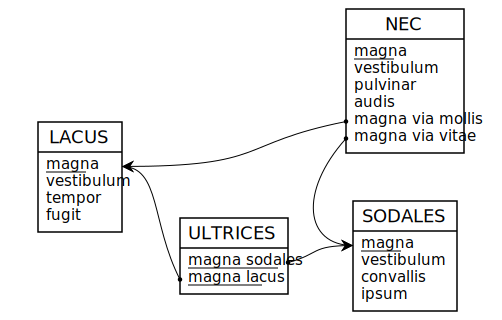

In [94]:
%mocodo --input sandbox.mld

### Suppression des tables ind√©pendantes r√©duites √† leur cl√© primaire

**Nouveaut√© de la version 3.1.** √Ä partir de la version 2.3.5, les tables r√©duites √† une cl√© primaire non composite √©taient supprim√©es. Dans le diagramme relationnel, les √©ventuelles cl√©s √©trang√®res correspondantes perdaient leur caract√®re √©tranger.

Ce m√©canisme est maintenant √©tendu¬†:
- aux tables r√©duites √† leur cl√© primaire, m√™me composite, pourvu qu'aucun de ses composants ne soit cl√© √©trang√®re¬†;
- √† tous les formats de sortie¬†: pr√©c√©demment, la suppression de ces tables n'√©tait effective que dans le diagramme relationnel¬†; dans les autres formats, elles √©taient juste pass√©es en commentaire, tandis que leur cl√© primaire, lorsqu'elle migrait dans une autre table, n'en √©tait pas moins pr√©fix√©e d'un di√®se.

Ainsi, dans le MLD ci-dessous¬†:
- la table DATE est supprim√©e (auparavant, elle √©tait simplement masqu√©e)¬†;
- la table POSITION est √©galement supprim√©e (auparavant, elle √©tait conserv√©e)¬†;
- les cl√©s des tables supprim√©es (_Date_, _Latitude_, _Longitude_) ne sont plus marqu√©es comme √©trang√®res dans √âL√àVE ou √âVALUER¬†;
- la table ENSEIGNER est toujours conserv√©e¬†: quoique r√©duite √† sa cl√© primaire, les composants de celle-ci sont des cl√©s √©trang√®res.

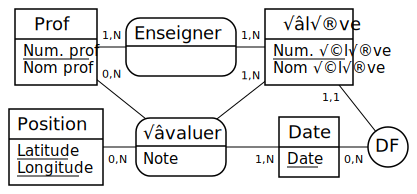

In [95]:
%%mocodo --mld --relations markdown_verbose
Prof: Num. prof, Nom prof
Enseigner, 1N Prof, 1N √âl√®ve
√âl√®ve: Num. √©l√®ve, Nom √©l√®ve

Position: Latitude, _Longitude
√âvaluer, 1N √âl√®ve, 0N Prof, 0N Position, 1N Date: Note
Date: Date
DF, 11 √âl√®ve, 0N Date

Les sorties ¬´¬†verbeuses¬†¬ª en HTML et Markdown expliquent le traitement des champs concern√©s (ci-dessous, √âL√àVE / Date, √âVALUER / Latitude, Longitude et Date) et ajoutent une note de fin justifiant les suppressions (ci-dessous, NB).

In [97]:
display.Markdown("mocodo_notebook/sandbox_verbose.md")

**Enseigner** (<ins>_#Num. prof_</ins>, <ins>_#Num. √©l√®ve_</ins>)  
- Le champ _Num. prof_ fait partie de la cl√© primaire de la table. C'est une cl√© √©trang√®re qui a migr√© directement √† partir de l'entit√© _Prof_.  
- Le champ _Num. √©l√®ve_ fait partie de la cl√© primaire de la table. C'est une cl√© √©trang√®re qui a migr√© directement √† partir de l'entit√© _√âl√®ve_.  

**Prof** (<ins>Num. prof</ins>, Nom prof)  
- Le champ _Num. prof_ constitue la cl√© primaire de la table. C'√©tait d√©j√† un identifiant de l'entit√© _Prof_.  
- Le champ _Nom prof_ √©tait d√©j√† un simple attribut de l'entit√© _Prof_.  

**√âl√®ve** (<ins>Num. √©l√®ve</ins>, Nom √©l√®ve, _#Date_)  
- Le champ _Num. √©l√®ve_ constitue la cl√© primaire de la table. C'√©tait d√©j√† un identifiant de l'entit√© _√âl√®ve_.  
- Le champ _Nom √©l√®ve_ √©tait d√©j√† un simple attribut de l'entit√© _√âl√®ve_.  
- Le champ _Date_ a migr√© par l'association de d√©pendance fonctionnelle _DF_ √† partir de l'entit√© _Date_ en perdant son caract√®re identifiant. De plus, comme la table cr√©√©e √† partir de cette entit√© a √©t√© supprim√©e, il n'est pas consid√©r√© comme cl√© √©trang√®re.  

**√âvaluer** (<ins>_#Num. √©l√®ve_</ins>, <ins>_#Num. prof_</ins>, <ins>_#Latitude_</ins>, <ins>_#Longitude_</ins>, <ins>_#Date_</ins>, Note)  
- Le champ _Num. √©l√®ve_ fait partie de la cl√© primaire de la table. C'est une cl√© √©trang√®re qui a migr√© directement √† partir de l'entit√© _√âl√®ve_.  
- Le champ _Num. prof_ fait partie de la cl√© primaire de la table. C'est une cl√© √©trang√®re qui a migr√© directement √† partir de l'entit√© _Prof_.  
- Les champs _Latitude_ et _Longitude_ font partie de la cl√© primaire de la table. Leur table d'origine (_Position_) ayant √©t√© supprim√©e, ils ne sont pas consid√©r√©s comme cl√©s √©trang√®res.  
- Le champ _Date_ fait partie de la cl√© primaire de la table. Sa table d'origine (_Date_) ayant √©t√© supprim√©e, il n'est pas consid√©r√© comme cl√© √©trang√®re.  
- Le champ _Note_ √©tait d√©j√† un simple attribut de l'association _√âvaluer_.  

---

**NB.** Les tables _Date_ et _Position_ ont √©t√© supprim√©es car elles √©taient r√©duites √† la cl√© primaire de leur entit√© d'origine.

Ce m√©canisme est √©galement devenu d√©brayable. Si l'on souhaite conserver une table ind√©pendante r√©duite √† sa cl√© primaire, on pr√©fixe du signe ¬´¬†+¬†¬ª l'entit√© correspondante (ci-dessous, POSITION). Pour les tables non supprimables, ce pr√©fixe est simplement ignor√© (ci-dessous, PROF).

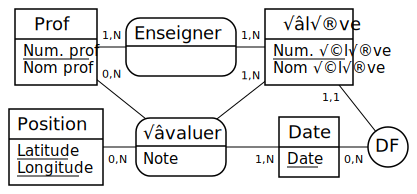

In [98]:
%%mocodo --mld
+Prof: Num. prof, Nom prof
Enseigner, 1N Prof, 1N √âl√®ve
√âl√®ve: Num. √©l√®ve, Nom √©l√®ve

+Position: Latitude, _Longitude
√âvaluer, 1N √âl√®ve, 0N Prof, 0N Position, 1N Date: Note
Date: Date
DF, 11 √âl√®ve, 0N Date

Pour une discussion sur cette probl√©matique, cf. [issue #66](https://github.com/laowantong/mocodo/issues/66).

### Traitement des idenfiants alternatifs

Rappelons que les identifiants alternatifs sont des sous-ensembles d'attributs minimaux assurant l'unicit√© de chacune de leur occurrence, mais non retenus comme identifiant principal.

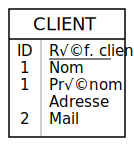

In [96]:
%%mocodo
CLIENT: R√©f. client, 1_Nom, 1_Pr√©nom, Adresse, 2_Mail

Au niveau logique (_i.e._, relationnel), cette contrainte d'unicit√© est sugg√©r√©e visuellement par un exposant¬†:

In [97]:
%%mocodo -c rel
CLIENT: R√©f. client, 1_Nom, 1_Pr√©nom, Adresse, 2_Mail

**CLIENT** (<ins>R√©f. client</ins>, Nom<sup>u1</sup>, Pr√©nom<sup>u1</sup>, Adresse, Mail<sup>u2</sup>)


Au niveau physique (_i.e._, SQL), par l'ajout de contraintes `UNIQUE`¬†:

In [100]:
%%mocodo -c rel:postgresql rel:sqlite quiet
CLIENT: R√©f. client, 1_Nom, 1_Pr√©nom, Adresse, 2_Mail

Voici les deux derni√®res lignes du fichier Postgresql g√©n√©r√©¬†:

In [99]:
display.Code("\n".join(Path("mocodo_notebook/sandbox_postgresql.sql").read_text().splitlines()[-2:]), language="SQL")

ALTER TABLE CLIENT ADD CONSTRAINT client_u1 UNIQUE (nom, pr√©nom);
ALTER TABLE CLIENT ADD CONSTRAINT client_u2 UNIQUE (mail);

Et l'[√©quivalent sous SQLite](https://stackoverflow.com/a/61506734/173003)¬†:

In [88]:
display.Code("\n".join(Path("mocodo_notebook/sandbox_sqlite.sql").read_text().splitlines()[-2:]), language="SQL")

CREATE UNIQUE INDEX "client_u1" ON "CLIENT" ("nom", "pr√©nom");
CREATE UNIQUE INDEX "client_u2" ON "CLIENT" ("mail");

Les identifiants alternatifs non disjoints sont √©galement pris en charge¬†:

In [92]:
%%mocodo --no_mcd -c rel
FOO: foo, 1_bar, 12_biz, 2_buz, 3_qux, 123_quux

**FOO** (<ins>foo</ins>, bar<sup>u1</sup>, biz<sup>u1 u2</sup>, buz<sup>u2</sup>, qux<sup>u3</sup>, quux<sup>u1 u2 u3</sup>)


In [93]:
display.Code("\n".join(Path("mocodo_notebook/sandbox_postgresql.sql").read_text().splitlines()[-3:]), language="SQL")

ALTER TABLE FOO ADD CONSTRAINT foo_u1 UNIQUE (bar, biz, quux);
ALTER TABLE FOO ADD CONSTRAINT foo_u2 UNIQUE (biz, buz, quux);
ALTER TABLE FOO ADD CONSTRAINT foo_u3 UNIQUE (qux, quux);

## Construction de repr√©sentations externes

La repr√©sentation interne peut √™tre d√©riv√©e en repr√©sentation externe par l'application d'une sp√©cification de format, ou **gabarit** (_template_ en anglais). Les sch√©mas relationnels affich√©s au-dessous des diagrammes conceptuels dans la pr√©sente section sont un exemple de sortie au format HTML.

### Gabarits inclus dans la distribution

#### Formats lin√©aires

Dans sa repr√©sentation la plus compacte, un sch√©ma relationnel s'√©crit comme une suite de lignes de la forme:

    RELATION ( cl√©_primaire, attribut_1, attribut_2, ...)

Sauf mention contraire, les MLD affich√©s dans ce document ont √©t√© produits par Mocodo au format HTML. Pour un autre exemple, voici la g√©n√©ration et l'affichage d'une sortie $\mathrm\LaTeX$:

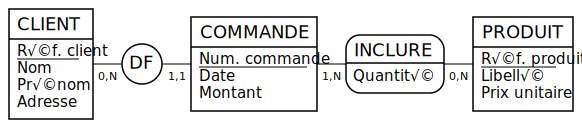

In [104]:
%%mocodo --relations latex
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

In [105]:
display.Code("mocodo_notebook/sandbox.tex")

% Copy this before \begin{document}

\usepackage[normalem]{ulem}
\newenvironment{mld}
  {\par\begin{minipage}{\linewidth}\begin{tabular}{rp{0.7\linewidth}}}
  {\end{tabular}\end{minipage}\par}
\newcommand{\relat}[1]{\textsc{#1}}
\newcommand{\attr}[1]{\emph{#1}}
\newcommand{\prim}[1]{\uline{#1}}
\newcommand{\foreign}[1]{\#\textsl{#1}}

% Copy that after \begin{document}

\begin{mld}
  Client & (\prim{R√©f. client}, \attr{Nom}, \attr{Pr√©nom}, \attr{Adresse})\\
  Commande & (\prim{Num. commande}, \attr{Date}, \attr{Montant}, \foreign{R√©f. client})\\
  Inclure & (\foreign{\prim{Num. commande}}, \foreign{\prim{R√©f. produit}}, \attr{Quantit√©})\\
  Produit & (\prim{R√©f. produit}, \attr{Libell√©}, \attr{Prix unitaire})\\
\end{mld}

Les formats lin√©aires actuellement pris en charge par Mocodo sont les suivants:

| Nom | Argument | Usage du fichier g√©n√©r√© |
|--|--|--|
| [HTML](http://fr.wikipedia.org/wiki/HTML) | html | √Ä ouvrir directement avec un navigateur internet ou un programme de traitement de texte (dont Microsoft Word, OpenOffice, Apple Pages, etc.). Implicite dans un Notebook. |
| [$\mathrm\LaTeX$](http://fr.wikipedia.org/wiki/LaTeX) | latex | √Ä compiler sous $\mathrm\LaTeX$ pour une sortie de haute qualit√© aux formats PDF ou PostScript. |
| [Markdown](http://fr.wikipedia.org/wiki/Markdown) | markdown |  √Ä coller dans une cellule de Notebook, dans un champ textuel de GitHub ou Stack Overflow, ou √† ouvrir avec l'un des nombreux √©diteurs Markdown existants. |
| [Texte brut](http://fr.wikipedia.org/wiki/Fichier_texte) | text | √Ä ouvrir directement avec un √©diteur de texte Unicode. |

#### Formats lin√©aires avec explications

Deux de ces formats, HTML et Markdown, disposent d'une version augment√©e d'explications d√©taill√©es du m√©canisme du passage au relationnel. Ce type de sortie, adaptable par l'enseignant, peut √™tre utile aux √©tudiants qui souhaitent r√©viser ou travailler en autonomie.

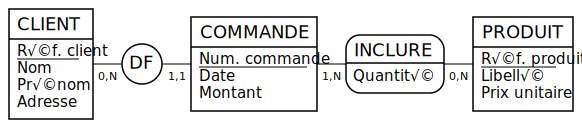

In [106]:
%%mocodo --relations markdown_verbose
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

In [107]:
display.Markdown("mocodo_notebook/sandbox_verbose.md")

**CLIENT** (<ins>R√©f. client</ins>, Nom, Pr√©nom, Adresse)  
- Le champ _R√©f. client_ constitue la cl√© primaire de la table. C'√©tait d√©j√† un identifiant de l'entit√© _CLIENT_.  
- Les champs _Nom_, _Pr√©nom_ et _Adresse_ √©taient d√©j√† de simples attributs de l'entit√© _CLIENT_.  

**COMMANDE** (<ins>Num. commande</ins>, Date, Montant, _#R√©f. client_)  
- Le champ _Num. commande_ constitue la cl√© primaire de la table. C'√©tait d√©j√† un identifiant de l'entit√© _COMMANDE_.  
- Les champs _Date_ et _Montant_ √©taient d√©j√† de simples attributs de l'entit√© _COMMANDE_.  
- Le champ _R√©f. client_ est une cl√© √©trang√®re. Il a migr√© par l'association de d√©pendance fonctionnelle _DF_ √† partir de l'entit√© _CLIENT_ en perdant son caract√®re identifiant.  

**INCLURE** (<ins>_#Num. commande_</ins>, <ins>_#R√©f. produit_</ins>, Quantit√©)  
- Le champ _Num. commande_ fait partie de la cl√© primaire de la table. C'est une cl√© √©trang√®re qui a migr√© directement √† partir de l'entit√© _COMMANDE_.  
- Le champ _R√©f. produit_ fait partie de la cl√© primaire de la table. C'est une cl√© √©trang√®re qui a migr√© directement √† partir de l'entit√© _PRODUIT_.  
- Le champ _Quantit√©_ √©tait d√©j√† un simple attribut de l'association _INCLURE_.  

**PRODUIT** (<ins>R√©f. produit</ins>, Libell√©, Prix unitaire)  
- Le champ _R√©f. produit_ constitue la cl√© primaire de la table. C'√©tait d√©j√† un identifiant de l'entit√© _PRODUIT_.  
- Les champs _Libell√©_ et _Prix unitaire_ √©taient d√©j√† de simples attributs de l'entit√© _PRODUIT_.

Tout ce texte est g√©n√©r√© automatiquement, mais avec des raffinements destin√©s √† le rendre plus lisible pour un humain. Par exemple, les trois attributs non identifiants de l'entit√© CLIENT sont d√©crits en une seule ligne au lieu de trois.

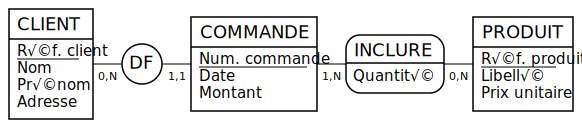

In [108]:
%%mocodo --relations html_verbose
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

In [109]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

**Nouveaut√©s de la version 3.**
- Dans la version HTML du sch√©ma relationnel expliqu√©, les explications sont maintenant divulgu√©es √† la demande (balise `<details>`). Cliquez sur CLIENT pour afficher l'explication.
- √Ä des fins de d√©bogage, le survol d'un champ affiche son type interne √† Mocodo et, √©ventuellement, sa table d'origine. Par exemple, survoler #_R√©f. client_ affiche `foreign_key (CLIENT)`.

#### Diagramme relationnel

La plupart des SGBD offrent une repr√©sentation hybride (graphique / texte) de la base, sous la forme d'un ensemble de tables rectangulaires li√©es par des fl√®ches. Mocodo g√©n√®re un fichier d'extension `.mld` qu'il est capable de reprendre en entr√©e pour tracer ce type de graphe.

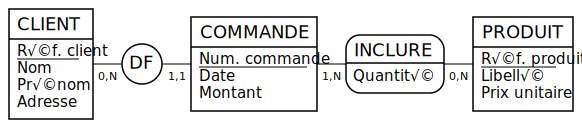

In [110]:
%%mocodo --mld --relations diagram
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

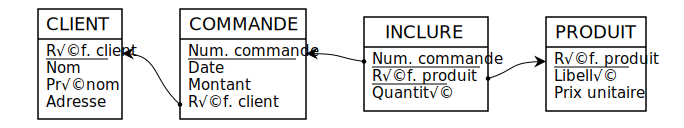

In [111]:
%mocodo --input sandbox.mld

In [112]:
display.Code("mocodo_notebook/sandbox.mld", language="text")

%%mocodo
:
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
:
COMMANDE: Num. commande, Date, Montant, #R√©f. client > CLIENT > R√©f. client
:
INCLURE: #Num. commande > COMMANDE > Num. commande, _#R√©f. produit > PRODUIT > R√©f. produit, Quantit√©
:
PRODUIT: R√©f. produit, Libell√©, Prix unitaire
:

Si l'on ouvre le fichier g√©n√©r√© (_cf._ ci-dessus), on constate que la syntaxe d'un MLD est la m√™me que celle d'un MCD, √† ceci pr√®s que les associations sont remplac√©es par des liens allant de l'attribut `a1` de l'entit√© `E1` √† l'attribut `a2` de l'entit√© `E2`, et qui se notent: `E1: ... a1 > E2 > a2` (nouveaut√© de la version 4.0¬†: les versions pr√©c√©dentes notaient `E1: ... a1->E2->a2`).

Les bo√Ætes invisibles automatiquement ins√©r√©es une colonne sur deux a√®rent le r√©sultat de fa√ßon √† laisser de la place aux fl√®ches.

Remarquons que cette op√©ration est [idempotente](https://fr.wikipedia.org/wiki/Idempotence) pour le MLD¬†:

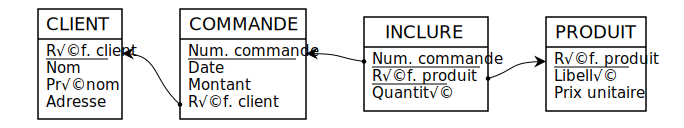

In [113]:
%%mocodo --mld --relations diagram
:
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
:
COMMANDE: Num. commande, Date, Montant, #R√©f. client > CLIENT > R√©f. client
:
INCLURE: #Num. commande > COMMANDE > Num. commande, _#R√©f. produit > PRODUIT > R√©f. produit, Quantit√©
:
PRODUIT: R√©f. produit, Libell√©, Prix unitaire
:

Mais cette fois, comme le ¬´¬†MCD¬†¬ª d'entr√©e ne comporte aucune association, le diagramme relationnel g√©n√©r√© ne comporte aucune fl√®che.

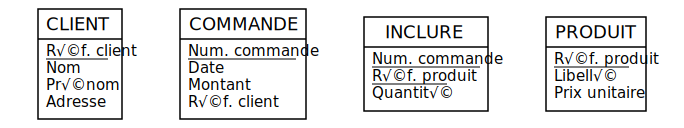

In [114]:
%mocodo --input sandbox.mld

In [115]:
display.Code("mocodo_notebook/sandbox.mld", language="text")

%%mocodo
:
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
:
COMMANDE: Num. commande, Date, Montant, R√©f. client
:
INCLURE: Num. commande, _R√©f. produit, Quantit√©
:
PRODUIT: R√©f. produit, Libell√©, Prix unitaire
:

Le reprendre comme texte d'entr√©e produit donc le m√™me diagramme, mais sans les fl√®ches. Leur r√©tablissement pourrait faire l'objet d'un exercice facile.

Sous _Mocodo online_, vous obtiendrez le premier diagramme relationnel en trois √©tapes:

1. g√©n√©rez les relations correspondant au MCD de d√©part (vous aurez coch√© ¬´¬†diagramme relationnel¬†¬ª dans le menu ¬´¬†Options¬†¬ª);
2. copiez-collez la sortie ¬´¬†diagramme relationnel¬†¬ª √† la place du texte d'entr√©e;
3. reg√©n√©rez les relations.

Les relations sont plac√©es dans le m√™me ordre que les bo√Ætes du MCD d'origine, mais vous devrez souvent les r√©organiser (automatiquement ou manuellement) pour obtenir un r√©sultat plus esth√©tique.

Le diagramme relationnel sans fl√®ches s'obtient en r√©p√©tant les √©tapes 2 et 3.

Les versions successives des diff√©rents fichiers √©tant √©cras√©es √† chaque reg√©n√©ration, veillez √† t√©l√©charger l'archive apr√®s chaque √©tape si vous souhaitez garder l'ensemble.

**Limitation.** Les cl√©s √©trang√®res composites sont actuellement repr√©sent√©es comme si elles √©taient s√©par√©es (autant de fl√®ches que de parties).

#### Sorties SQL

Mocodo est livr√© avec des fichiers de sp√©cification pour les dialectes SQL suivants:

| SGBD | Argument | Suffixe et extension |
|:--|:--|--:|
| [MySQL](https://www.mysql.fr) | `-c rel:mysql` | `"_mysql.sql"` |
| [Oracle](http://oracle.com) | `-c rel:oracle` | `"_oracle.sql"` |
| [PostgreSQL](http://postgresql.org) | `-c rel:postgresql` | `"_postgresql.sql"` |
| [SQLite](http://sqlite.org) | `-c rel:sqlite` | `"_sqlite.sql"` |

Notez que les contraintes de cl√©s √©trang√®res sont ajout√©es **apr√®s** cr√©ation de l'ensemble des tables, sauf pour SQLite, qui n'impose pas d'ordre de cr√©ation sp√©cifique, et qui de toute fa√ßon ne prend pas en charge ce type d'alt√©ration _a posteriori_.

Le type de donn√©es peut √™tre ins√©r√© entre crochets droits apr√®s chaque attribut:

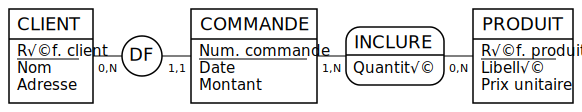

In [116]:
%%mocodo --title=client_commande_produit --relations mysql
CLIENT: R√©f. client [varchar(8)], Nom [varchar(20)], Adresse [varchar(40)]
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande [tinyint(4)], Date [date], Montant [decimal(5,2) DEFAULT '0.00']
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√© [tinyint(4)]
PRODUIT: R√©f. produit [varchar(8)], Libell√© [varchar(20)], Prix unitaire [decimal(5,2)]

Quoique ces informations suppl√©mentaires ne soient pas apparues dans le diagramme conceptuel, elles ont √©t√© exploit√©es par la commande, qui a produit dans le r√©pertoire `mocodo_notebook` un fichier directement ex√©cutable par MySQL:

In [117]:
display.Code(filename="mocodo_notebook/sandbox_mysql.sql", language="mysql")

CREATE DATABASE IF NOT EXISTS `CLIENT_COMMANDE_PRODUIT`;
USE `CLIENT_COMMANDE_PRODUIT`;

CREATE TABLE `CLIENT` (
  `r√©f_client` varchar(8),
  `nom` varchar(20),
  `adresse` varchar(40),
  PRIMARY KEY (`r√©f_client`)
) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4;

CREATE TABLE `COMMANDE` (
  `num_commande` tinyint(4),
  `date` date,
  `montant` decimal(5,2) DEFAULT '0.00',
  `r√©f_client` varchar(8),
  PRIMARY KEY (`num_commande`)
) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4;

CREATE TABLE `INCLURE` (
  `num_commande` tinyint(4),
  `r√©f_produit` varchar(8),
  `quantit√©` tinyint(4),
  PRIMARY KEY (`num_commande`, `r√©f_produit`)
) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4;

CREATE TABLE `PRODUIT` (
  `r√©f_produit` varchar(8),
  `libell√©` varchar(20),
  `prix_unitaire` decimal(5,2),
  PRIMARY KEY (`r√©f_produit`)
) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4;

ALTER TABLE `COMMANDE` ADD FOREIGN KEY (`r√©f_client`) REFERENCES `CLIENT` (`r√©f_client`);
ALTER TABLE `INCLURE` ADD FOREIGN KEY (`r√©f_produit`) REFERENCES `PRODUIT` (`r√©f_produit`);
ALTER TABLE `INCLURE` ADD FOREIGN KEY (`num_commande`) REFERENCES `COMMANDE` (`num_commande`);

**Nouveaut√© de la version 2.0.17.** Les cl√©s √©trang√®res composites sont g√©r√©es (cf. [issue 14](https://github.com/laowantong/mocodo/issues/14)) et les types manquants remplac√©s par `VARCHAR(`[`42`](https://fr.wikipedia.org/wiki/La_grande_question_sur_la_vie,_l%27univers_et_le_reste)):

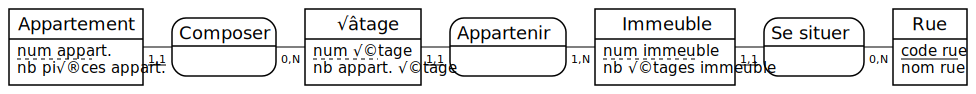

In [118]:
%%mocodo --title=appartements --relations sqlite
Appartement: num appart., nb pi√®ces appart.
Composer, 0N √âtage, _11 Appartement
√âtage: num √©tage, nb appart. √©tage
Appartenir, 1N Immeuble, _11 √âtage
Immeuble: num immeuble, nb √©tages immeuble
Se situer, 0N Rue, _11 Immeuble
Rue: code rue, nom rue

In [119]:
display.Code("mocodo_notebook/sandbox_sqlite.sql")

.open "APPARTEMENTS";

CREATE TABLE "APPARTEMENT" (
  "code_rue" VARCHAR(42),
  "num_immeuble" VARCHAR(42),
  "num_√©tage" VARCHAR(42),
  "num_appart" VARCHAR(42),
  "nb_pi√®ces_appart" VARCHAR(42),
  PRIMARY KEY ("code_rue", "num_immeuble", "num_√©tage", "num_appart"),
  FOREIGN KEY ("code_rue", "num_immeuble", "num_√©tage") REFERENCES "√âTAGE" ("code_rue", "num_immeuble", "num_√©tage")
);

CREATE TABLE "IMMEUBLE" (
  "code_rue" VARCHAR(42),
  "num_immeuble" VARCHAR(42),
  "nb_√©tages_immeuble" VARCHAR(42),
  PRIMARY KEY ("code_rue", "num_immeuble"),
  FOREIGN KEY ("code_rue") REFERENCES "RUE" ("code_rue")
);

CREATE TABLE "RUE" (
  "code_rue" VARCHAR(42),
  "nom_rue" VARCHAR(42),
  PRIMARY KEY ("code_rue")
);

CREATE TABLE "√âTAGE" (
  "code_rue" VARCHAR(42),
  "num_immeuble" VARCHAR(42),
  "num_√©tage" VARCHAR(42),
  "nb_appart_√©tage" VARCHAR(42),
  PRIMARY KEY ("code_rue", "num_immeuble", "num_√©tage"),
  FOREIGN KEY ("code_rue", "num_immeuble") REFERENCES "IMMEUBLE" ("code_rue", "num_immeuble")
);

#### Graphe des d√©pendances

**Nouveaut√© de la version 3.1.** On dit que la table A **d√©pend** de la table B lorsque A poss√®de une cl√© √©trang√®re qui est cl√© primaire de B. Mocodo peut d√©sormais g√©n√©rer un graphe des d√©pendances au format Graphviz. Consid√©rons par exemple le MCD suivant¬†:

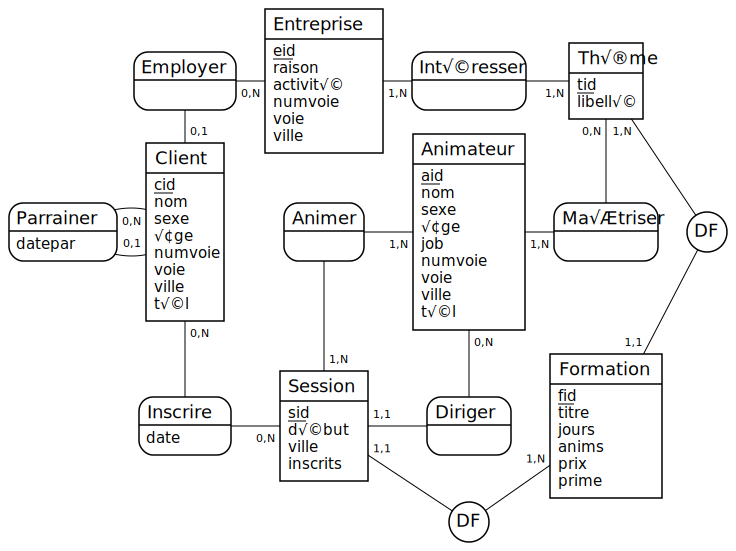

In [422]:
%%mocodo
:
Employer, 01 Client, 0N Entreprise
Entreprise: eid, raison, activit√©, numvoie, voie, ville
Int√©resser, 1N Entreprise, 1N Th√®me
Th√®me: tid, libell√©
:
    
Parrainer, 01 Client, 0N Client: datepar
Client: cid, nom, sexe, √¢ge, numvoie, voie, ville, t√©l
Animer, 1N Session, 1N Animateur
Animateur: aid, nom, sexe, √¢ge, job, numvoie, voie, ville, t√©l
Ma√Ætriser, 1N Animateur, 0N Th√®me
DF, 11 Formation, 1N Th√®me

:
Inscrire, 0N Client, 0N Session: date
Session: sid, d√©but, ville, inscrits
Diriger, 11 Session, 0N Animateur
Formation: fid, titre, jours, anims, prix, prime
:

:::
DF, 11 Session, 1N Formation
::

Supposons que l'on doive importer la base de donn√©es correspondante √† partir d'un ensemble de fichiers CSV (ou autres). Si l'on veut √©viter de d√©sactiver tous les contr√¥les de cl√©s √©trang√®res (en faisant, p. ex. sous MySQL, `SET FOREIGN_KEY_CHECKS = 0`), il conviendra de lire ces fichiers dans un [ordre topologique](https://fr.wikipedia.org/wiki/Tri_topologique) quelconque. Mocodo peut g√©n√©rer un graphe des d√©pendances qui met cet ordre en √©vidence¬†:

In [423]:
%mocodo --input sandbox -c rel:dependencies defer:svg --no_mcd

M√™me si notre graphe des d√©pendances n'est pas forc√©ment un  [graphes sans circuits](https://fr.wikipedia.org/wiki/Graphe_orient√©_acyclique) (ici, p. ex., il y a une boucle de CLIENT √† CLIENT), remplir les tables de gauche √† droite et de haut en bas (Th√®me, Entreprise, Animateur, Formation, etc.) minimisera le recours √† la d√©sactivation des contraintes de cl√©s √©trang√®res.

### Modification ou cr√©ation de nouveaux gabarits

L'algorithme de g√©n√©ration d'une sortie dans tel ou tel format est totalement d√©coupl√© de son entr√©e. Cela signifie que vous pouvez modifier ou cr√©er un format sans √©crire une seule ligne de code, mais en remplissant une esp√®ce de formulaire, ou gabarit, qui est un simple fichier JSON. Si vous n'avez aucune vell√©it√© de le faire, vous pouvez sauter cette section. Sinon, accrochez-vous, √ßa va devenir un peu technique.

#### Algorithme

Pour apprendre √† sp√©cifier un format, le mieux est d'√©tudier les gabarits livr√©s dans le dossier `relation_templates`. Les quelques indications donn√©es ici devraient suffire √† vous √©pargner la lecture du code proprement dit.

Chaque gabarit est un fichier JSON associant des cl√©s pr√©d√©finies √† des valeurs librement modifiables. Dans sa forme la plus simple, √† savoir le format ¬´¬†texte brut¬†¬ª, le fichier (`text.json`) se r√©duit √† trois lignes:

```json
{
  "extension": ".txt"
}
```

La cl√© `"extension"` est en effet la seule cl√© obligatoire d'un tel fichier. Ici, elle est associ√©e √† la valeur `".txt"`.

Les autres cl√©s possibles, toutes facultatives, appartiennent √† quatre cat√©gories:

| Cat√©gorie | Forme de la cl√© | Valeur associ√©e | Description |
|--|--|--|--|
| Transformation | `"transform_..."` | objet | Op√®re une recherche-remplacement, √©ventuellement it√©r√©e (jusqu'√† ce qu'aucun remplacement ne soit plus possible), sur une partie du texte d√©j√† g√©n√©r√©. Les champs `"search"` et `"replace`" sont obligatoires, le champ `"iterated"` (bool√©en) est facultatif. La syntaxe est celle des [expressions r√©guli√®res de Python](https://docs.python.org/3/library/re.html#regular-expression-syntax). |
| Composition | `"compose_..."` | cha√Æne de format | Interpole dans une cha√Æne certains identificateurs pr√©d√©finis par une valeur d√©pendant du contexte en cours. La syntaxe est celle utilis√©e par la [m√©thode `.format()` de Python](https://docs.python.org/3/library/string.html#format-string-syntax). |
| Concat√©nation | `"..._separator"` | cha√Æne | Concat√®ne une liste de cha√Ænes en les s√©parant par une cha√Æne donn√©e. |
| cl√© de tri | `"..._sorting_key"` | objet | Extrait la cl√© de tri pour la liste concern√©e. L'expression r√©guli√®re `"search"` contient une ou des parenth√®ses capturantes qui sont ensuite rappel√©es dans l'expression `"replace"` |

Voici les diff√©rentes op√©rations effectu√©es par l'algorithme, dans l'ordre de son d√©roulement:

1. Toutes les cl√©s absentes du gabarit sont ajout√©es, avec des valeurs par d√©faut pertinentes.
2. `"transform_attribute"` applique une premi√®re transformation √† chaque attribut (identificateur `attribute`). Il s'agit en g√©n√©ral de supprimer ou remplacer les caract√®res interdits par le format-cible. Le r√©sultat est r√©f√©renc√© par un nouvel identificateur, appel√© `"raw_label"`.
3. Diff√©rentes capitalisations de ce libell√© sont ajout√©es sous les noms de `"raw_label_lowercase"` (minuscules),  `"raw_label_uppercase"` (majuscules) et  `"raw_label_titlecase"` (majuscules initiales).
4. `"compose_label_disambiguated_by_note"` cr√©e sous le nom de `"label"` une copie de `"raw_label"`, en introduisant en plus dans les cl√©s √©trang√®res les notes des pattes correspondantes. La valeur par d√©faut est `"{raw_label} {leg_note}"`, mais pour plus de libert√© on peut tr√®s bien imaginer de remplacer le label par l'note elle-m√™me (avec `"{leg_note}"`). Cette composition est optionnelle: pour la d√©sactiver, passer l'option `disambiguation=numbers_only`.
4. <a id='disambiguation_by_number'></a>`"compose_label_disambiguated_by_number"` diff√©rencie les libell√©s homonymes d'une m√™me relation en leur ajoutant un num√©ro. Par exemple, et c'est la valeur par d√©faut, pour suffixer le libell√© par un point suivi de ce num√©ro, on √©crira: `"{label}.{disambiguation_number}"`. L'identificateur `"label"` est mis √† jour avec le r√©sultat. C'est lui que l'utilisateur utilisera en g√©n√©ral dans la suite de l'algorithme, mais il a encore acc√®s aux variantes pr√©c√©dentes.
5. Diff√©rentes capitalisations de ce libell√© sont ajout√©es: `"label_lowercase"`, `"label_uppercase"` et  `"label_titlecase"`.
6. `"transform_title"` re√ßoit le nom du MCD. Le r√©sultat et ses capitalisations sont associ√©s aux identificateurs `"title"`, `"title_lowercase"`, `"title_uppercase"` et  `"title_titlecase"`.
7. Ensuite, pour chacune des relations cr√©√©es dans la repr√©sentation interne:

  1. `"transform_relation_name"` applique une transformation au nom de la relation et l'associe, avec ses capitalisations, aux identificateurs `"this_relation_name"`, `"this_relation_name_lowercase"`, `"this_relation_name_uppercase"` et  `"this_relation_name_titlecase"`.
  2. Le num√©ro d'ordre de la relation est associ√© √† l'identificateur `"this_relation_number"`.
  3. Pour chaque colonne de la relation en cours:

    1. Si l'attribut a migr√© depuis une entit√©, le nom de la relation correspondante est associ√©, avec ses capitalisations, aux identificateurs `"primary_relation_name"`, `"primary_relation_name_lowercase"`, `"primary_relation_name_uppercase"` et  `"primary_relation_name_titlecase"`. Dans le cas contraire, tous ces identificateurs sont associ√©s √† la cha√Æne vide.
    2. Si l'attribut a migr√© par une association, le nom de celle-ci est associ√©, avec ses capitalisations, aux identificateurs `"association_name"`, `"association_name_lowercase"`, `"association_name_uppercase"` et  `"association_name_titlecase"`. Dans le cas contraire, tous ces identificateurs sont associ√©s √† la cha√Æne vide.
    3. la composition `"compose_[attribute_nature]"` est appliqu√©e, _cf._ le paragraphe [Composition des attributs selon leur nature](#Composition-des-attributs-selon-leur-nature). Le r√©sultat est accumul√© dans une liste de colonnes, en deux versions: dans l'ordre de leur √©num√©ration, ou tri√©e selon la cl√© sp√©cifi√©e dans `"column_sorting_key"`.
  4. `"column_separator"` joint chacune de ces listes de cha√Ænes et associe le r√©sultat √† l'identificateur `"columns"` et `"sorted_columns"` (respectivement).
  5. `"compose_relation"` construit une relation compl√®te avec tous ses attributs. Par exemple, et c'est la valeur par d√©faut, `"{this_relation_name} ({columns})"` est utilis√© dans les [formats lin√©aires](#Formats-lin%C3%A9aires).
  6. `"transform_forced_relation"` est appliqu√© aux associations DF dont la conversion en table a √©t√© forc√©e manuellement.
  7. `"transform_relation"` est appliqu√© syst√©matiquement, et le r√©sultat est accumul√© dans une liste de relations, en deux versions: dans l'ordre de leur √©num√©ration, ou tri√©e selon la cl√© sp√©cifi√©e dans `"relation_sorting_key"`.
8. `"relation_separator"` joint chacune de ces listes de cha√Ænes et associe le r√©sultat √† l'identificateur `"relations"` et `"sorted_relations"` (respectivement).
9. `"compose_relational_schema"` construit un sch√©ma relationnel complet avec son titre et toutes ses relations. La valeur par d√©faut est simplement `"{relations}"`.
10. `"transform_relational_schema"` applique une derni√®re transformation au sch√©ma complet, et renvoie le r√©sultat final.

#### Identificateurs disponibles pour la composition de cha√Ænes

Mocodo _offline_ est livr√© avec un gabarit sp√©cialement con√ßu pour vous aider √† en cr√©er de nouveaux. Il vous permet de tester sur n'importe quel MCD la g√©n√©ration d'un objet JSON contenant la valeur de tous les identificateurs disponibles pour la composition au niveau de chaque attribut.

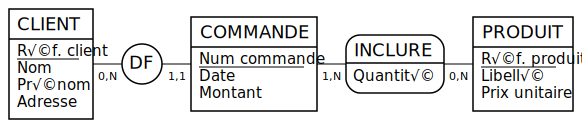

In [153]:
%%mocodo --title client_commande_produit --relations json
CLIENT: R√©f. client, Nom, Pr√©nom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√©
PRODUIT: R√©f. produit, Libell√©, Prix unitaire

Le contexte d'un attribut donne acc√®s √† 32 identificateurs:

- 4 sp√©cifiques √† la base;
- 5 sp√©cifiques √† la relation;
- 23 sp√©cifiques √† l'attribut.

S'y ajoutent `"columns"`, `"sorted_columns"`, et `"relations"`, `"sorted_relations"`, qui n'ont de sens que dans le contexte de `"compose_relation"` et `"compose_relational_schema"`(respectivement).

Le fichier JSON est trop long pour √™tre list√© dans son int√©gralit√© ici, mais en voici le d√©but, qui concerne la cl√© primaire _R√©f. client_ de la relation _Client_ de la base _client_commande_produit_.

In [154]:
display.Code("mocodo_notebook/sandbox.json")

{
  "title": "client_commande_produit",
  "title_lowercase": "client_commande_produit",
  "title_uppercase": "CLIENT_COMMANDE_PRODUIT",
  "title_titlecase": "Client_commande_produit",
  "relations": [
    {
      "this_relation_name": "CLIENT",
      "this_relation_name_lowercase": "client",
      "this_relation_name_uppercase": "CLIENT",
      "this_relation_name_titlecase": "Client",
      "is_forced": "False",
      "columns": [
        {
          "attribute": "R√©f. client",
          "raw_label": "R√©f. client",
          "raw_label_lowercase": "r√©f. client",
          "raw_label_uppercase": "R√âF. CLIENT",
          "raw_label_titlecase": "R√©f. client",
          "disambiguation_number": null,
          "label": "R√©f. client",
          "label_lowercase": "r√©f. client",
          "label_uppercase": "R√âF. CLIENT",
          "label_titlecase": "R√©f. client",
          "primary": true,
          "nature": "primary_key",
          "data_type": null,
          "association_name": null,
          "association_name_lower_case": null,
          "association_name_uppercase": null,
          "association_name_titlecase": null,
          "leg_note": null,
          "outer_source": null,
          "outer_source_lowercase": null,
          "outer_source_uppercase": null,
          "outer_source_titlecase": null
        },
        {
          "attribute": "Nom",
          "raw_label": "Nom",
          "raw_label_lowercase": "nom",
          "raw_label_uppercase": "NOM",
          "raw_label_titlecase": "Nom",
          "disambiguation_number": null,
          "label": "Nom",
          "label_lowercase": "nom",
          "label_uppercase": "NOM",
          "label_titlecase": "Nom",
          "primary": false,
          "nature": "normal_attribute",
          "data_type": null,
          "association_name": null,
          "association_name_lower_case": null,
          "association_name_uppercase": null,
          "association_name_titlecase": null,
          "leg_note": null,
          "outer_source": null,
          "outer_source_lowercase": null,
          "outer_source_uppercase": null,
          "outer_source_titlecase": null
        },
        {
          "attribute": "Pr√©nom",
          "raw_label": "Pr√©nom",
          "raw_label_lowercase": "pr√©nom",
          "raw_label_uppercase": "PR√âNOM",
          "raw_label_titlecase": "Pr√©nom",
          "disambiguation_number": null,
          "label": "Pr√©nom",
          "label_lowercase": "pr√©nom",
          "label_uppercase": "PR√âNOM",
          "label_titlecase": "Pr√©nom",
          "primary": false,
          "nature": "normal_attribute",
          "data_type": null,
          "association_name": null,
          "association_name_lower_case": null,
          "association_name_uppercase": null,
          "association_name_titlecase": null,
          "leg_note": null,
          "outer_source": null,
          "outer_source_lowercase": null,
          "outer_source_uppercase": null,
          "outer_source_titlecase": null
        },
        {
          "attribute": "Adresse",
          "raw_label": "Adresse",
          "raw_label_lowercase": "adresse",
          "raw_label_uppercase": "ADRESSE",
          "raw_label_titlecase": "Adresse",
          "disambiguation_number": null,
          "label": "Adresse",
          "label_lowercase": "adresse",
          "label_uppercase": "ADRESSE",
          "label_titlecase": "Adresse",
          "primary": false,
          "nature": "normal_attribute",
          "data_type": null,
          "association_name": null,
          "association_name_lower_case": null,
          "association_name_uppercase": null,
          "association_name_titlecase": null,
          "leg_note": null,
          "outer_source": null,
          "outer_source_lowercase": null,
          "outer_source_uppercase": null,
          "outer_source_titlecase": null
        }
      ]
    },
    {
      "this_relation_name": "COMMANDE",
      "this_relation_name

Ce fragment est √† premi√®re vue tr√®s redondant. En cas de doute, reportez-vous aux tests `relations_tests.py` dans le code-source pour un √©ventail de cas discriminants.

#### Composition des attributs selon leur nature

**Avertissement.** Cette section d√©crit la version 2 et n'a pas √©t√© compl√©t√©e pour Mocodo 3.

La composition appliqu√©e √† un attribut est au c≈ìur de la construction d'une repr√©sentation externe. √Ä cette √©tape, la repr√©sentation interne a permis de distinguer 9 cat√©gories d'attributs, 6 courantes et 3 exceptionnelles. Avant de pouvoir exploiter cette classification, il faut la comprendre en d√©tail. Nous allons la pr√©senter √† travers deux exemples, le premier r√©pertoriant tous les cas courants, le second tous les cas exceptionnels.

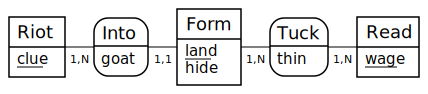

In [155]:
%%mocodo --relations html_verbose
Riot: clue
Into, 11 Form, 1N Riot: goat
Form: land, hide
Tuck, 1N Read, 1N Form: thin
Read: wage

In [156]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

| Identificateur | Attribut concern√© | D√©faut | Exemple | 
|--|--|--|--|
| `compose_primary_key` | identifiant rest√© sur place lors de la transformation d'une entit√© en table | `"_{label}_"` | _land_ de **Form** |
| `compose_normal_attribute` | simple attribut rest√© sur place lors de la transformation d'une entit√© en table | `"{label}"` | _hide_ de **Form** |
| `compose_foreign_key` | cl√© √©trang√®re ayant migr√© par une d√©pendance fonctionnelle disparue, tout en perdant son caract√®re identifiant | `"#{label}"` | _clue_ de **Form** |
| `compose_foreign_attribute` | attribut √©tranger ayant migr√© d'une d√©pendance fonctionnelle disparue | m√™me valeur que `compose_normal_attribute` | _goat_ de **Form** |
| `compose_foreign_primary_key` | cl√© √©trang√®re primaire migr√© dans une association devenue table, tout en gardant son caract√®re identifiant  | `"_#{label}_"` | _wage_ et _land_ de **Tuck** |
| `compose_association_attribute` | simple attribut rest√© sur place lors de la transformation d'une association en table | m√™me valeur que `compose_normal_attribute` | _thin_ de **Tuck** |

In [105]:
%%mocodo -c rel:html_verbose
Riot: clue
Walk, 1N Riot, _11 Hour
Hour: book
Poll, 1N Cast, /1N Hour
Cast: mere
+Army, 11 Busy, 01 Cast
Busy: fail

In [158]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

| Identificateur | Attribut concern√© | D√©faut | Exemple | 
|----------------|-------------------|--------|---------|
| `compose_strengthening_primary_key` | cl√© primaire de renforcement d'une entit√© faible | m√™me valeur que `compose_foreign_primary_key` | _clue_ de **Hour** |
| `compose_demoted_foreign_key` | cl√© √©trang√®re ayant migr√© dans une association devenue table, mais r√©trograd√©e explicitement au rang de simple attribut | m√™me valeur que `compose_foreign_key` | _book_ et _clue_ de **Poll** |
| `compose_primary_foreign_key` | cl√© √©trang√®re non primaire ayant migr√© dans une d√©pendance fonctionnelle explicitement promue au rang de table |  | _fail_ et _mere_ de **Army** |

#### Gabarit vide

Voici pour r√©f√©rence un gabarit JSON pr√™t √† l'emploi, √† partir duquel vous pourrez cr√©er les v√¥tres. Il comporte l'int√©gralit√© des identificateurs disponibles, avec leur valeur par d√©faut et dans l'ordre de d√©roulement de l'algorithme:

```
{
    "extension": "requis: pas de valeur par d√©faut",
    "transform_attribute": [],
    "transform_title": [],
    "transform_data_type": [],
    "compose_label_disambiguated_by_note": "{raw_label} {leg_note}",
    "compose_label_disambiguated_by_number": "{label}.{disambiguation_number}",
    "compose_primary_key": "_{label}_",
    "compose_normal_attribute": "{label}",
    "compose_foreign_key": "#{label}",
    "compose_foreign_attribute": "par d√©faut, m√™me valeur que compose_normal_attribute",
    "compose_foreign_primary_key": "_#{label}_",
    "compose_association_attribute": "par d√©faut, m√™me valeur que compose_normal_attribute",
    "compose_strengthening_primary_key": "par d√©faut, m√™me valeur que compose_foreign_primary_key",
    "compose_demoted_foreign_key": "par d√©faut, m√™me valeur que compose_foreign_key",
    "compose_promoting_foreign_key": "par d√©faut, m√™me valeur que compose_foreign_key",
    "transform_relation_name": [],
    "column_sorting_key": {
        "search": "(.+)",
        "replace": "\\1"
    },
    "column_separator": ", ",
    "compose_relation": "{this_relation_name} ({columns})",
    "transform_forced_relation": [],
    "transform_relation": [],
    "relation_sorting_key": {
        "search": "(.+)",
        "replace": "\\1"
    },
    "relation_separator": "\n",
    "compose_relational_schema": "{relations}",
    "transform_relational_schema": []
}
```

#### D√©rivation de gabarits

**Nouveaut√© de la version 3.1.** Il est maintenant possible de d√©finir un gabarit d√©riv√© d'un autre (qui lui-m√™me peut d√©river d'un autre, etc.). La distribution inclut, √† titre d'exemple, le gabarit d√©riv√© de `latex.json` suivant¬†:

In [81]:
path = Path("../mocodo/resources/relation_templates/latex_barebones.json")
display.Markdown(f"```json\n{path.read_text()}\n```")

```json
{
    "parent": "latex",
    "compose_relational_schema": "\\begin{{mld}}\n{relations}\n\\end{{mld}}"
}

```

- La cl√© `"parent"` donne le chemin ou le nom du gabarit dont on souhaite cr√©er une version d√©riv√©e¬†:
    - une cha√Æne termin√©e par `.json` est interpr√©t√©e comme un chemin¬†;
    - sinon, comme le nom d'un gabarit de la distribution.
- Les autres cl√©s sont facultatives. Ici, on red√©finit simplement le `"compose_relational_schema"` de `latex.json`.

Le m√©canisme de d√©rivation d√©pend de la scalarit√© de la valeur associ√©e aux cl√©s.

**Cas scalaire.**

Pour les valeurs scalaires¬†(cha√Ænes, nombres, bool√©ens, `null`), selon la pr√©sence d'une entr√©e donn√©e dans le gabarit enfant et/ou le gabarit parent, l'association cl√©-valeur correspondante sera cr√©√©e, mise √† jour ou conserv√©e¬†:

| enfant | parent | r√©sultat     |
|--------|--------|--------------|
| oui    | non    | cr√©ation     |
| oui    | oui    | mise √† jour  |
| non    | oui    | conservation |

Il n'y a pas de moyen de supprimer une association cl√©-valeur, mais √©tant donn√© que toutes celles qui sont absentes se voient substituer une association par d√©faut, il est √©quivalent de sp√©cifier explicitement la valeur-d√©faut.

**Cas non scalaire.**

Dans les gabarits de relations de Mocodo, une seule cat√©gorie de valeur non scalaire est possible¬†: la liste de dictionnaires. En voici un exemple extrait du gabarit `html.json`¬†:

```json
  "transform_attribute": [
    {
      "order": 100,
      "search": "&",
      "replace": "&amp;"
    },
    {
      "order": 200,
      "search": ">",
      "replace": "&gt;"
    },
    {
      "order": 300,
      "search": "<",
      "replace": "&lt;"
    }
  ],
```

Dans la version 3.1, une cl√© `"order"` incr√©ment√©e par pas de 100 a √©t√© ajout√©e syst√©matiquement √† chacun des dictionnaires de la liste. Selon la pr√©sence d'un dictionnaire de num√©ro d'ordre donn√© dans le gabarit enfant et/ou le gabarit parent, ce dictionnaire sera ins√©r√©, supprim√©, mis √† jour ou conserv√© :

| enfant | parent | r√©sultat     |
|--------|--------|--------------|
| oui    | non    | insertion    |
| oui    | oui    | s'il y a une seule cl√©¬†: suppression<br> s'il y a plusieurs cl√©s¬†: [mise √† jour](https://docs.python.org/3/library/stdtypes.html#dict.update) |
| non    | oui    | conservation |

**Remarque.** Le pas de 100 a √©t√© choisi de fa√ßon √† permettre √† l'utilisateur d'ins√©rer un nombre suffisant de dictionnaires entre deux dictionnaires existants, tout en apportant un certain nombre de garanties. Ainsi, si l'un des gabarits de la distribution devait changer lors d'une mise √† jour de Mocodo¬†:

- les dictionnaires pr√©serv√©s ou modifi√©s garderont leur num√©ro d'ordre¬†;
- les dictionnaires ins√©r√©s le seront avec des num√©ros d'ordre divisibles par 10 r√©partis uniform√©ment (p. ex., si quatre dictionnaires sont ins√©r√©s entre 100 et 200, leurs num√©ro d'ordre seront 120, 140, 150, 170)¬†: il est donc conseill√© √† l'utilisateur d'ins√©rer les siens en les ¬´¬†collant¬†¬ª √† des num√©ros divisibles par 10 (p. ex., 101 ou 199 pour une insertion entre 100 et 200)¬†;
- les dictionnaires supprim√©s laisseront un ¬´¬†trou¬†¬ª dans la num√©rotation.

Pour des exemples, cf. `test/test_read_template.py` et le dossier `test/test_data/templates`. Pour une discussion sur cette probl√©matique, cf. [issue #67](https://github.com/laowantong/mocodo/issues/67).

# Autres conversions

## √Ä partir du niveau conceptuel

### Sous-produits divers

#### Dictionnaire des donn√©es

Il est possible d'exporter un tableau au format Markdown (sous-sous-option `md`) ou TSV (`tsv` par d√©faut) avec diverses informations sur les attributs. On pr√©cise en sous-sous-option tout ou partie des colonnes suivantes dans l'ordre o√π on les veut¬†:

- `label`: le libell√© de l'attribut¬†;
- `type`¬†: son type ou un descriptif (auquel cas il conviendra de changer le nom de la colonne)¬†;
- `box`¬†: le nom de l'entit√© ou association o√π il se trouve.

Entourez ces noms de colonnes de balises Markdown pour les mettre en forme (pas d'incidence en TSV). Faites-les suivre de `="Nom de colonne personnalis√©"` pour √©viter la valeur par d√©faut (d√©pendante de l'option `language`)¬†:

In [94]:
%%mocodo -c data_dict:md,**box**="Entit√© ou association",label,`type`=`Type`
Client: r√©f. client [varchar(8)], nom [varchar(20)], adresse [varchar(40)]
DF, 0N Client, 11 Commande
Commande: num commande [tinyint(4)], date [date], montant [decimal(5,2) DEFAULT '0.00']
Inclure, 1N Commande, 0N Produit: quantit√© [tinyint(4)]
Produit: r√©f. produit [varchar(8)], libell√© [varchar(20)], prix unitaire [decimal(5,2)]

| Entit√© ou association | Libell√© de l'attribut | `Type` |
|:---|:---|:---|
| **Client** | adresse | `varchar(40)` |
| **"** | nom | `varchar(20)` |
| **"** | r√©f. client | `varchar(8)` |
| **Commande** | date | `date` |
| **"** | montant | `decimal(5,2) DEFAULT '0.00'` |
| **"** | num commande | `tinyint(4)` |
| **Inclure** | quantit√© | `tinyint(4)` |
| **Produit** | libell√© | `varchar(20)` |
| **"** | prix unitaire | `decimal(5,2)` |
| **"** | r√©f. produit | `varchar(8)` |


- Au format Markdown (mais pas en TSV) les cellules r√©p√©t√©es de la premi√®re colonne sont remplac√©es par un guillemet.
- Le tableau est automatiquement tri√© selon sa premi√®re, puis √©ventuellement deuxi√®me et troisi√®me colonnes.
- Si une seule colonne est demand√©e, la ligne d'en-t√™te n'est pas g√©n√©r√©e et, en Markdown, c'est une liste qui est produite.

In [95]:
%%mocodo -c data_dict:md,label
Client: r√©f. client [varchar(8)], nom [varchar(20)], adresse [varchar(40)]
DF, 0N Client, 11 Commande
Commande: num commande [tinyint(4)], date [date], montant [decimal(5,2) DEFAULT '0.00']
Inclure, 1N Commande, 0N Produit: quantit√© [tinyint(4)]
Produit: r√©f. produit [varchar(8)], libell√© [varchar(20)], prix unitaire [decimal(5,2)]

- adresse
- date
- libell√©
- montant
- nom
- num commande
- prix unitaire
- quantit√©
- r√©f. client
- r√©f. produit


TODO: Avant la version 4.0, la sous-option `markdown_data_dict`

### _Entity-relationship diagrams_

**Nouveaut√© de la version 4.0.** Force est de reconna√Ætre que de nos jours, les MCD √† la sauce Merise ne sont plus go√ªt√©s que par une poign√©e d'irr√©ductibles Gaulois (et contractuellement leurs √©tudiants). Dans le cadre de son projet secret de domination plan√©taire, Mocodo commence √† faire du pied √† des notations plus populaires, √† commencer par celle introduite en 1976 par Gordon Everest sous le doux nom de _crow's foot_.

#### ERD √† pattes de corbeau

In [99]:
%%mocodo -c crow defer:svg --colors=mondrian --seed=3
CLIENT: R√©f. client [VARCHAR(8)], Nom [VARCHAR(255)], Pr√©nom [VARCHAR(255)], Adresse [VARCHAR(255)]
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande [VARCHAR(8)], Date [DATE], Montant [DECIMAL(10,2)]
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√© [INTEGER]
PRODUIT: R√©f. produit [VARCHAR(8)], Libell√© [VARCHAR(255)], Prix unitaire [DECIMAL(10,2)]

Par d√©faut, la sous-option `crow` g√©n√®re un fichier Graphviz, qui est pour ainsi dire un format ¬´¬†terminal¬†¬ª. Alternativement, on peut demander le format Mermaid¬†:

In [100]:
%%mocodo -c crow:mmd defer:svg
CLIENT: R√©f. client [VARCHAR(8)], Nom [VARCHAR(255)], Pr√©nom [VARCHAR(255)], Adresse [VARCHAR(255)]
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande [VARCHAR(8)], Date [DATE], Montant [DECIMAL(10,2)]
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√© [INTEGER]
PRODUIT: R√©f. produit [VARCHAR(8)], Libell√© [VARCHAR(255)], Prix unitaire [DECIMAL(10,2)]

L'avantage de ce format est qu'il g√©n√®re un texte de plus haut niveau, non encombr√© d'informations de style¬†:

In [47]:
display.Code(filename="mocodo_notebook/sandbox_erd_crow.mmd", language="text")

erDiagram
  CLIENT {
    VARCHAR(8) ref_client PK
    VARCHAR(255) nom
    VARCHAR(255) prenom
    VARCHAR(255) adresse
  }
  COMMANDE {
    VARCHAR(8) num_commande PK
    DATE date
    DECIMAL(10-2) montant
  }
  INCLURE {
    INTEGER quantite
  }
  PRODUIT {
    VARCHAR(8) ref_produit PK
    VARCHAR(255) libelle
    DECIMAL(10-2) prix_unitaire
  }
  CLIENT ||--o{ COMMANDE: PASSER
  INCLURE }|..|| COMMANDE: IN
  INCLURE }o..|| PRODUIT: IN

Cependant, le format Graphviz peut √™tre pr√©f√©r√© pour plusieurs raisons¬†:
- on peut lui appliquer une palette de couleurs de Mocodo¬†;
- il g√®re convenablement les accents¬†;
- il admet la virgule dans les types (Mermaid demande p. ex. √† transformer `DECIMAL(10,2)` en `DECIMAL(10-2)`)¬†;
- il peut produire de meilleurs plongements (notamment en jouant sur la valeur de l'option `--seed`)¬†;
- ceux-ci peuvent-√™tre rectifi√©s √† la main (quoique p√©niblement).

**Algorithme de conversion Merise > _crow's foot_.**

- Le MCD subit automatiquement l'√©quivalent des pr√©-traitements suivants¬†:
  1. `-u labels:ascii,snake`¬†: conversion des libell√©s en ASCII, puis _snake case_¬†;
  3.¬†`-u drain`¬†: reconduction √† la fronti√®re des attributs des DF¬†;
  4. `-u split`¬†: d√©composition des DF n-aires¬†;
  5. `-u explode:arity=2.5,weak`¬†: d√©composition des associations non DF n-aires et binaires porteuses d'attributs, avec cr√©ation d'entit√©s faibles.
  
  Voyons le r√©sultat de ces pr√©liminaires sur le MCD donn√© en exemple¬†:

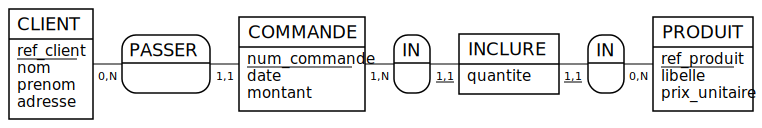

In [103]:
%%mocodo -r labels:ascii,snake drain split explode:arity=2.5,weak arrange:grid=7x1 quiet --seed 2
CLIENT: R√©f. client [VARCHAR(8)], Nom [VARCHAR(255)], Pr√©nom [VARCHAR(255)], Adresse [VARCHAR(255)]
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande [VARCHAR(8)], Date [DATE], Montant [DECIMAL(10,2)]
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantit√© [INTEGER]
PRODUIT: R√©f. produit [VARCHAR(8)], Libell√© [VARCHAR(255)], Prix unitaire [DECIMAL(10,2)]

- Les libell√©s des types sont ensuite r√©duits aux lettres ASCII, chiffres, soulign√©s, tirets, parenth√®ses et crochets. Les virgules n'√©tant malheureusement pas admises pour le moment (cf. [issue 1546 sur le d√©p√¥t de Mermaid](https://github.com/mermaid-js/mermaid/issues/1546)), nous les rempla√ßons par des tirets (ainsi `DECIMAL(10,2)` devient `DECIMAL(10-2)`).
- On permute les cardinalit√©s de part et d'autre des associations (toutes binaires √† ce stade), pour passer de la convention _look here_ (Merise) √† la convention _look across_ (beaucoup plus r√©pandue, malgr√© son inaptitude √† la repr√©sentation des associations n-aires).
- On remplace les `0`, `1`, et `1N` des cardinalit√©s par des signes cabalistiques, ‚Äî qui ne le sont plus du tout quand on lit `o` comme _z√©ro_, `|` comme _un_, et `{` ou `}` comme _plusieurs_ (ce sont les pattes du fameux corbeau).
- On √©num√®re ensuite les entit√©s et les associations dans une syntaxe √©vidente. Seule subtilit√©¬†: les pattes de renforcement des entit√©s faibles (correspondant √† un `_11` dans la syntaxe Mocodo) sont en traits pleins, les autres en pointill√©s.

#### ERD selon Chen

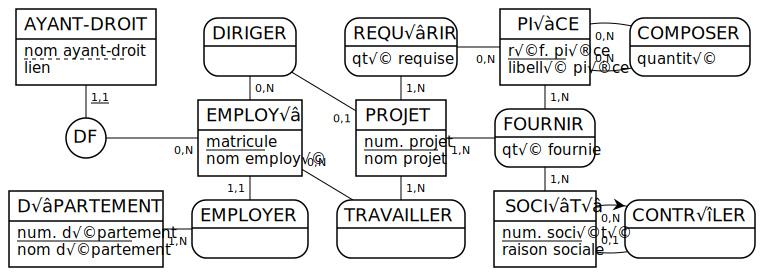

In [424]:
%%mocodo
AYANT-DROIT: nom ayant-droit, lien
DIRIGER, 0N EMPLOY√â, 01 PROJET
REQU√âRIR, 1N PROJET, 0N PI√àCE: qt√© requise
PI√àCE: r√©f. pi√®ce, libell√© pi√®ce
COMPOSER, 0N [compos√©e] PI√àCE, 0N [composante] PI√àCE: quantit√©

DF, _11 AYANT-DROIT, 0N EMPLOY√â
EMPLOY√â: matricule, nom employ√©
PROJET: num. projet, nom projet
FOURNIR, 1N PROJET, 1N PI√àCE, 1N SOCI√âT√â: qt√© fournie

D√âPARTEMENT: num. d√©partement, nom d√©partement
EMPLOYER, 11 EMPLOY√â, 1N D√âPARTEMENT
TRAVAILLER, 0N EMPLOY√â, 1N PROJET
SOCI√âT√â: num. soci√©t√©, raison sociale
CONTR√îLER, 0N< [filiale] SOCI√âT√â, 01 [m√®re] SOCI√âT√â

In [425]:
%mocodo --input sandbox -c chen:attrs,layout=neato,overlap=prism defer --colors=ocean --seed=2

In [426]:
%mocodo --input sandbox -c chen:layout=neato,overlap=prism defer --colors=ocean --seed=4

# R√©√©criture automatique du texte-source d'un MCD

## R√©organiser les bo√Ætes
### Mises en miroir
### R√©arrangements

## D√©composition
### Drainage des attributs des DF
### D√©composition des DF n-aires
### D√©composition des associations n-aires non DF
### D√©composition des associations binaires non DF
### D√©composition avec cr√©ation d'entit√©s faibles
### Simplification de la d√©composition
### Conclusion sur ces d√©compositions

## R√©√©criture de tokens
### Homog√©n√©isation de la typographie
"ascii", "camel", "capitalize", "casefold", "lower", "snake", "swapcase", "title", "upper"
### Standardisation des cardinalit√©s
### Obfuscation des libell√©s
### Randomisation des cardinalit√©s
### Masquage des 

## Compl√©ter un MCD
### Cr√©er les entit√©s manquantes
### Cr√©er des types

# Annexes

## Besoins sp√©cifiques √† la p√©dagogie

## Notation de Chen

### Associations binaires

#### _Look Here_ vs. _Look Across_

Consid√©rons un MCD Merise avec une association de d√©pendance fonctionnelle¬†:

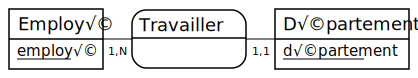

In [317]:
%%mocodo
Employ√©: employ√©
Travailler, 11 D√©partement, 1N Employ√©
D√©partement: d√©partement

Dans le formalisme graphique de Chen, cela donnera¬†:

In [318]:
%mocodo --input sandbox -c chen:layout=circo defer

Le 1 et le N correspondent aux cardinalit√©s maximales du MCD Merise. Comme on voit, elles sont permut√©es. La notation de Merise s'appelle _Look Here_ (LH)¬†; celle de Chen, _Look Across_ (LA). Comme cette derni√®re est la plus r√©pandue dans le monde anglo-saxon, dans ce chapitre on parlera par commodit√© d'¬´¬†ERD¬†¬ª (_Entity-relationship diagram_) pour les mod√®les conceptuels selon Chen, et de ¬´¬†MCD¬†¬ª pour ceux de Merise.

Consid√©rons maintenant les deux versions d'une association avec des cardinalit√©s minimales distinctes¬†:

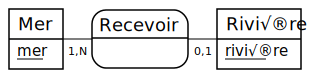

In [272]:
%%mocodo
Mer: mer
Recevoir, 01 Rivi√®re, 1N Mer
Rivi√®re: rivi√®re

In [273]:
%mocodo --input sandbox -c chen:layout=circo defer

Les cardinalit√©s maximales sont toujours permut√©es¬†; par contre, les cardinalit√©s minimales ne le sont pas. Dans l'ERD, elles sont figur√©es par un trait simple (0) ou double (1). On les appelle aussi des ¬´¬†participations¬†¬ª¬†: une rivi√®re peut ne participer (directement) √† l'alimentation d'aucune mer (ce n'est pas un fleuve)¬†; toute mer participe √† la r√©ception d'une rivi√®re (un fleuve) minimum. Les conventions sont donc les suivantes¬†:

| Cardinalit√©s | MCD Merise | ERD Chen |
|:--|:--:|:--:|
| minimale | LH | LH |
| maximale | LH | LA |

La notation Merise a l'avantage de la coh√©rence¬†; celle de Chen en a d'autres, que nous verrons un peu plus loin, et qui expliquent peut-√™tre en partie son succ√®s.

Avant cela, voyons un dernier point de d√©tail¬†: lorsque deux cardinalit√©s N se trouvent de part et d'autre d'une association binaire, l'une est remplac√©e par M.

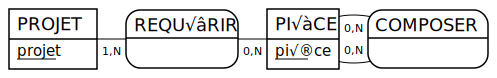

In [314]:
%%mocodo
PROJET: projet
REQU√âRIR, 1N PROJET, 0N PI√àCE
PI√àCE: pi√®ce
COMPOSER, 0N PI√àCE, 0N PI√àCE

In [316]:
%mocodo --input sandbox -c chen:layout=circo defer

#### Entit√©s faibles et entit√©s associatives

Maintenant examinons le cas des entit√©s faibles¬†:

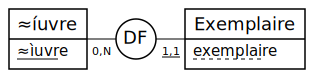

In [276]:
%%mocodo
≈íuvre: ≈ìuvre
DF, 0N ≈íuvre, _11 Exemplaire
Exemplaire: exemplaire

In [277]:
%mocodo --input sandbox -c chen:layout=circo defer

L'entit√© faible, √† l'instar de la DF ¬´¬†renfor√ßante¬†¬ª, sont entour√©es d'un double trait.

Le vocabulaire de Chen comporte encore un √©l√©ment graphique, que Merise ne distingue pas sp√©cialement. Nous avons vu que toute association non DF pouvait √™tre d√©compos√©e de fa√ßon √©quivalente par l'insertion d'entit√©s faibles¬†:

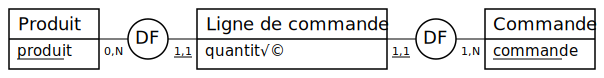

In [427]:
%%mocodo
Produit: produit
DF, _11 Ligne de commande, 0N Produit
Ligne de commande: _quantit√©
DF, _11 Ligne de commande, 1N Commande
Commande: commande

L'entit√© LIGNE DE COMMANDE peut √™tre qualifi√©e d'¬´¬†associative¬†¬ª, et Chen la figure logiquement par un losange (association) inscrit dans un rectangle (entit√©), ce que Graphviz ne prend actuellement [pas](https://stackoverflow.com/questions/48046186/is-it-possible-to-have-nested-node-shapes-on-graphviz) en charge. Nous l'approximons donc ainsi¬†:

In [279]:
%mocodo --input sandbox -c chen:layout=circo,mindist=2,scale=0.6 defer

### Associations n-aires

#### Triplet NNN

Jusqu'ici, la diff√©rence entre les deux notations √©tait purement cosm√©tique. Qu'en est-il des associations n-aires, et que signifie _Look Across_ quand _across_ peut d√©signer plusieurs endroits¬†?

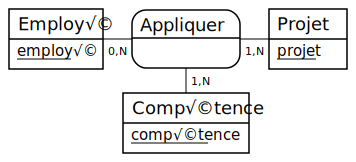

**Appliquer** (<ins>employ√©</ins>, <ins>projet</ins>, <ins>comp√©tence</ins>)


In [319]:
%%mocodo --mld
Employ√©: employ√©
Appliquer, 0N Employ√©, 1N Projet, 1N Comp√©tence
Projet: projet

Comp√©tence: comp√©tence

Dans ce cas (le plus usuel), la question ne se pose pas vraiment, ou du moins n'est pas tranch√©e de fa√ßon √©vidente¬†:

In [320]:
%mocodo --input sandbox -c chen:layout=circo,mindist=1,scale=0.4 defer

Quels sont les autres cas¬†? Il ne s'agit pas de ceux o√π l'association n-aire est entour√©e d'une ou plusieurs cardinalit√©s maximale 1, puisqu'on pourrait alors la d√©composer en DF binaires (cf. sous-option `split`). En r√©alit√©, on touche ici aux limites de la notation _Look Here_, plus intuitive, mais moins puissante que _Look Across_, et que Merise n'a pu d√©passer qu'avec sa version 2.

Pour r√©pondre progressivement √† notre question, proc√©dons d√©sormais dans l'ordre inverse, en pr√©sentant d'abord l'ERD, et ensuite seulement le MCD √©quivalent.

Les exemples qui suivent (ainsi d'ailleurs que le pr√©c√©dent), sont adapt√©s des pages 28 sqq. et 96 sqq. de l'ouvrage de Toby J. Teorey, Sam S. Lightstone, Tom Nadeau, H.V. Jagadish, _Database Modeling and Design - Logical Design_, 5th Edition - February 10, 2011 (Elsevier).

#### Triplet 1NN

Le premier ERD apportant v√©ritablement quelque chose de nouveau a cette structure¬†:

In [283]:
%mocodo --input ../LA_1NN.mcd -c chen:layout=circo,mindist=1,scale=0.45 defer

Les auteurs explicitent ainsi ses r√®gles de gestion¬†:

> _Chaque ing√©nieur travaillant sur un projet particulier a exactement un responsable, mais chaque responsable d'un projet peut g√©rer plusieurs ing√©nieurs, et chaque responsable d'un ing√©nieur peut g√©rer cet ing√©nieur sur plusieurs projets._

Reprenons ces trois assertions, et faisons-les correspondre au trois cardinalit√©s dans le sens anti-horaire √† partir du 1 :

- 1 : pour un couple (ing√©nieur, projet) donn√©, un seul responsable possible ;
- N : pour un couple (responsable, projet) donn√©, plusieurs ing√©nieurs possibles ;
- N : pour un couple (responsable, ing√©nieur) donn√©, plusieurs projets possibles.

Avec Merise, les assertions seraient plut√¥t du type : ¬´ pour un x donn√©, _tant_ de couples (y, z) possibles ¬ª. Il y a donc bien permutation, mais permutation des r√©f√©rences au singleton et au $n-1$-uplet.

C'est la r√©ponse √† notre question initiale, et nous verrons avec plaisir qu'elle reste valable quel que soit le triplet de cardinalit√©s de l'association ternaire.

Pour l'instant, r√©sumons les r√®gles de gestion par cette **unique** d√©pendance fonctionnelle¬†:

- (Ing√©nieur, Projet) $\implies$ Responsable.

Pour exprimer cela en (d√©pit de) _Look Here_, on doit recourir √† une CIF (figur√©e ci-dessous en notation simplifi√©e)¬†:

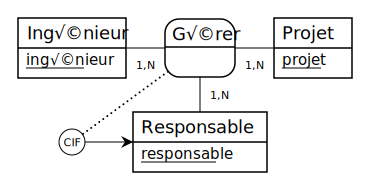

**G√©rer** (<ins>ing√©nieur</ins>, <ins>projet</ins>, responsable)


In [380]:
%%mocodo --mld
Ing√©nieur: ing√©nieur
G√©rer, /1N Responsable, 1N Ing√©nieur, 1N Projet
Projet: projet

Responsable: responsable
    
(CIF) ..G√©rer, -> Responsable: Ing√©nieur, Responsable

.. ou √† un agr√©gat¬†:

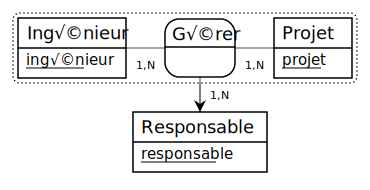

**G√©rer** (<ins>ing√©nieur</ins>, <ins>projet</ins>, responsable)


In [381]:
%%mocodo --mld
Ing√©nieur: ing√©nieur
G√©rer, /1N Responsable, 1N Ing√©nieur, 1N Projet
Projet: projet

Responsable: responsable

On constate que dans l'un et l'autre cas, le MLD produit respecte bien la d√©pendance fonctionnelle d√©sir√©e¬†: (Ing√©nieur, Projet) $\implies$ Responsable.

#### Triplet 11N

Passons √† la deuxi√®me combinaison int√©ressante¬†:

In [248]:
%mocodo --input ../LA_11N.mcd -c chen:layout=circo,mindist=1,scale=0.45 defer

R√®gles de gestion¬†:

> _Chaque employ√© affect√© √† un projet travaille sur un seul site pour ce projet, mais peut se trouver sur diff√©rents sites pour diff√©rents projets. Sur un site donn√©, un salari√© ne travaille que sur un seul projet. Sur un site donn√©, il peut y avoir plusieurs employ√©s affect√©s √† un projet donn√©._

Autrement dit (en partant du bas et dans le sens anti-horaire) :

1 : pour un couple (projet, employ√©) donn√©, un seul site possible¬†;
1 : pour un couple (employ√©, site) donn√©, un seul projet possible ;
N : pour un couple (projet, site) donn√©, plusieurs employ√©s possibles.

En r√©sum√©, **deux** d√©pendances fonctionnelles¬†:

- (Projet, Employ√©) $\implies$ Site.
- (Employ√©, Site) $\implies$ Projet.

Voici le MCD correspondant, successivement avec des CIF et des agr√©gats¬†:

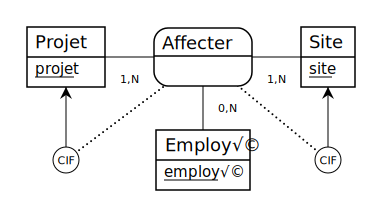

**Affecter** (<ins>projet</ins>, <ins>employ√©</ins> <sup>u1</sup>, site <sup>u1</sup>)


In [382]:
%%mocodo --mld
Projet: projet
Affecter, /1N Site, /1N Projet, 0N Employ√©
Site: site

Employ√©: employ√©
    
(CIF) ..Affecter, ->Site: Site, Employ√©
(CIF) ..Affecter, ->Projet: Projet, Employ√©

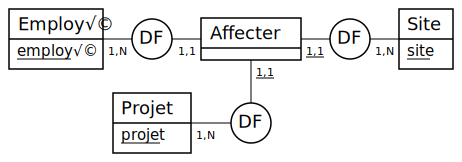

**Affecter** (<ins>projet</ins>, <ins>site</ins>, employ√©)


In [437]:
%%mocodo --mld
Employ√©: employ√©
DF, 1N Employ√©, 11 Affecter
Affecter:
DF, _11 Affecter, 1N Site
Site: site

Projet: projet
DF, _11 Affecter, 1N Projet
:

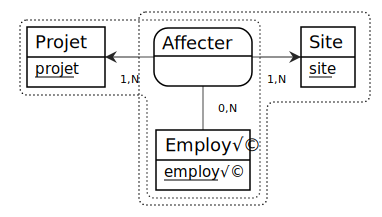

**Affecter** (<ins>projet</ins>, <ins>employ√©</ins> <sup>u1</sup>, site <sup>u1</sup>)


In [383]:
%%mocodo --mld
Projet: projet
Affecter, /1N Site, /1N Projet, 0N Employ√©
Site: site

Employ√©: employ√©

On voit appara√Ætre dans le sch√©ma relationnel un ¬´¬†u1¬†¬ª en exposant qui signifie¬†: contrainte d'unicit√© n¬∞1. Il y a en effet deux cl√©s candidates¬†: (projet, employ√©) et (employ√©, site). Seule l'une des deux est devenue cl√© primaire, mais cela ne veut pas dire qu'on a perdu la contrainte de d√©pendance fonctionnelle induite par l'autre. On peut s'en convaincre en g√©n√©rant le DDL¬†:

In [216]:
%mocodo --input sandbox -c rel:mysql --title="triplet_11N"

```sql
CREATE DATABASE IF NOT EXISTS `TRIPLET_11N`;
USE `TRIPLET_11N`;

CREATE TABLE `AFFECTER` (
  `projet` VARCHAR(42),
  `employ√©` VARCHAR(42),
  `site` VARCHAR(42),
  PRIMARY KEY (`projet`, `employ√©` )
) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4;

ALTER TABLE `AFFECTER` ADD CONSTRAINT `affecter_u1` UNIQUE (`employ√©`, `site`);

```

#### Triplet 111

La derni√®re combinaison ob√©it √† la m√™me logique¬†:

In [249]:
%mocodo --input ../LA_111.mcd -c chen:layout=circo,mindist=1,scale=0.45 defer

R√®gles de gestion¬†:

> _Un technicien utilise exactement un carnet pour chaque projet. Chaque carnet appartient √† un technicien pour chaque projet. Notez qu'un technicien peut toujours travailler sur plusieurs projets et g√©rer diff√©rents carnets pour diff√©rents projets._

Autrement dit (en partant du haut et dans le sens horaire) :

- 1 : pour un couple (technicien, projet) donn√©, un seul carnet possible¬†;
- 1 : pour un couple (carnet, projet) donn√©, un seul technicien possible¬†;
- 1 : pour un couple (carnet, technicien) donn√©, un seul projet possible.

En r√©sum√©, **trois** d√©pendances fonctionnelles¬†:

- (Technicien, Projet) $\implies$ Carnet.
- (Carnet, Technicien) $\implies$ Projet.
- (Carnet, Projet) $\implies$ Technicien.

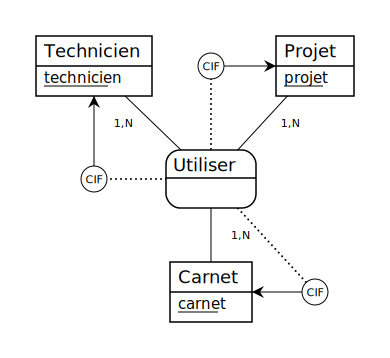

**Utiliser** (<ins>carnet</ins> <sup>u1</sup>, <ins>projet</ins> <sup>u2</sup>, technicien <sup>u1 u2</sup>)


In [384]:
%%mocodo --mld
Technicien: technicien
:
Projet: projet

Utiliser, /1N Technicien, /1N Carnet, /1N Projet
    
Carnet: carnet

(CIF) ..Utiliser, --> Technicien: Technicien, Utiliser
(CIF) ..Utiliser, --> Projet: Utiliser, Projet
(CIF) ..Utiliser, --> Carnet: Projet, Carnet

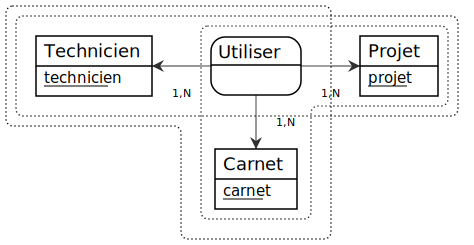

**Utiliser** (<ins>carnet</ins> <sup>u1</sup>, <ins>projet</ins> <sup>u2</sup>, technicien <sup>u1 u2</sup>)


In [414]:
%%mocodo --mld
Technicien: technicien
Utiliser, /1N Technicien, /1N Carnet, /1N Projet
Projet: projet

Carnet: carnet

Il y a maintenant trois cl√©s candidates, correspondant √† deux contraintes d'unicit√©.

In [386]:
%mocodo --input sandbox -c rel:mysql --title="triplet_111"

```sql
CREATE DATABASE IF NOT EXISTS `TRIPLET_111`;
USE `TRIPLET_111`;

CREATE TABLE `UTILISER` (
  `carnet` VARCHAR(42),
  `projet` VARCHAR(42),
  `technicien` VARCHAR(42),
  PRIMARY KEY (`carnet` `projet` )
) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4;

ALTER TABLE `UTILISER` ADD CONSTRAINT `utiliser_u1` UNIQUE (`carnet`, `technicien`);
ALTER TABLE `UTILISER` ADD CONSTRAINT `utiliser_u2` UNIQUE (`projet`, `technicien`);

```

### Discussion

Nous ne le savions pas en l'introduisant dans Mocodo 3, mais la syntaxe `/1N` pour les agr√©gats permet d'exprimer parfaitement (et simplement¬†!) toutes les combinaisons possibles de cardinalit√©s d'une association n-aire dans la notation de Chen¬†: il suffit de mettre un `/1N` partout o√π se trouve un `1`¬†! Chacun cr√©era une nouvelle d√©pendance fonctionnelle, autrement dit, une nouvelle cl√© candidate.

Plus rigoureusement¬†: supposons une association $n$-aire $A$ exclusivement entour√©e de 1N (ou 0N). Soient $E_1$, $E_2$, ..., $E_n$ les entit√©s mises en jeu, et $k_1, k_2$, ..., $k_n$ leurs identifiants respectifs. Alors, noter `/1N` (ou `/0N`) la cardinalit√© de la patte de $E_i$ d√©note l'existence de la d√©pendance fonctionnelle suivante¬†: $(k_1, ..., k_{i-1}, k_{i+1}, ..., k_n) \implies k_i$, autrement dit¬†: que $(k_1, ..., k_{i-1}, k_{i+1}, ..., k_n)$ est une cl√© candidate de la table $A$.

Notez au passage que Mocodo permet de sp√©cifier √† co√ªt z√©ro quelle cl√© candidate sera √©lue cl√© primaire. Il suffit pour cela de placer en t√™te de la liste des entit√©s mises en jeu par $A$ celle dont l'identifiant ne doit **pas** entrer dans la cl√© primaire. Si c'est $E_1$, la cl√© primaire sera automatiquement $(k_2, ..., k_n)$.

Dans tous les cas, les cl√©s alternatives se voient traduites aux niveaux relationnel et physique par des contraintes d'unicit√©.

Au terme de cette petite √©tude, je ne puis me d√©fendre de l'impression que les associations ternaires repr√©sentent pour Merise une occasion manqu√©e, cons√©cutive au choix d'une notation LH. L'introduction de cet √©l√©ment dans le vocabulaire graphique est sous-exploit√© : des quatre combinaisons de cardinalit√©s maximales (NNN, 1NN, 11N, 111), les trois derni√®res sont honnies¬†; la premi√®re elle-m√™me n'est souvent que tol√©r√©e. En notation LA, chacune a sa raison d'√™tre et sa propre s√©mantique. La premi√®re (NNN) co√Øncide heureusement avec LH, mais c'est tout. Dommage¬†?

## Cr√©dits

- **Auteur**
  - Aristide Grange, Universit√© de Lorraine, Metz, [LCOMS](http://lcoms.univ-lorraine.fr).
- **Outils**
  - Aspect visuel
    - [Color Brewer](http://colorbrewer2.org) (Cynthia Brewer).
    - [Font Awesome](http://fortawesome.github.io/Font-Awesome/) (Dave Gandy).
    - [Fork me on GitHub Retina Ribbons](https://ar.al/scribbles/fork-me-on-github-retina-ribbons/) (Aral Balkan).
    - [Real Favicon Generator](http://realfavicongenerator.net) (Philippe Bernard).
    - [reset.css](http://meyerweb.com/eric/tools/css/reset/) (Eric Meyer).
    - [Source Code Pro](https://github.com/adobe-fonts/source-code-pro) (Paul D. Hunt).
  - JavaScript
    - [JQuery](http://jquery.com/) (John Resig).
    - [JS-Cookie](https://github.com/js-cookie/js-cookie) (Klaus Hartl).
  - Python
    - [Distance de Damerau-Levenshtein](http://mwh.geek.nz/2009/04/26/python-damerau-levenshtein-distance/) (Michael Homer).
- **[Localisation](https://www.transifex.com/aristide/mocodo/)**
  - Allemand: Pascal Fickert, Luis Willnat.
  - Chinois: Liu Jingjiao.
  - Fran√ßais: Aristide Grange.
- **Sans oublier** 
  Abou-Sophiane Belhadj,
  Kamel Chelghoum,
  R√©mi Da Costa,
  Benjamin Gannat,
  Thomas Giro,
  Michel Grandmougin,
  Alexandre Grison,
  David Lorge,
  Dorian Mahut,
  S√©bastien Martin,
  Cyril Minette,
  Idris Neumann,
  Bryan Oakley,
  Georges Perec,
  C√©dric Poinsaint,
  Zsuzsanna R√≥ka,
  Florian Rom√©o,
  Tong Ji
  et d'innombrables contributeurs de [Stack Overflow](http://stackoverflow.com).